# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline


In [2]:
# Additional libraries
import operator
from matplotlib.ticker import AutoMinorLocator, PercentFormatter
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import bisect
from timeit import default_timer as timer

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
# azdias
print(azdias.shape)
display(azdias.head())


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# azdias_feature_summary
print(feat_info.shape)
display(feat_info.head())

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
#Set max rows/columns to be able to view all 85 attributes
pd.options.display.max_columns = 90
pd.options.display.max_rows = 90

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Make a copy for manual cleaning
feat_info_clean = feat_info.copy()
azdias_clean = azdias.copy()

In [8]:
feat_info_clean.attribute.nunique()

85

All the entries in attribute column are unique, so we can make `attribute` the primary index for feat_info_clean table.

In [9]:
feat_info_clean.set_index('attribute', inplace=True)

In [10]:
# Convert string representation of missing_or_uknown to a list of strings
feat_info_clean.missing_or_unknown = feat_info_clean.missing_or_unknown.str.strip('[]').str.split(',')

In [11]:
azdias_clean.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

Since the columns can be of one of three datatypes, as shown above, we need to convert the list of unknown/missing codes to the correct datatype for that column, before comparing it against entries of that column. If the entry matches one of the options for the unknown/missing codes for that column, we will replace it with np.nan.

In [12]:
def replace_code_with_nan(df, feat_df):
    '''
    Replaces codes for missing or unknown in the dataframe with np.nan
    
    INPUT:  df - data frame to perform replacement in 
            feat_df - feature_info dataframe to look up missing/unknown codes
            
    OUTPUT:
            dataframe with nan instead of codes
    '''
    try:
        for col_name, col_ser in df.iteritems():
            codes_list = feat_df.loc[col_name].missing_or_unknown # codes as list of strings
            # convert list entries to appropriate datatype for that col
            if df[col_name].dtype == "int64":
                codes_list = [int(x) for x in codes_list if x != '']
            if df[col_name].dtype == "float64":        
                codes_list = [float(x) for x in codes_list if x != '']  
            # Replace with np.nan if an entry matches a missing code
            df[col_name] = col_ser.apply(lambda x: x if x not in codes_list else np.nan)
        return df
    except KeyError as e:
        print('col missing in Feature summary')
        raise e


In [13]:
azdias_clean = replace_code_with_nan(azdias_clean, feat_info_clean)

Now, let's plot the naturally missing and encoded missing counts against the column names.

In [14]:
def get_missing_counts(df):
    '''
    Get Number of nulls in every column of dataframe as a list
    
    INPUT:  df - ref data frame 
            
    OUTPUT:
            list of null counts
    '''
    return df.isnull().sum().tolist()

In [15]:
# Entries missing and marked as nan in the original dataframe during import
naturally_missing = get_missing_counts(azdias)
# New count for np.nan entries after converting encoded missing also to nan
total_missing = get_missing_counts(azdias_clean)
# Number of entries encoded missing for each col, as difference between old and new missing counts
encoded_missing = list(map(operator.sub, total_missing, naturally_missing))

In [16]:
# Make sure order of attributes/index in feat_info_clean is the same as order of columns in azdias
assert (feat_info_clean.index.tolist() == azdias_clean.columns.values.tolist())

In [17]:
# X axis locations and labels - for attributes
xloc = list(range(len(naturally_missing)))
xlabels = azdias.columns.values

Since the information levels are laid out contiguously, we can indicate the start of each new information level group
with vlines. This will allow us to see trends of naturally missing vs encoded missing by information level.

In [18]:
# Array of information levels for each attribute
info_level_list = feat_info_clean.information_level.tolist()
prev = info_level_list[0]
# First info level vline at x = -0.5
vline_loc = [-0.5]
vline_labels = [prev]
for idx in range(1, len(info_level_list)):
    # Add a vline whenever the info level changes
    if info_level_list[idx] != prev:
        vline_loc.append(idx-0.5)
        vline_labels.append(info_level_list[idx])
    prev = info_level_list[idx]

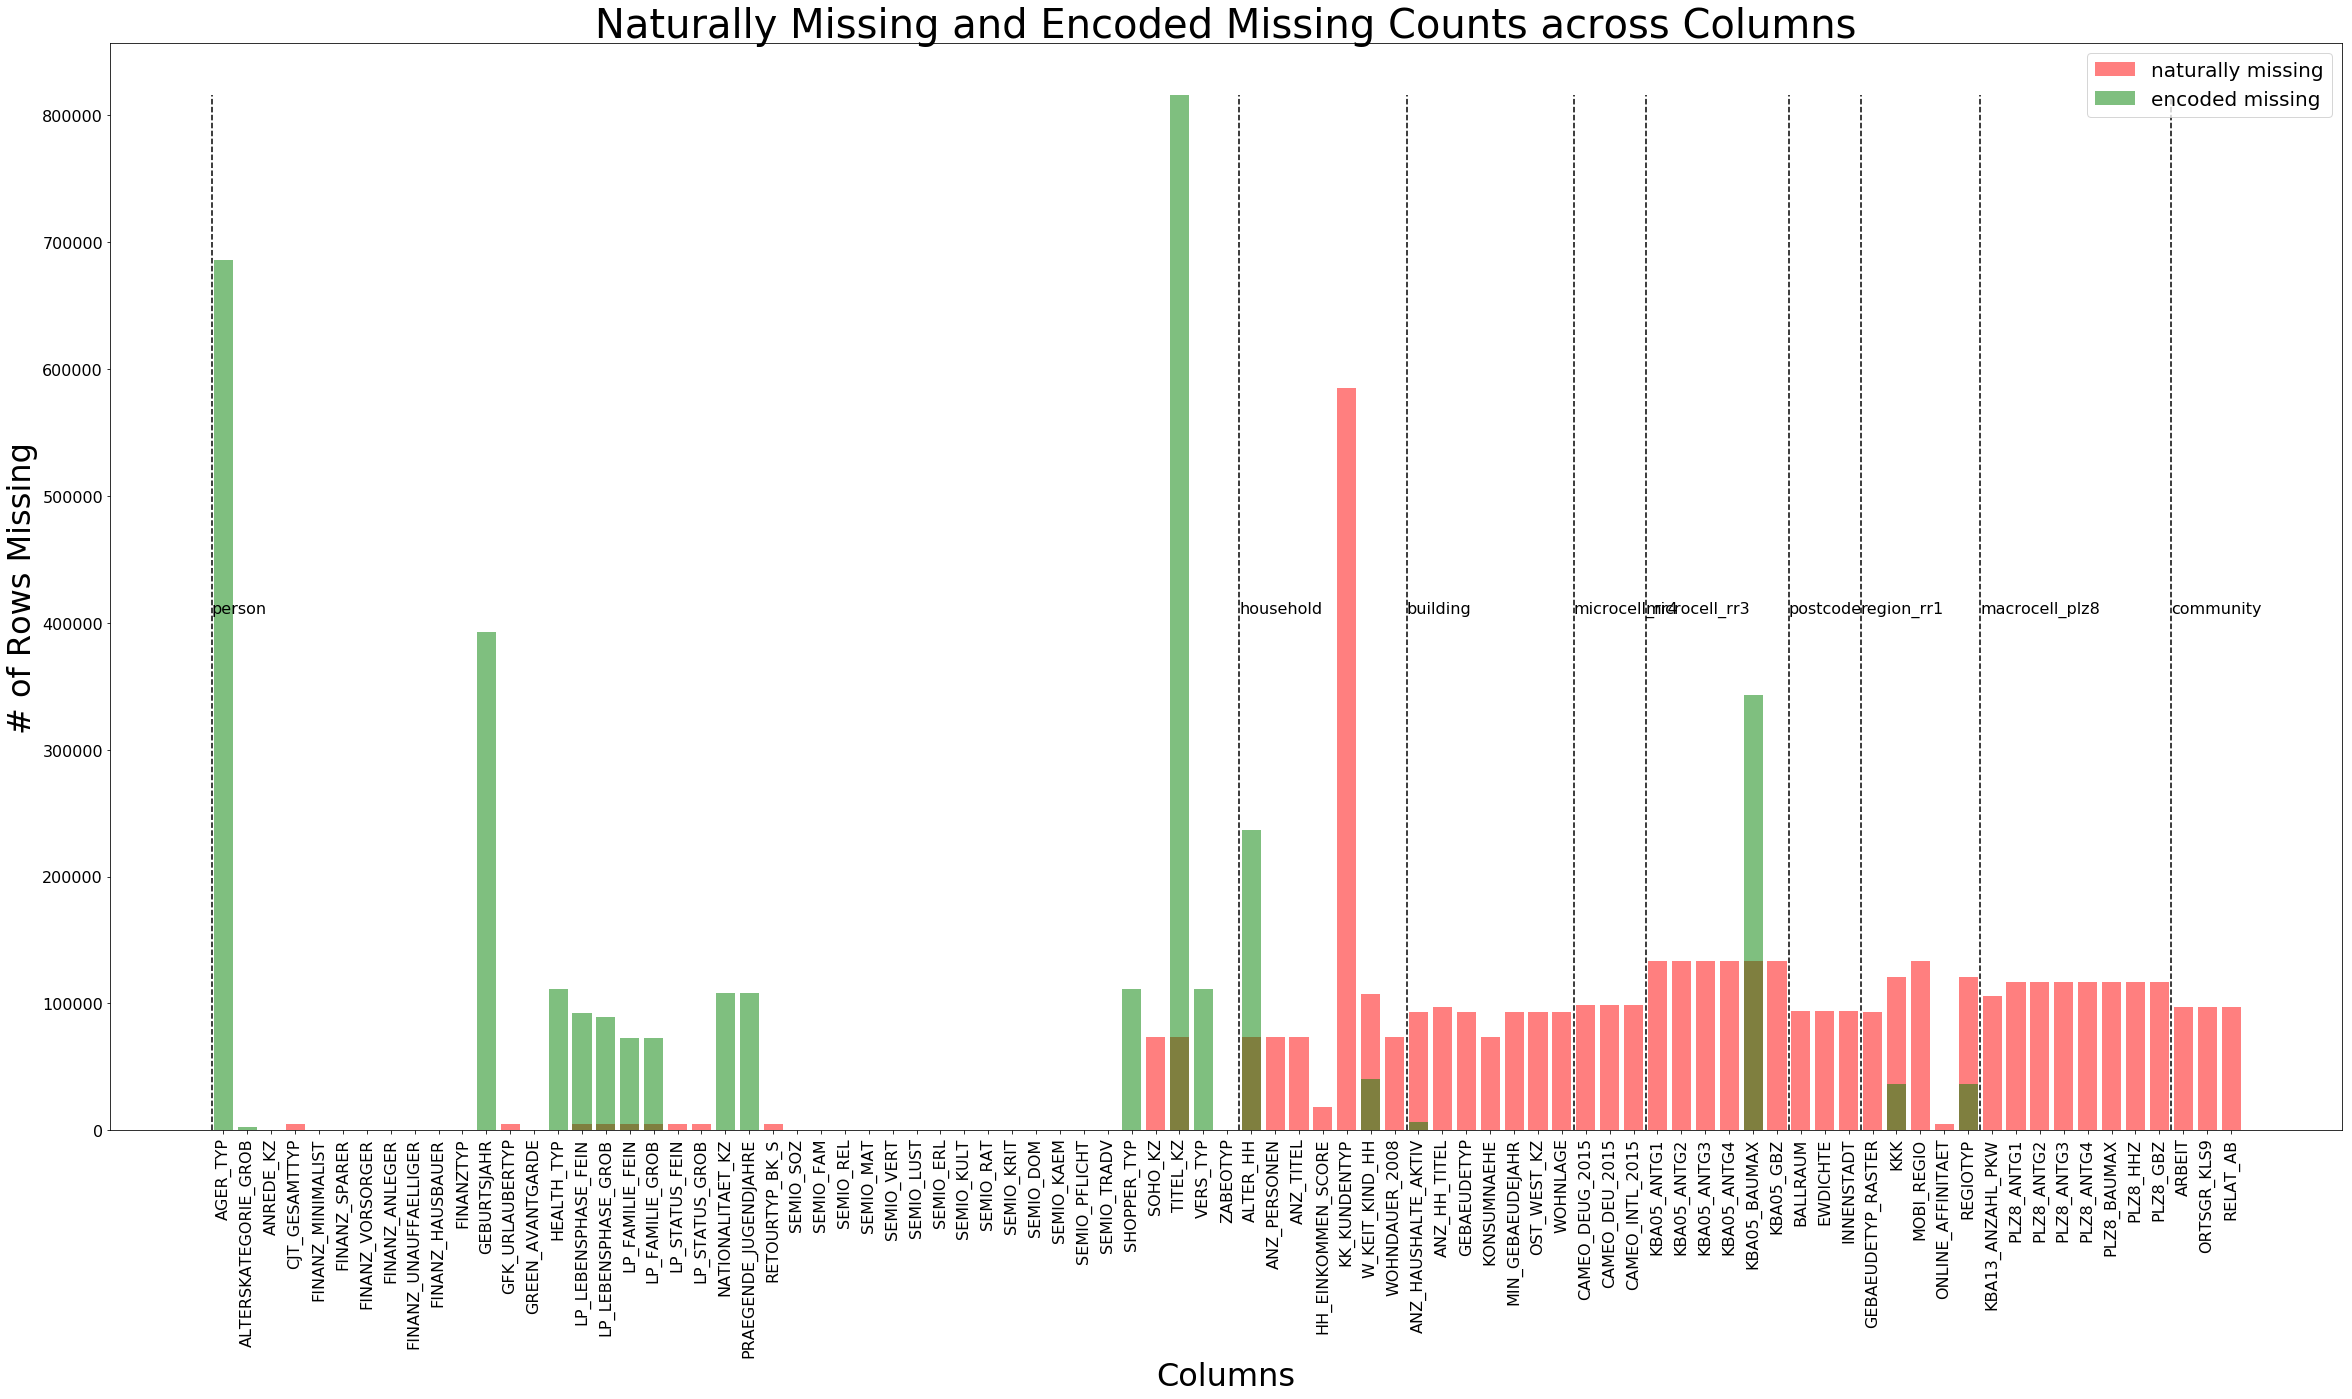

In [19]:
# Max height 
max_y = max( max(naturally_missing), max(encoded_missing))
plt.figure(figsize=(40, 20))
# Increase labelsize
plt.tick_params(axis='both', which='major', labelsize=16)
# Naturally missing in red
plt.bar(xloc, naturally_missing, alpha = 0.5, label = 'naturally missing', color = 'r')
# Encoded missing in green
plt.bar(xloc, encoded_missing, alpha = 0.5, label = 'encoded missing', color = 'g')
plt.xticks(xloc, xlabels, rotation = 'vertical')
plt.legend(fontsize=20)
# Add vlines for start of new info group
plt.vlines(vline_loc, 0, max_y, linestyles='dashed')
for idx, vloc in enumerate(vline_loc):
    vloc_y = max_y/2
    plt.annotate(vline_labels[idx], (vloc, vloc_y), fontsize=16)
plt.xlabel('Columns', fontsize=32)
plt.ylabel('# of Rows Missing', fontsize=32)
plt.title('Naturally Missing and Encoded Missing Counts across Columns', fontsize=40)
plt.show()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
proportion_missing = [ 100 * x / azdias_clean.shape[0] for x in total_missing] # Convert total missing to percent

Let's plot a histogram of the proportion of rows missing counts, splitting it across 10 bins.

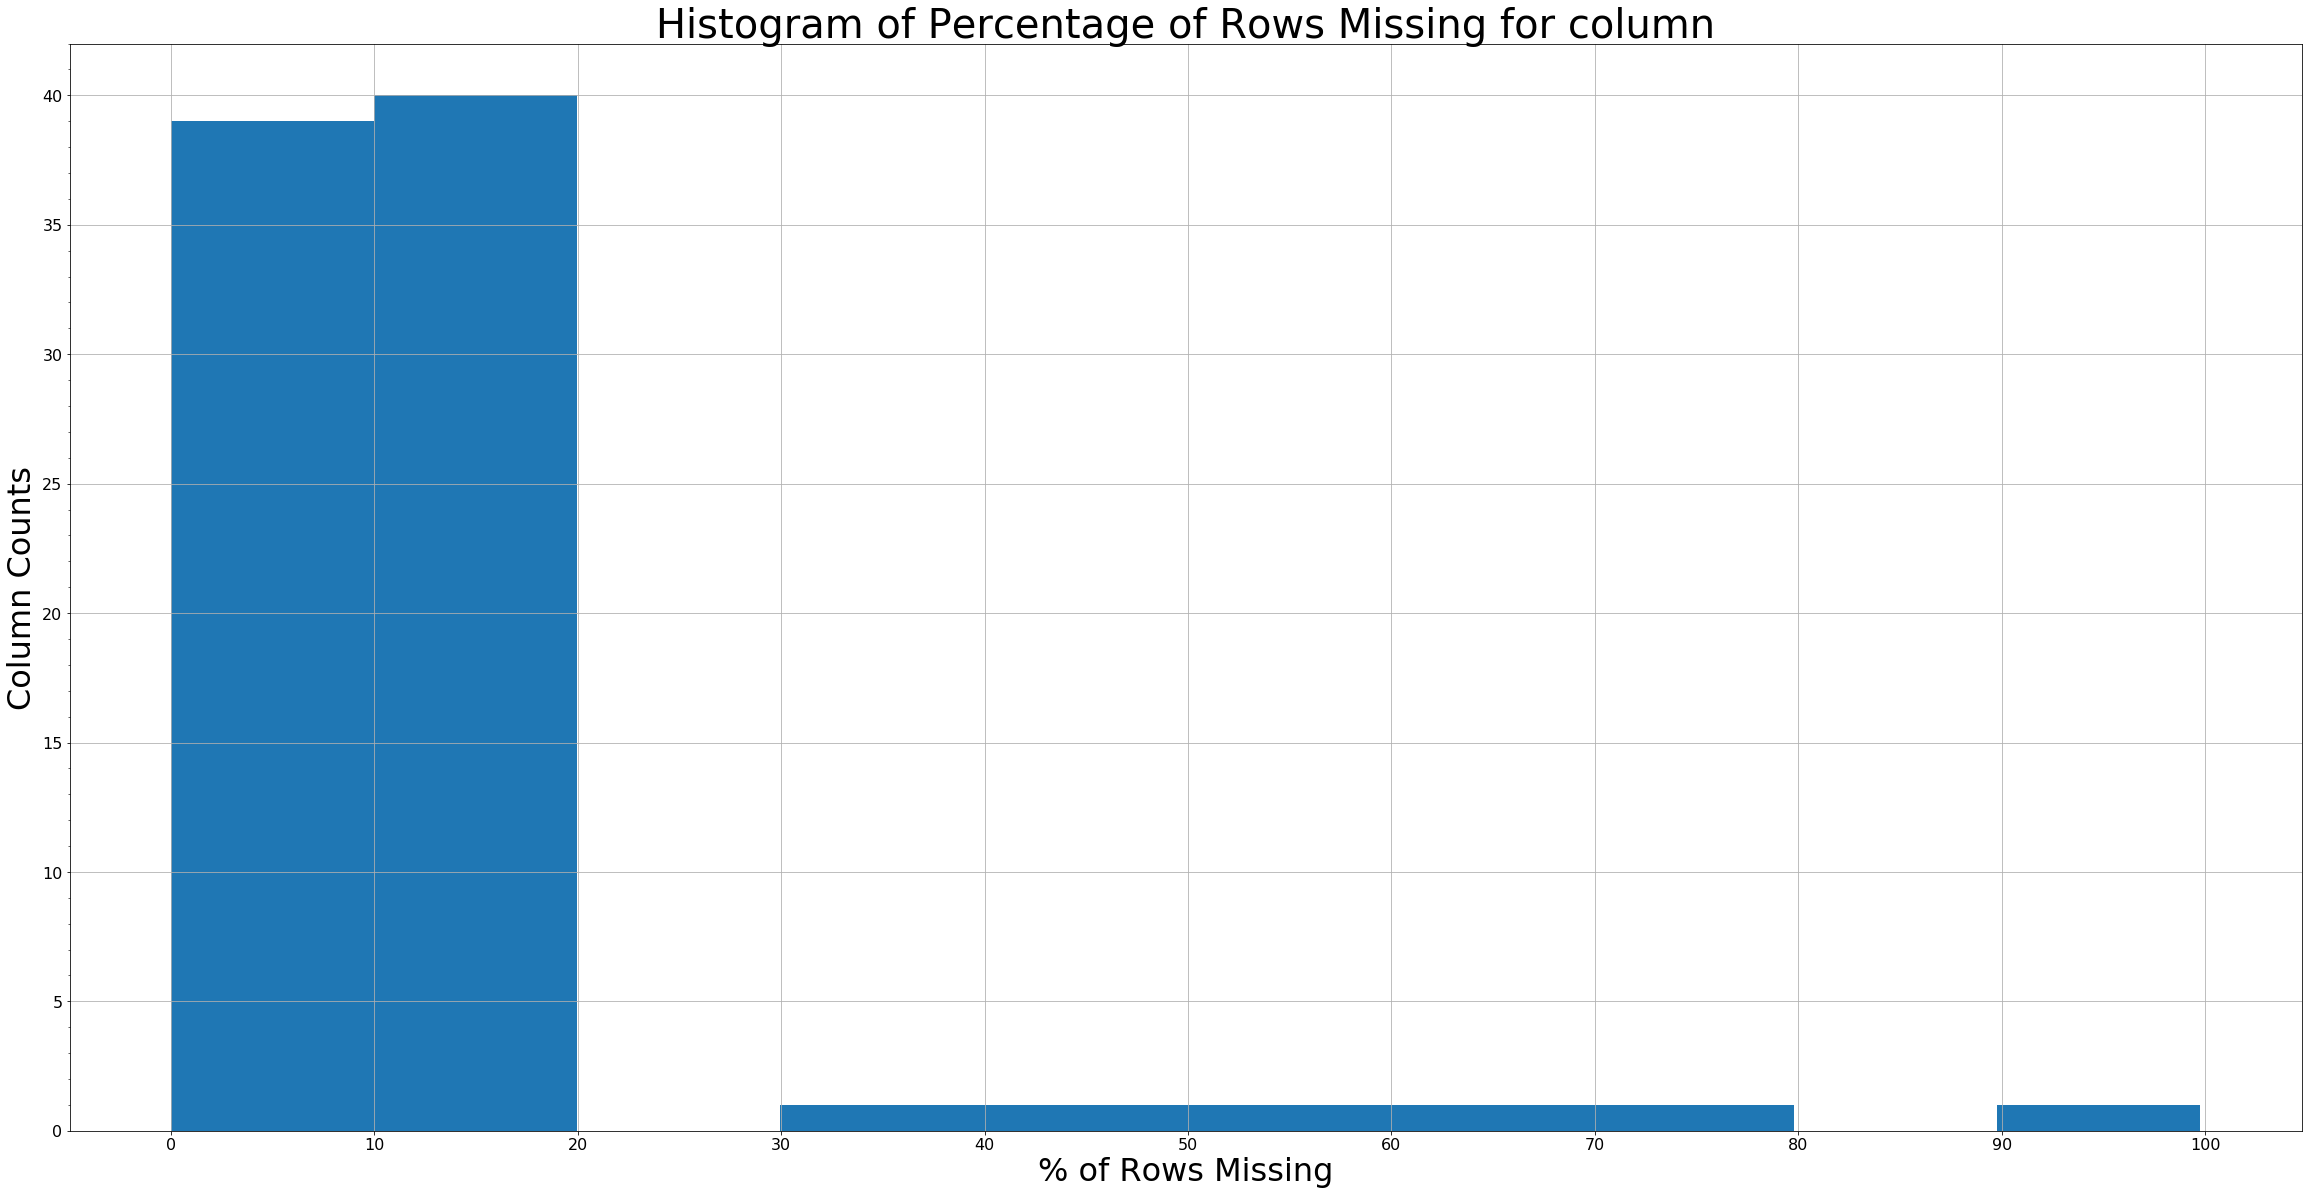

In [21]:
plt.figure(figsize=(40, 20))
plt.grid(axis='both')
# Get current axes
ax = plt.gca()
# Minor ticks for 1 step granularity
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# Increase labelsize
plt.tick_params(axis='both', which='major', labelsize=16)
# Proportion missing
plt.hist(proportion_missing, bins=10)
# Place x ticks for every 10%
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('% of Rows Missing', fontsize=32)
plt.ylabel('Column Counts', fontsize=32)
plt.title('Histogram of Percentage of Rows Missing for column', fontsize=40)
plt.show()

We can see that majority of the columns have a proportion of missing data that's less than 20%. There are 6 columns (one in each 10% bin) that have more than 30% of data missing. We can identify these, using a bar graph like in section 1.1.1, but instead plotting the total missing percentage. We will place a horizontal line at 20% proportion to be able to identify the trends among the six missing columns.

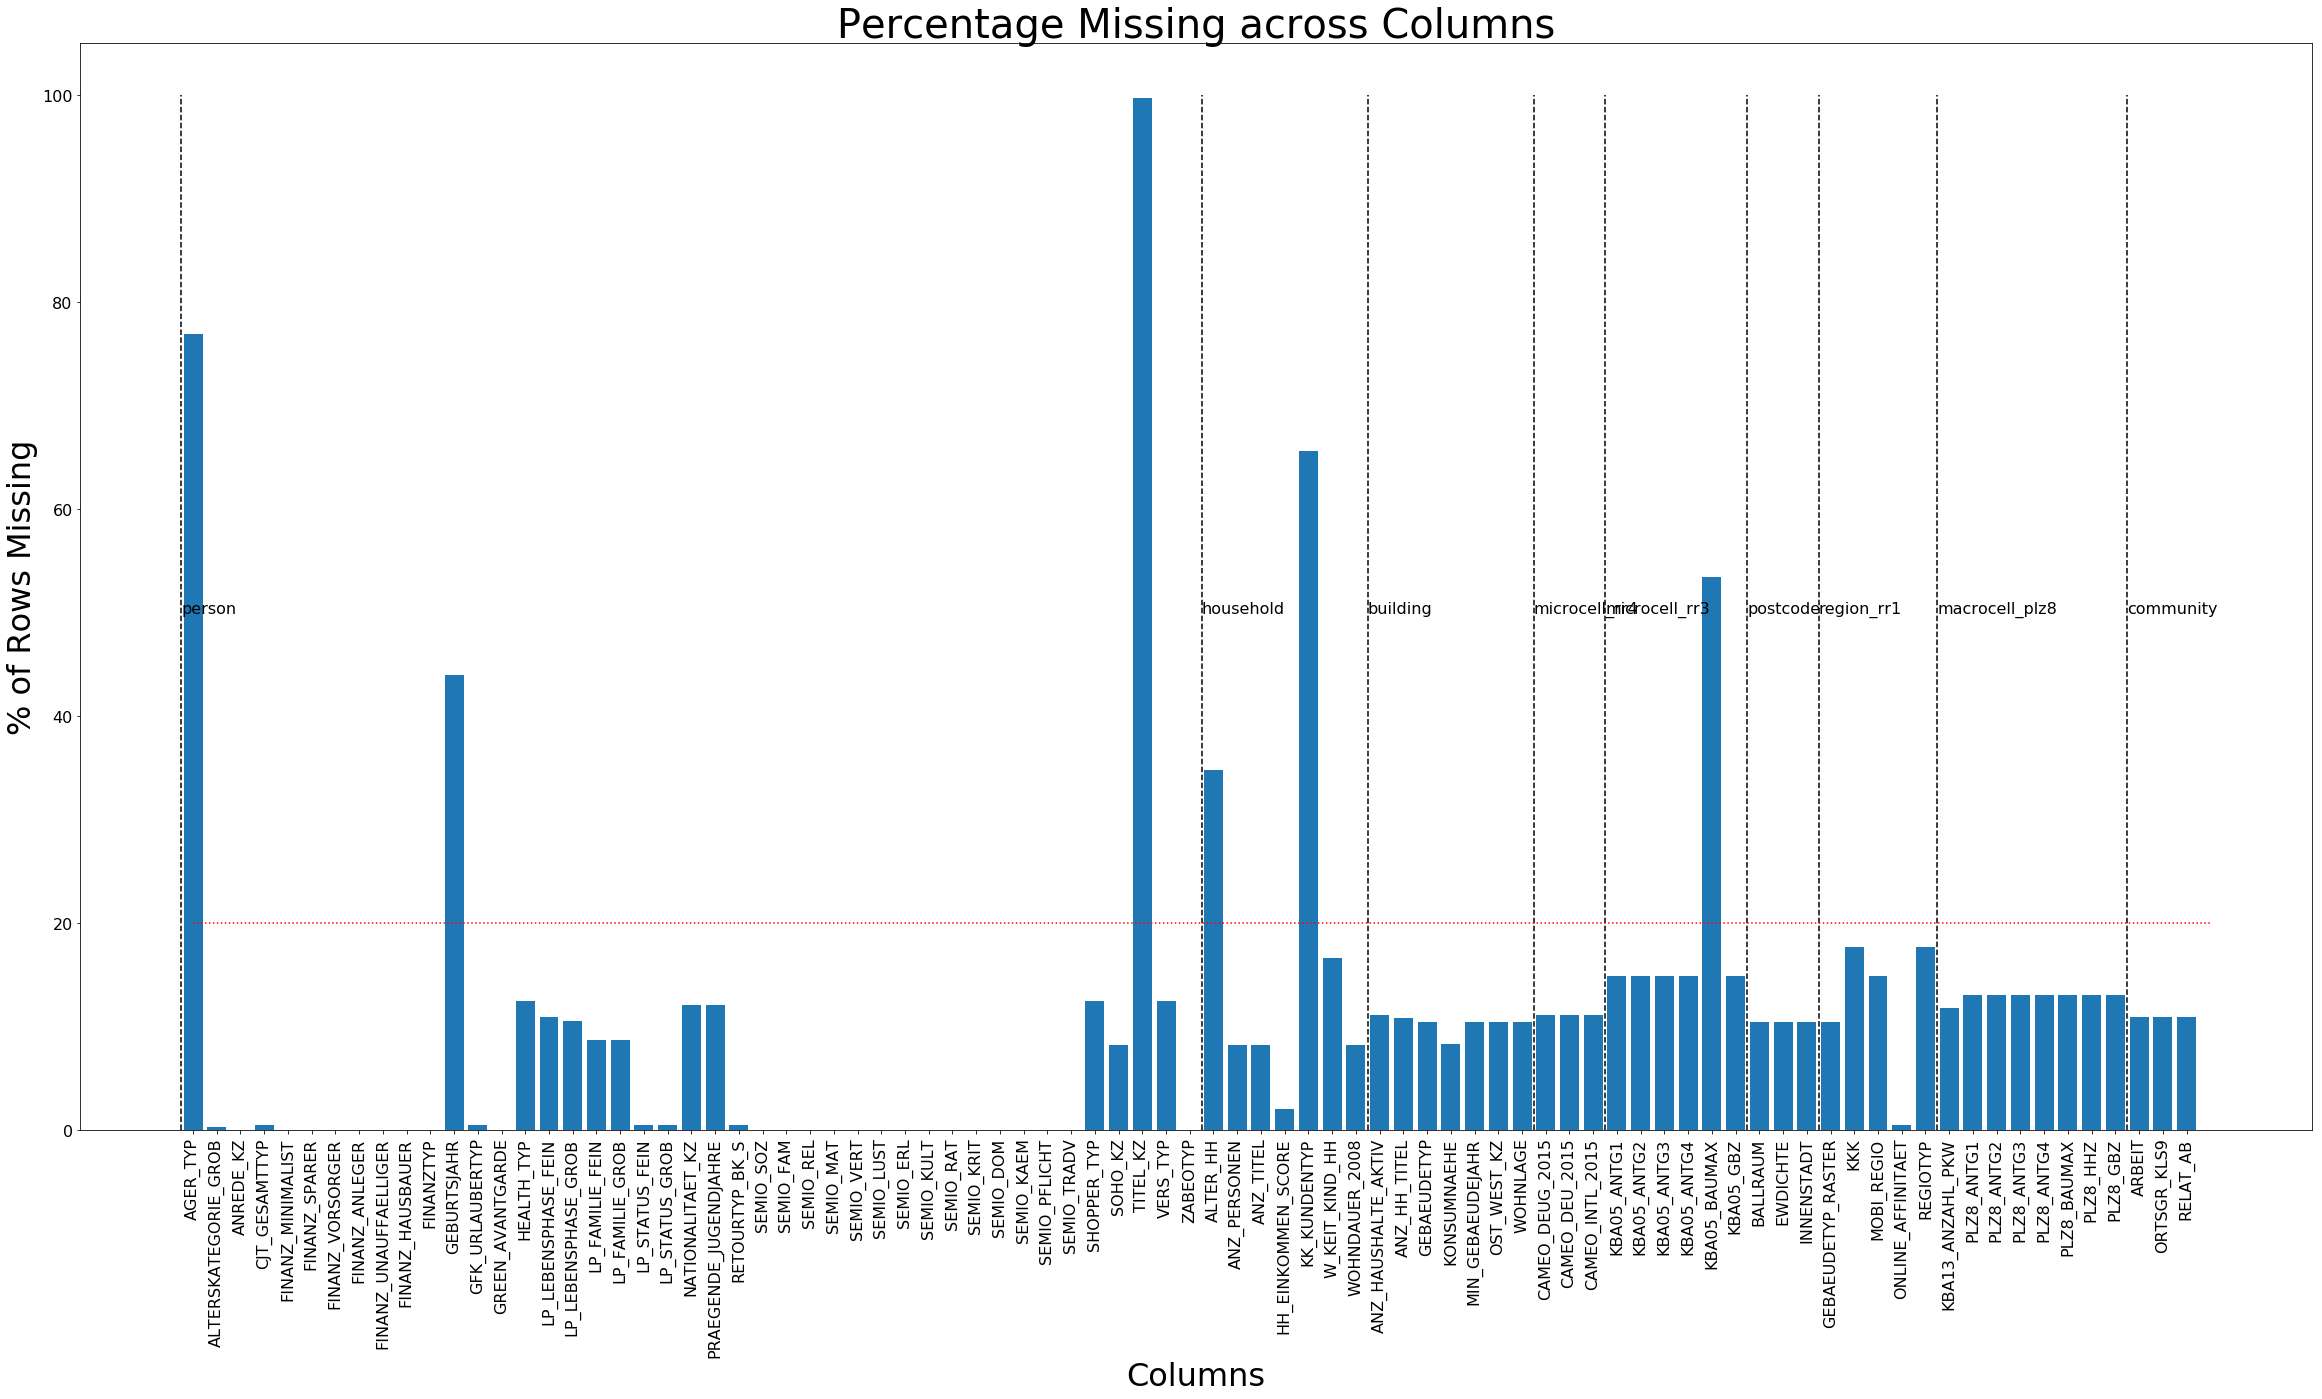

In [22]:
# Investigate patterns in the amount of missing data in each column.
# Max height 
max_y = 100
plt.figure(figsize=(40, 20))
# Increase labelsize
plt.tick_params(axis='both', which='major', labelsize=16)
# Proportion missing
plt.bar(xloc, proportion_missing)
plt.xticks(xloc, xlabels, rotation = 'vertical')
# Add vlines for start of new info group
plt.vlines(vline_loc, 0, max_y, linestyles='dashed')
# Add hline at 20% missing in red
plt.hlines([20], 0, 85, linestyles = 'dotted', color = 'r')
for idx, vloc in enumerate(vline_loc):
    vloc_y = max_y/2
    plt.annotate(vline_labels[idx], (vloc, vloc_y), fontsize=16)
plt.xlabel('Columns', fontsize=32)
plt.ylabel('% of Rows Missing', fontsize=32)
plt.title('Percentage Missing across Columns', fontsize=40)
plt.show()


In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
cols_to_remove = [xlabels[i] for i, missing_pct in enumerate(proportion_missing) if missing_pct > 20]
cols_to_remove

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [24]:
def drop_attrs(df, feat_df, cols_to_remove):
    '''
    Drop cols_to_remove from both dataframe columns and feat_info indices
    
    INPUT:  df - ref data frame
            feat_df - feature_info dataframe
            cols_to_remove - list of columns to drop
            
    OUTPUT:
            dataframe, feature_dataframe with columns/indices dropped
    '''
    feat_df.drop(index=cols_to_remove, inplace=True)  
    df.drop(columns=cols_to_remove, inplace=True)    
    return df, feat_df

In [25]:
# Drop the corresponding rows from feat_info_clean and columns from azdias_clean
azdias_clean, feat_info_clean = drop_attrs(azdias_clean, feat_info_clean, cols_to_remove)

In [26]:
# Verify counts after dropping
display(azdias_clean.shape)
display(feat_info_clean.shape)

(891221, 79)

(79, 3)

#### Discussion 1.1.2: Assess Missing Data in Each Column

We see from step 1.1.1 plot, that most of the missing columns belonging to `person` information level has been identified and encoded as missing, whereas the missing rows in most of the columns in other information levels are `naturally missing`.

From the histogram in step 1.1.2, we can see that most of the columns are missing anywhere between 0 to 20% of the rows. Only six columns, are missing more than 30% of the rows. Half of these six columns belong to `person` information level, and in four of the six columns, encoded missing rows are the primary contributors to the total missing rows over naturally missing rows.

Person information level is also the only information level in which some of the columns are not missing any row of data. For other information levels, such as `postcode`, `microcell_<xxx>` and `community` the same number of rows seem to be missing across all the columns. This seems to point to a trend of geographical information missing for some subset of rows. We will investigate this when we assess the rows subsets below.

Finally, we remove the following 6 outlier columns which we identified as having > 20% rows missing- 'AGER_TYP',
 'GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
# How much data is missing in each row of the dataset?
num_cols_missing = azdias_clean.isnull().sum(axis=1)
num_cols_missing.shape

(891221,)

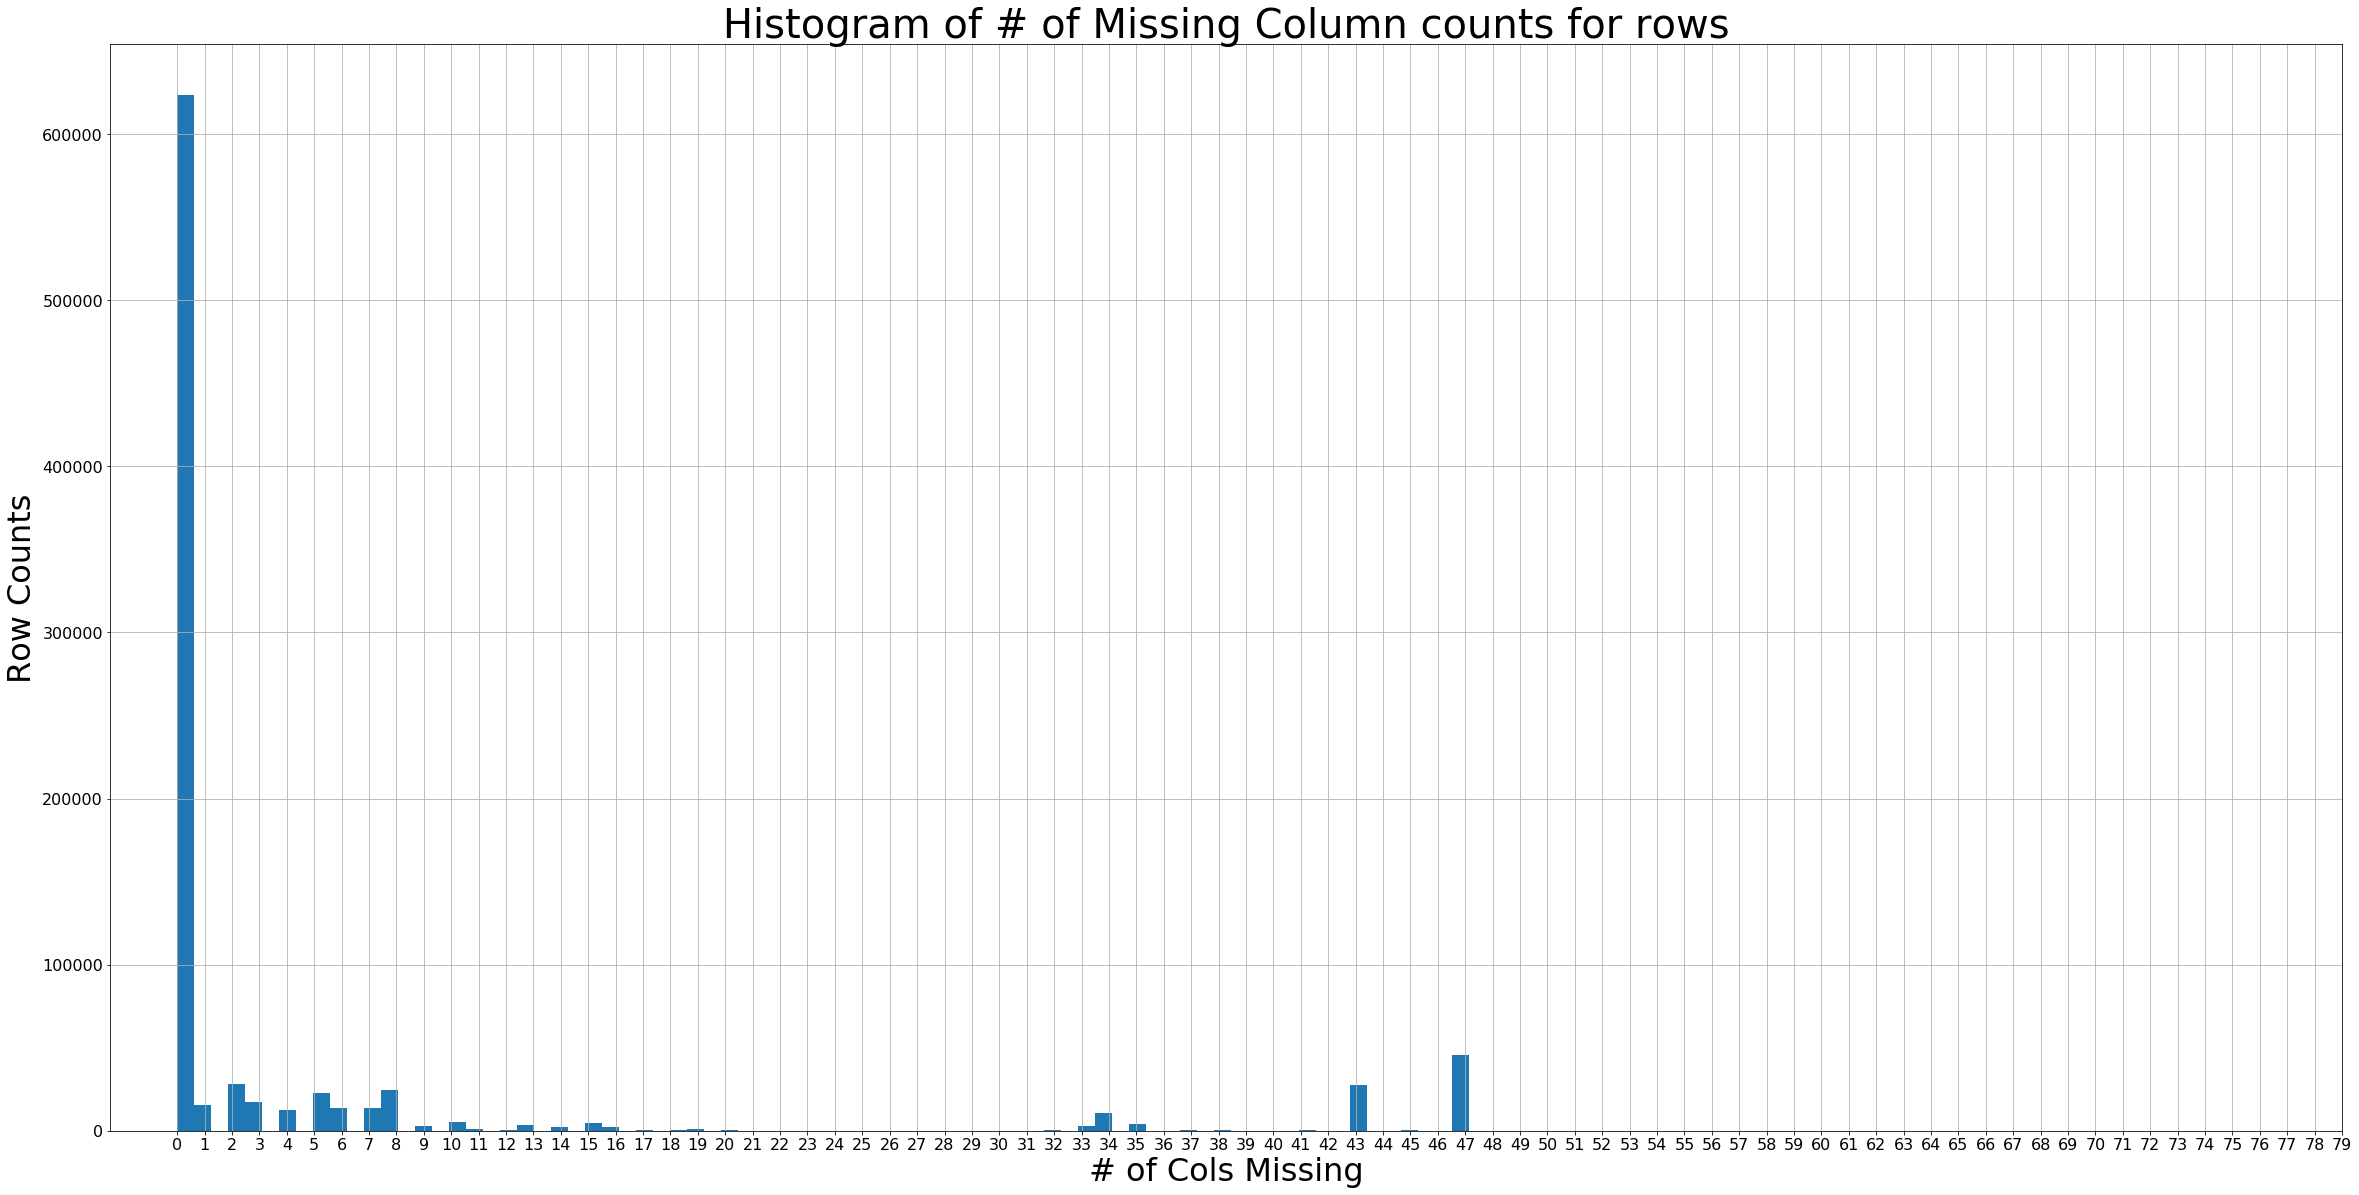

In [28]:
max_y = num_cols_missing.shape[0]
plt.figure(figsize=(40, 20))
plt.grid(axis='both')
#Increase labelsize
plt.tick_params(axis='both', which='major', labelsize=16)
# Proportion missing
plt.hist(num_cols_missing, bins=azdias_clean.shape[1])
# Place x ticks for every 10%
plt.xticks(list(range(0, azdias_clean.shape[1] + 1, 1)))
plt.xlabel('# of Cols Missing', fontsize=32)
plt.ylabel('Row Counts', fontsize=32)
plt.title('Histogram of # of Missing Column counts for rows', fontsize=40)
plt.show()

In [29]:
num_cols_missing[num_cols_missing == 0].shape[0]

623209

In [30]:
num_cols_missing[num_cols_missing == 0].shape[0] * 100 / azdias_clean.shape[0]

69.9275488346886

We see that if we throw away all rows that have atleast one column missing, then we will be left with 70% of the original data, but we won't have to perform any imputation. Let's try removing this first bin of zero cols missing, and zoom in on the other bins to see if we can find a sweet spot for where to fix the threshold for number of missing cols per row, that we can tolerate.

In [31]:
# Drop the first bin
num_cols_missing_atleast_one = num_cols_missing[num_cols_missing != 0]

In [32]:
def get_hist_weights(count_arr, total):
    '''
    Convert counts to weights to pass to pyplot.hist function
    
    INPUT:  count_arr - array of counts
            total - total count of all bins
            
    OUTPUT:
            weights array containing 1 / total for each position
    '''    
    return np.ones(len(count_arr))/ total

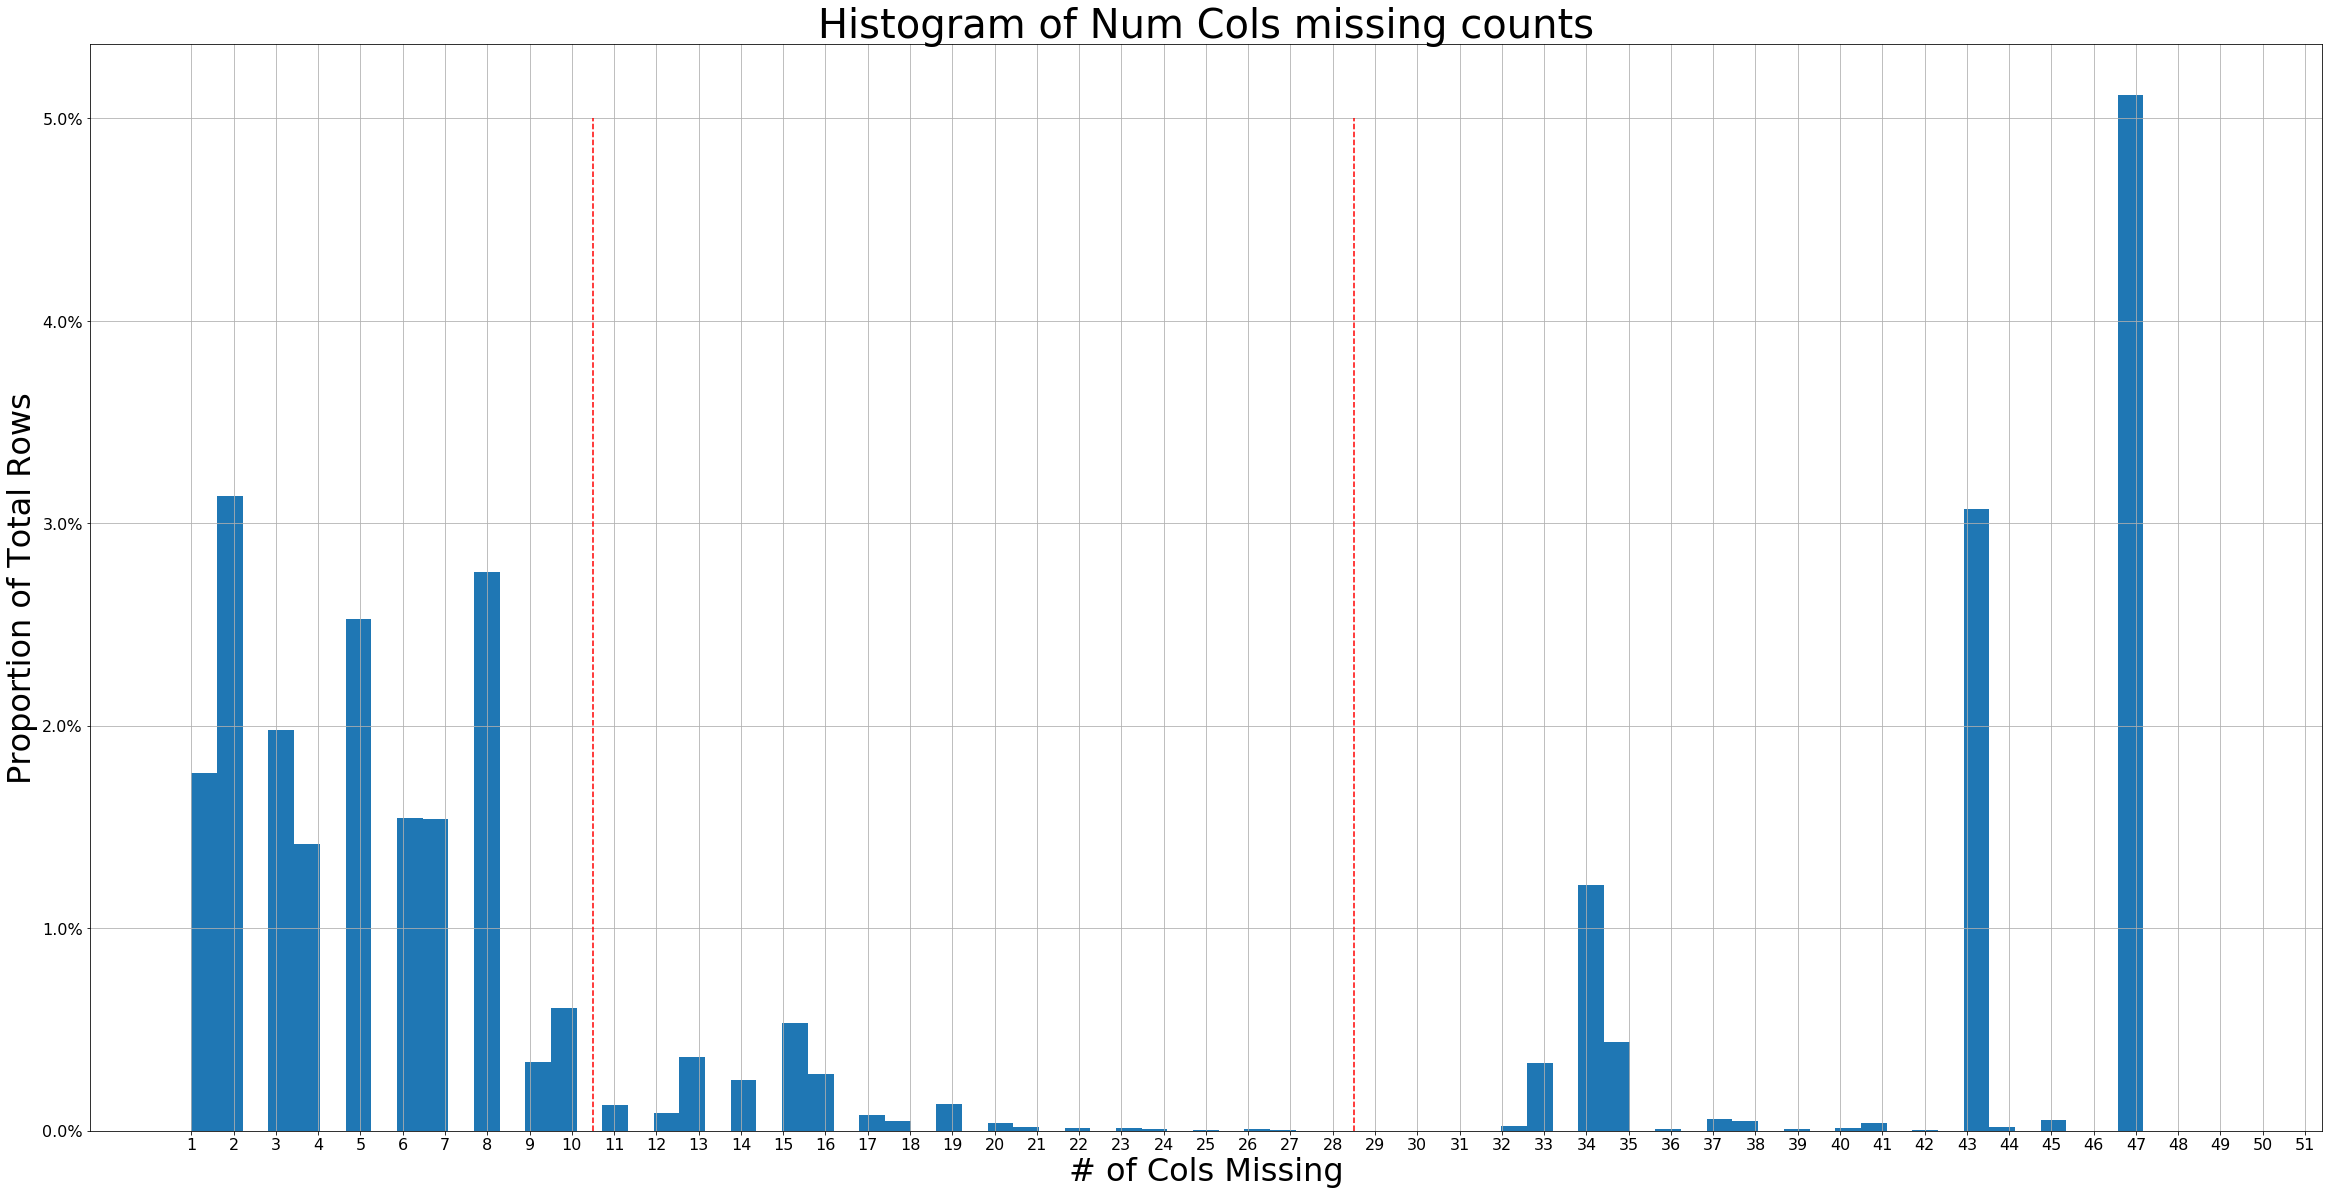

In [33]:
# Zoom in on the 30% of rows that are missing atleast one column
plt.figure(figsize=(40, 20))
plt.grid(axis='both')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#Increase labelsize
plt.tick_params(axis='both', which='major', labelsize=16)
# Proportion missing
weights = get_hist_weights(num_cols_missing_atleast_one, azdias_clean.shape[0])

plt.hist(num_cols_missing_atleast_one, bins=azdias_clean.shape[1], weights=weights)


# Place x ticks for every 10%
plt.xticks(list(range(1, azdias_clean.shape[1] + 1, 1)))
plt.xlabel('# of Cols Missing', fontsize=32)
plt.ylabel('Proportion of Total Rows', fontsize=32)
plt.title('Histogram of Num Cols missing counts', fontsize=40)
plt.vlines([10.5, 28.5], 0, 0.05, linestyles='dashed', color = 'red')
plt.show()

In [34]:
num_cols_missing[num_cols_missing <= 10].shape[0] * 100 / azdias_clean.shape[0]

87.53754680376697

Two of the candidate thresholds that might be of interest of number of cols missing <= 28 and number of cols missing <= 10. The first threshold is arrived at simply because it is in the middle of our distribution and seems to represent a logical split. We see that if we were to go with this threshold, we would be throwing away roughly 10% of the original data. Another likely candidate is at 10 columns beyond which the count drops for next few num cols. Retaining rows with 10 or less missing columns, we get to retain 87% of the data.

Now, for these two thresholds, let us compare the kept and discarded distributions for few of the columns with no data missing.

In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols_with_no_missing = [xlabels[i] for i, missing_pct in enumerate(proportion_missing) if missing_pct == 0]
cols_with_no_missing

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [36]:
# Select a subset from the above cols- picking to ensure one column of each type is present
cols_to_compare = ['ANREDE_KZ', 'FINANZ_VORSORGER', 'GREEN_AVANTGARDE', 'SEMIO_KULT', 'ZABEOTYP', 'HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET']

In [37]:
def plot_compare_splits(columns, split_threshold):
    '''
    Plot original distribution along with two subsets with number of columns missing > and <= threshold
    
    INPUT:  columns - columns to compare
            split_threshold - threshold for subsetting rows by number of missing columns
            
    OUTPUT:
            None
    '''
    #https://matplotlib.org/gallery/subplots_axes_and_figures/axes_margins.html#sphx-glr-gallery-subplots-axes-and-figures-axes-margins-py
    azdias_missing_less = azdias_clean[azdias_clean.isnull().sum(axis=1) <= split_threshold]
    azdias_missing_more = azdias_clean[azdias_clean.isnull().sum(axis=1) > split_threshold]
    for idx, col in enumerate(columns):
        print('\t%d) %s' %(idx+1, col))
        plt.figure(figsize=(20, 10))
        plt.subplot(212)
        sns.countplot(x=col, data=azdias_clean).set_title('Original distribution')

        plt.subplot(221)
        sns.countplot(x=col, data=azdias_missing_less).set_title('Distribution of Subset Missing <= {thres} columns'.format(thres=split_threshold))

        plt.subplot(222)
        sns.countplot(x=col, data=azdias_missing_more).set_title('Distribution of Subset Missing > {thres} columns'.format(thres=split_threshold))
        plt.show()
        print('\n\n')

Let's first plot the scenario where we would tolerate no missing data at all, i.e our threshold for retention is 0 cols missing.

	1) ANREDE_KZ


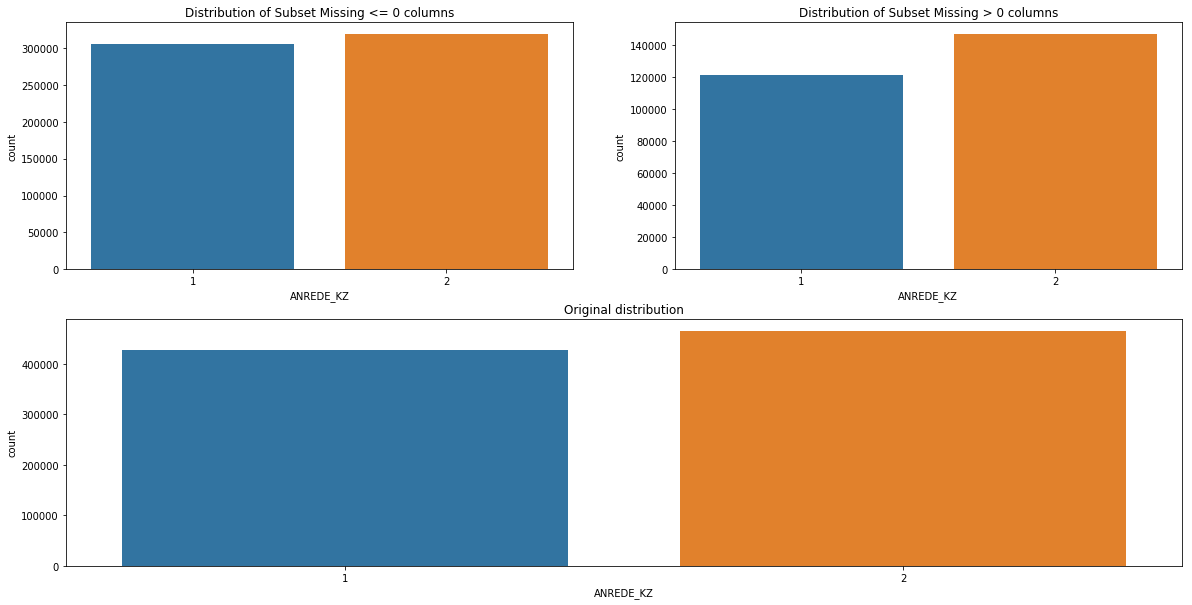




	2) FINANZ_VORSORGER


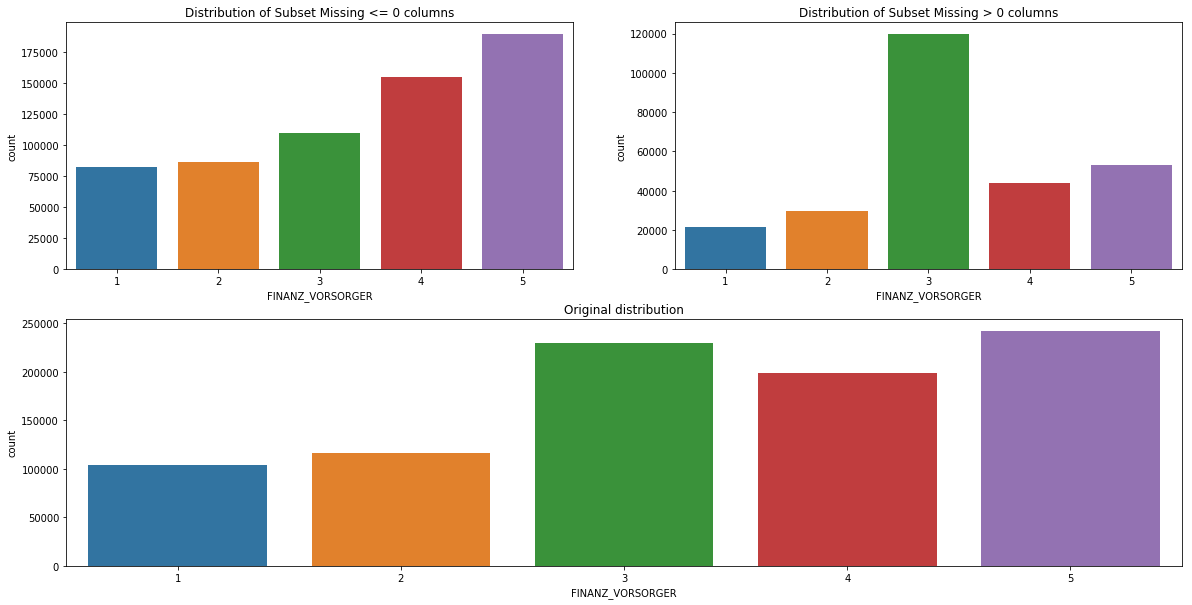




	3) GREEN_AVANTGARDE


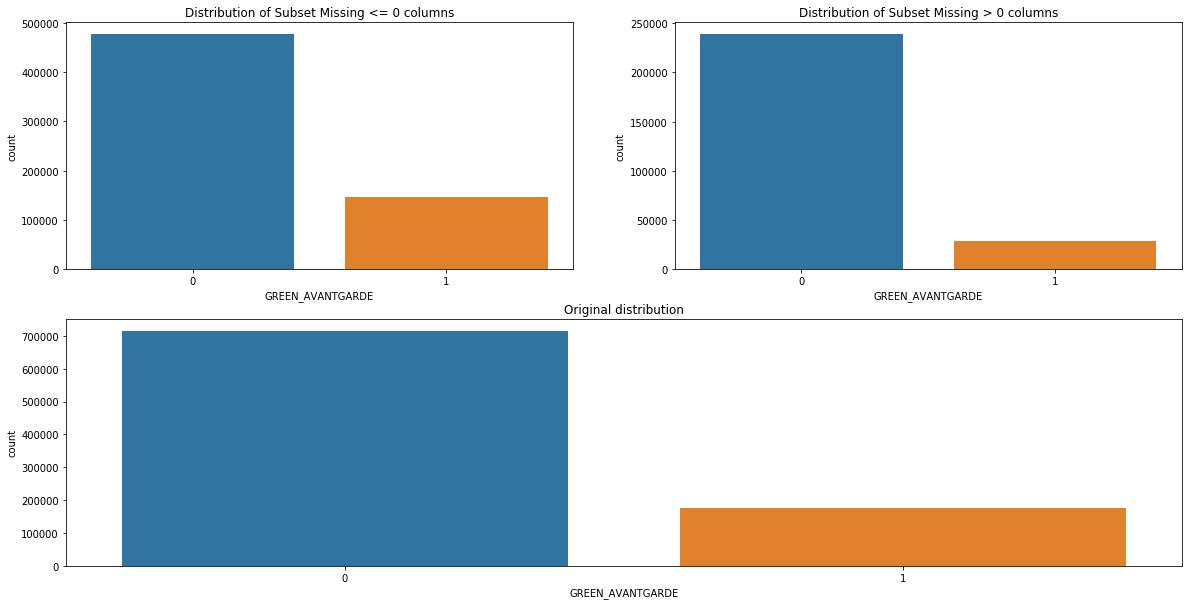




	4) SEMIO_KULT


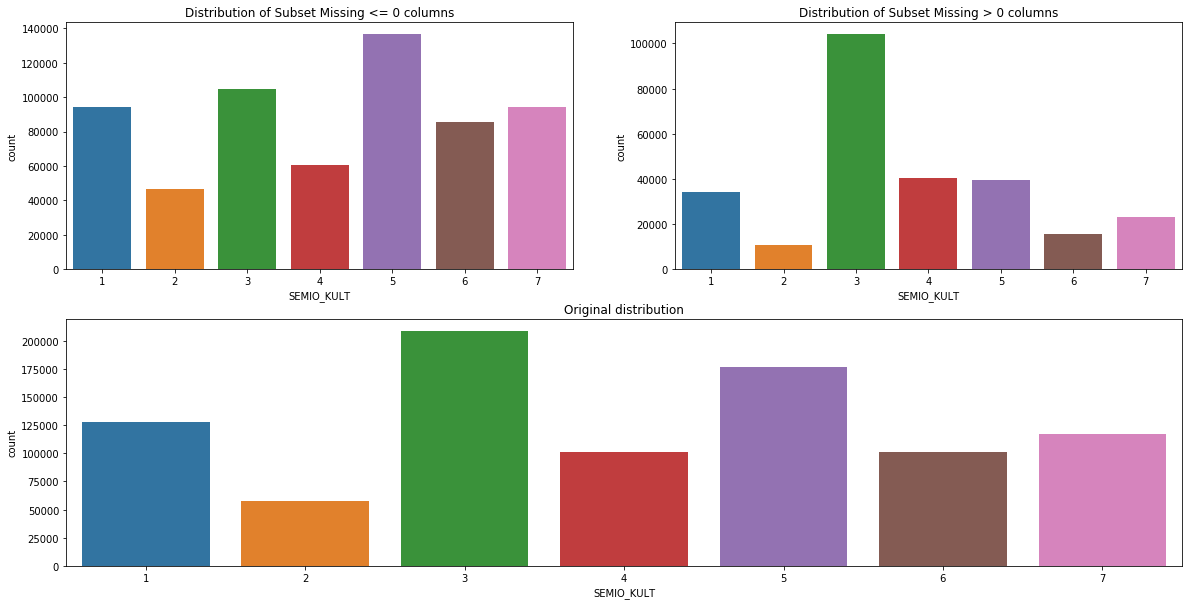




	5) ZABEOTYP


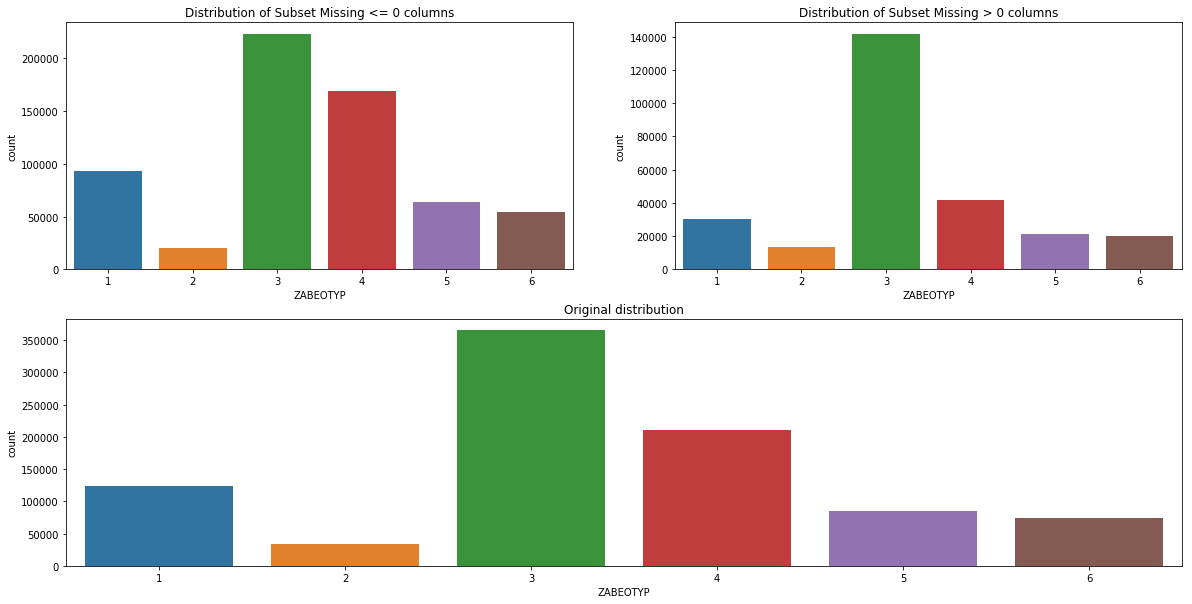




	6) HH_EINKOMMEN_SCORE


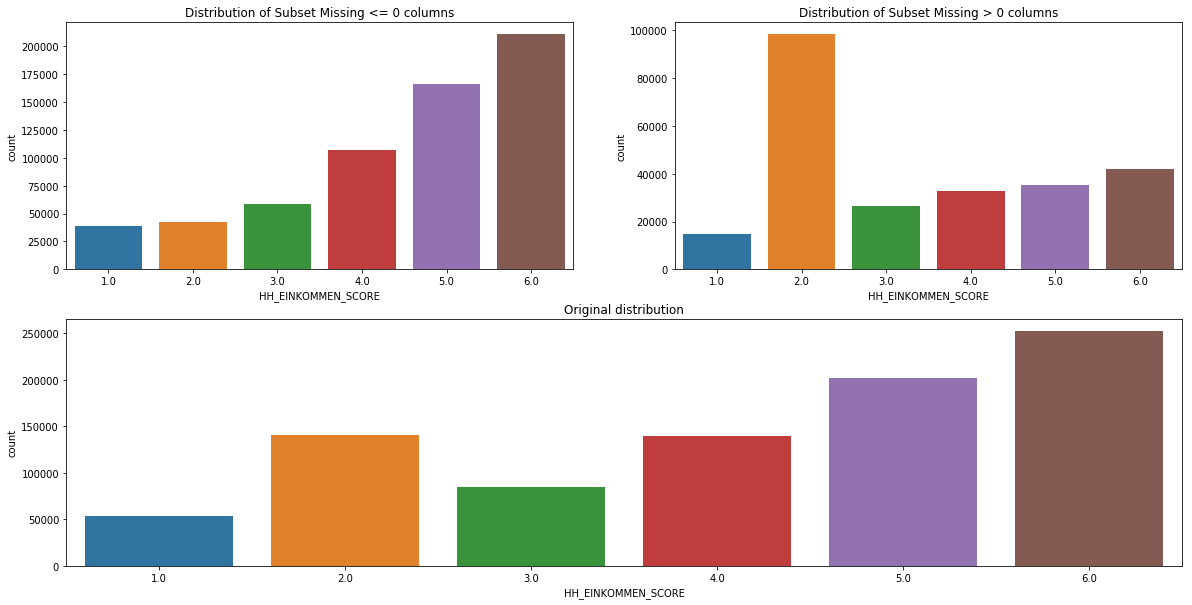




	7) ONLINE_AFFINITAET


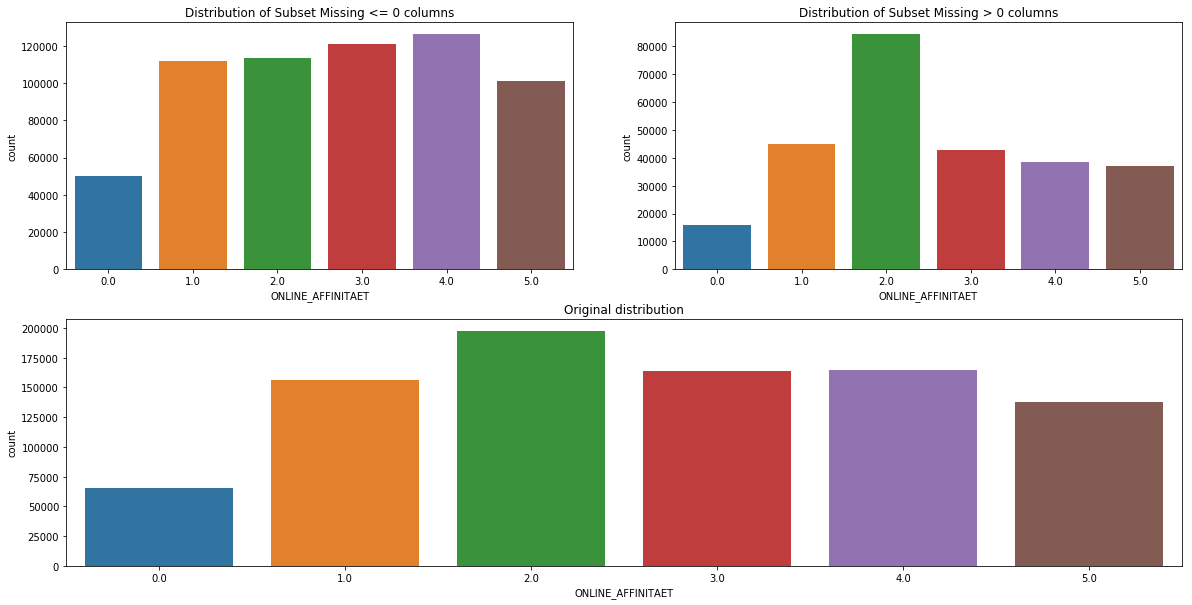

In [38]:
plot_compare_splits(cols_to_compare, 0)

We can clearly see that throwing away 30% of the data, causes the distribution of kept data to be quite differnt from the retained data, or atleast exaggerates the relative difference across categories.

Now's lets try our first threshold of 28.

	1) ANREDE_KZ


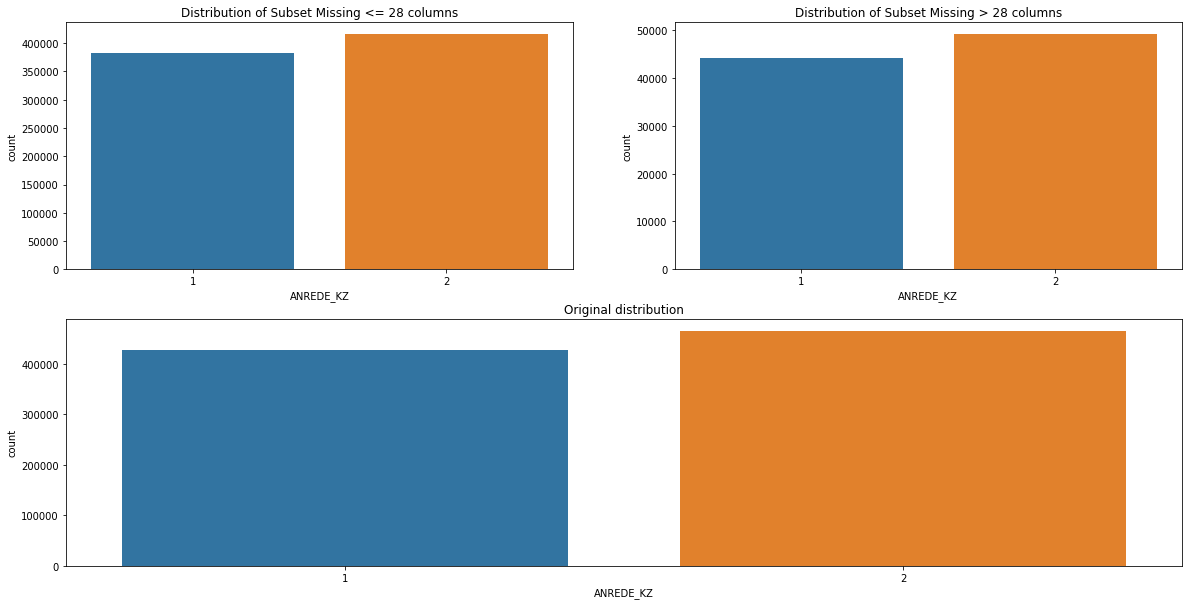




	2) FINANZ_VORSORGER


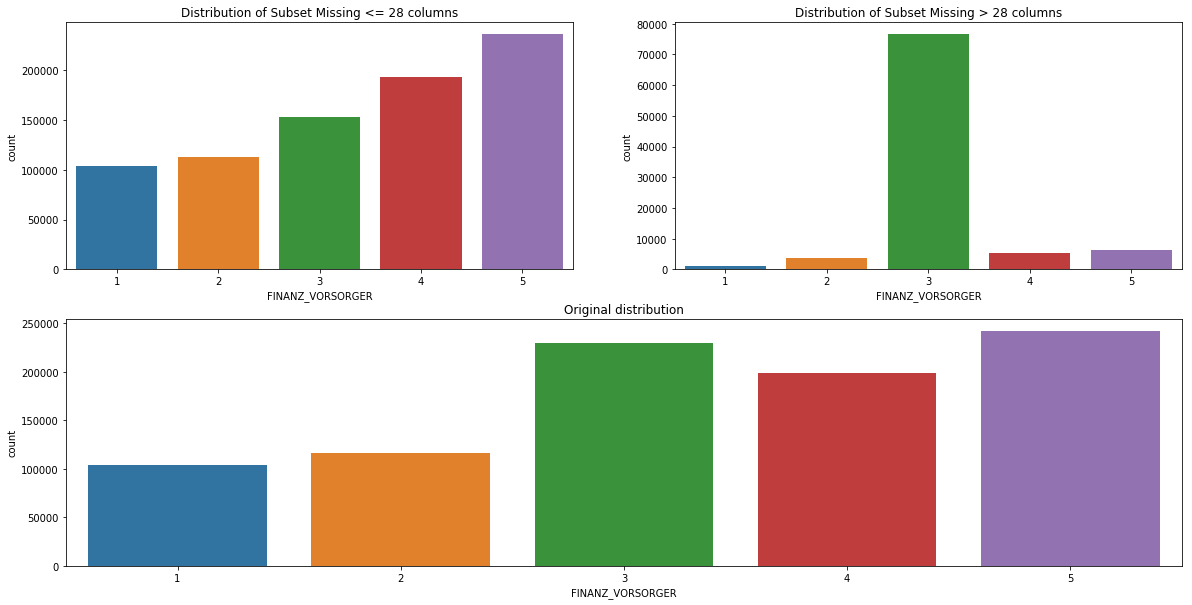




	3) GREEN_AVANTGARDE


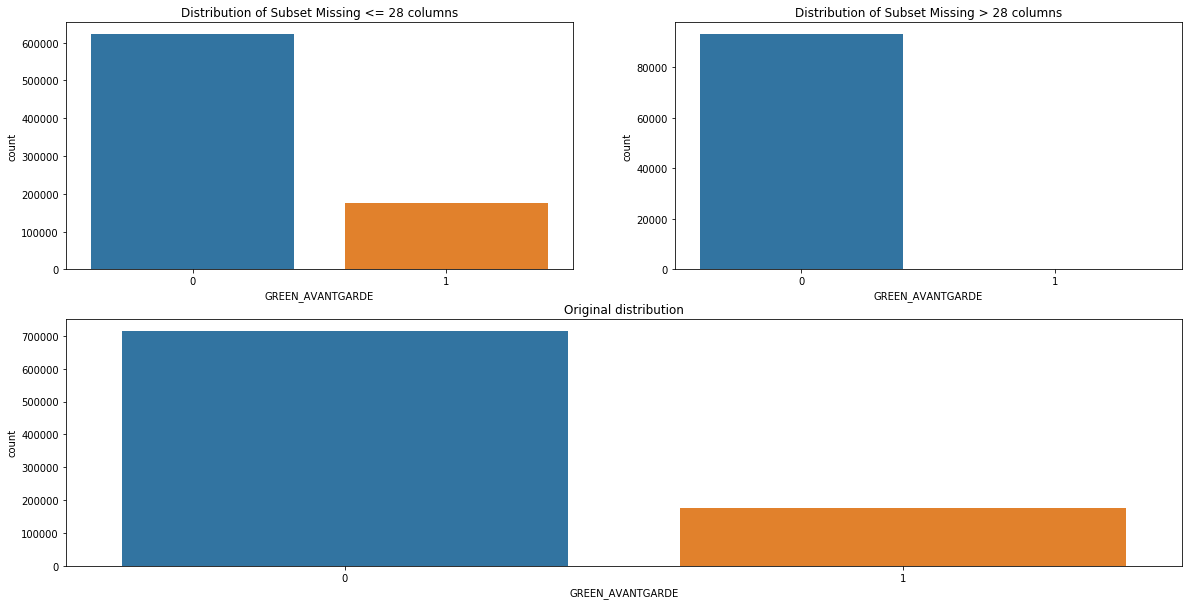




	4) SEMIO_KULT


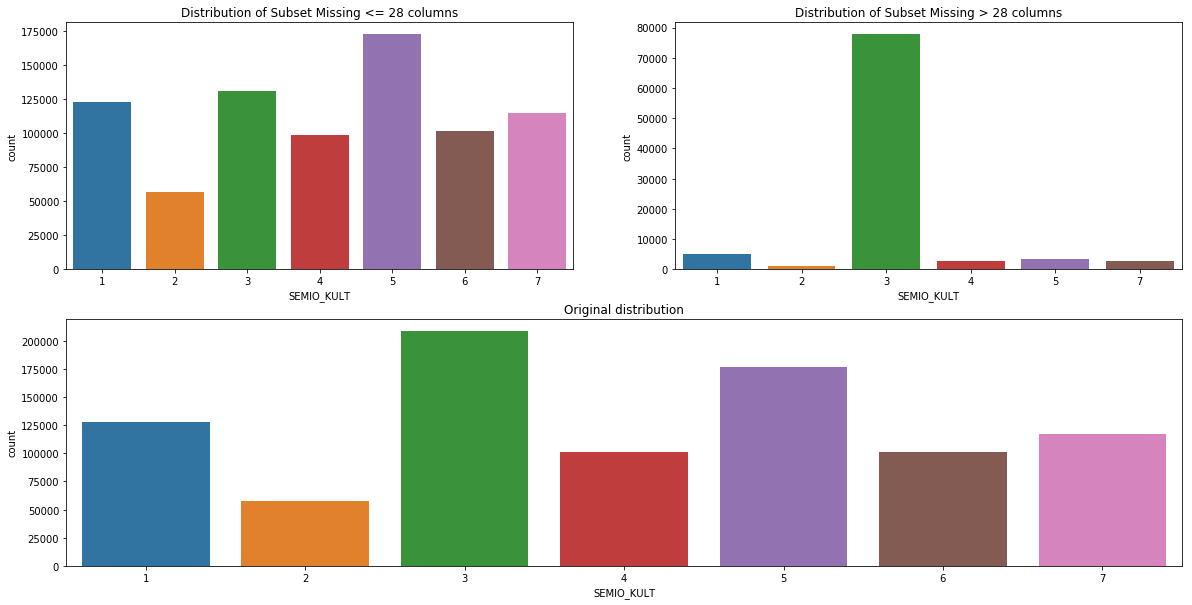




	5) ZABEOTYP


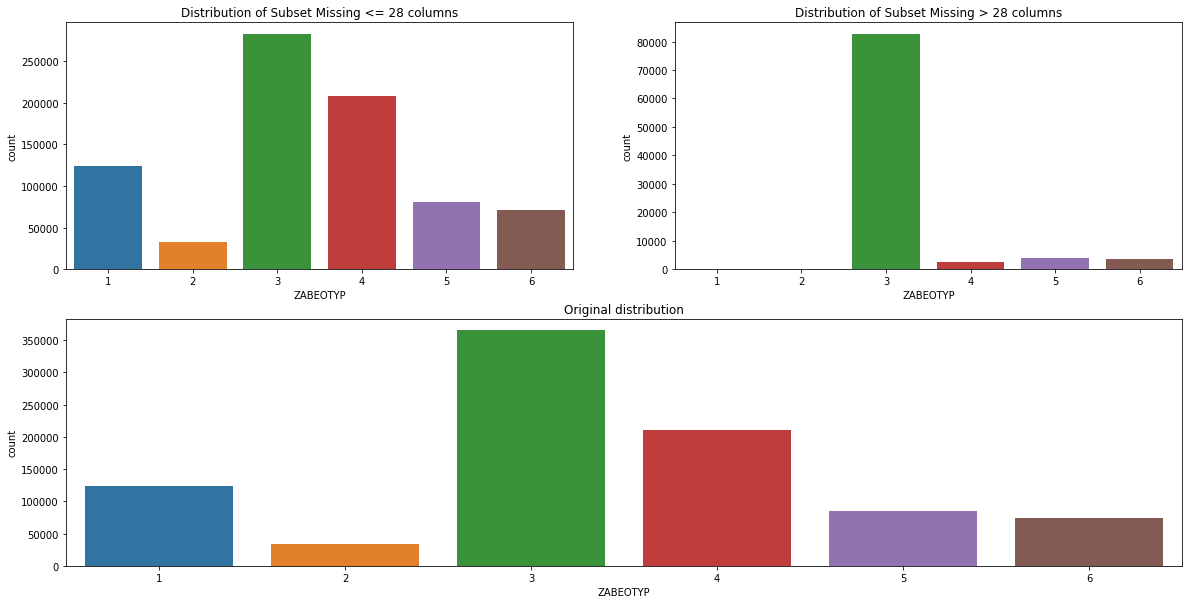




	6) HH_EINKOMMEN_SCORE


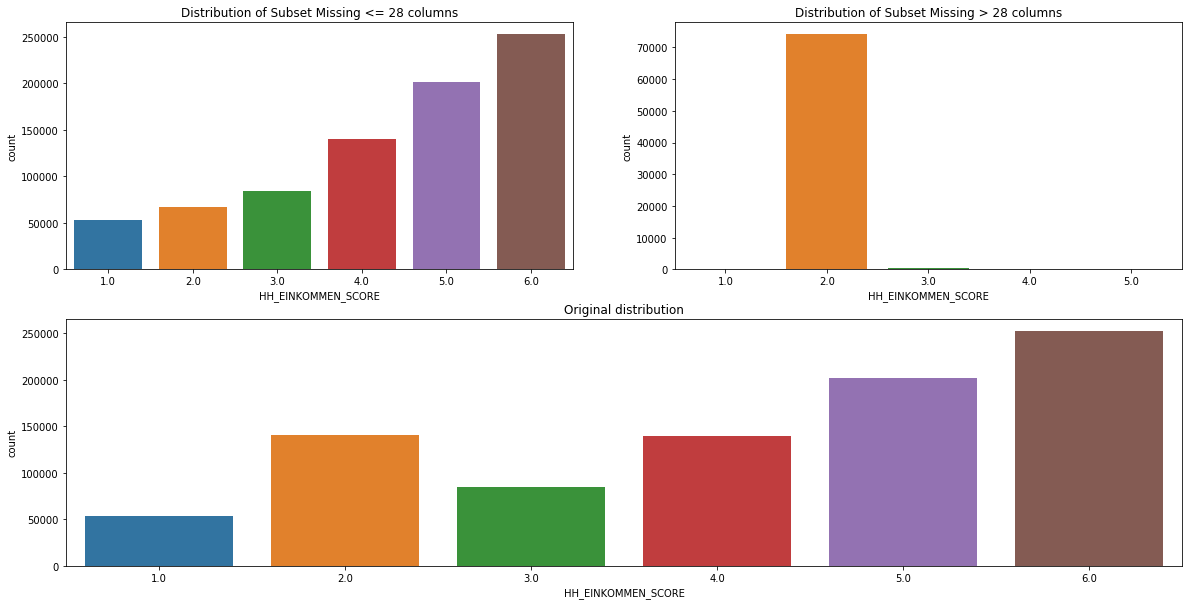




	7) ONLINE_AFFINITAET


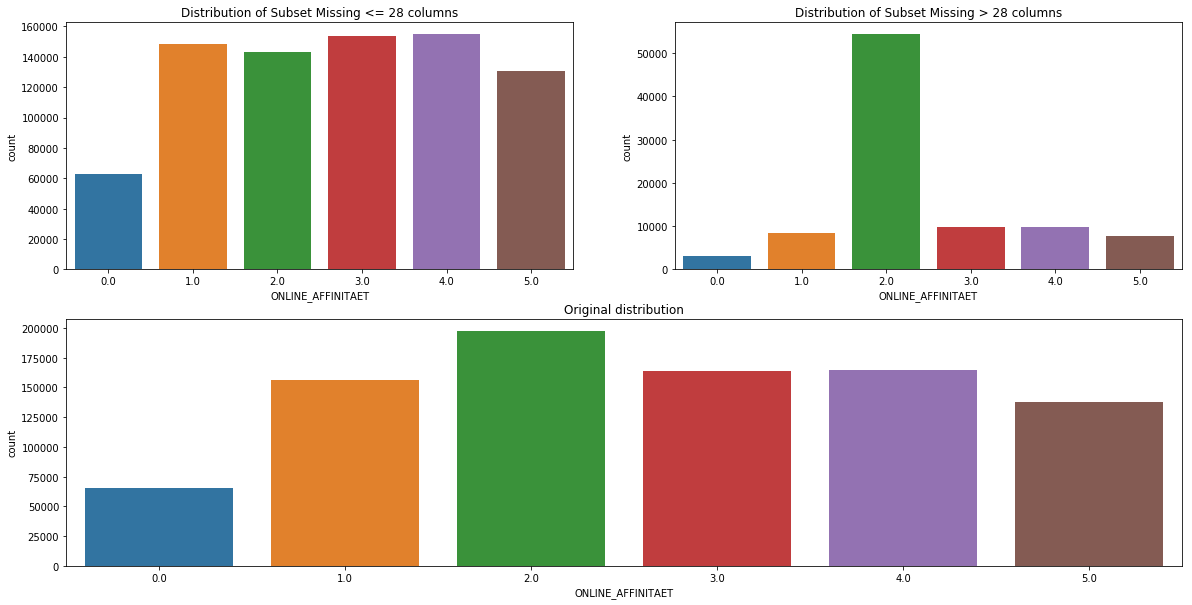

In [39]:
plot_compare_splits(cols_to_compare, 28)

For our first threshold as well, the distributions are quite different, with ANDREDE_KZ being the only one in which the trend roughly matches.

	1) ANREDE_KZ


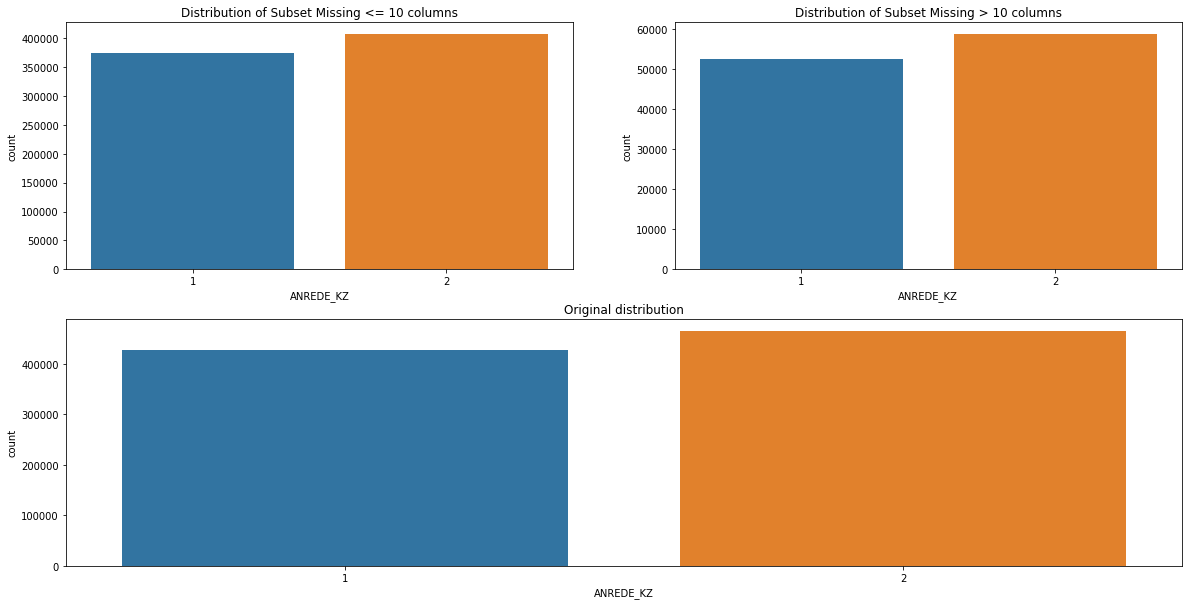




	2) FINANZ_VORSORGER


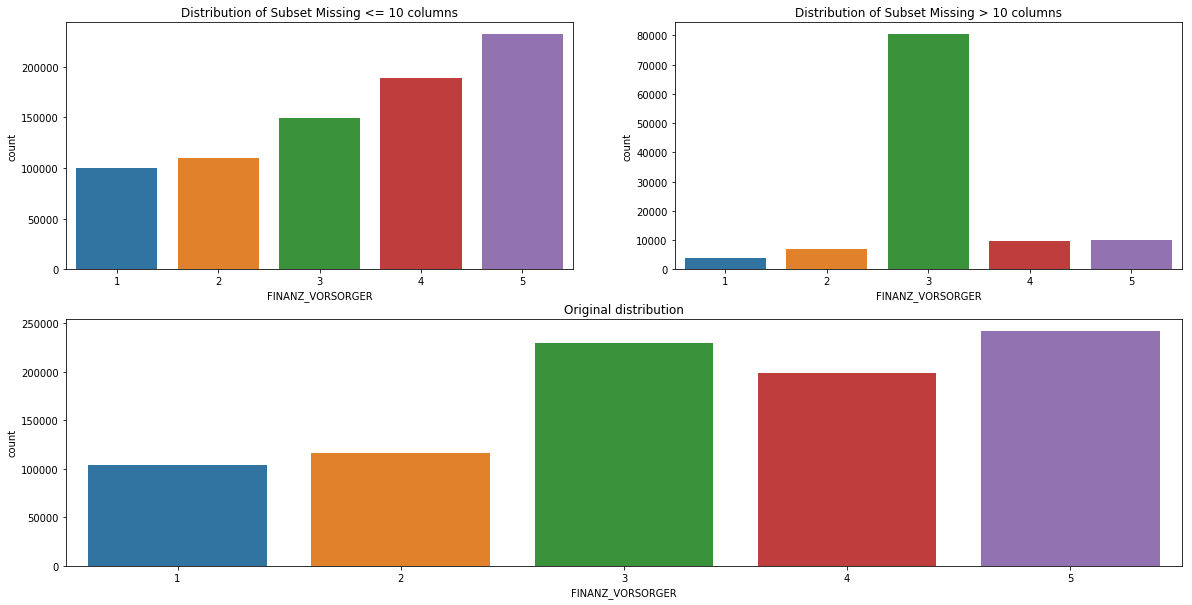




	3) GREEN_AVANTGARDE


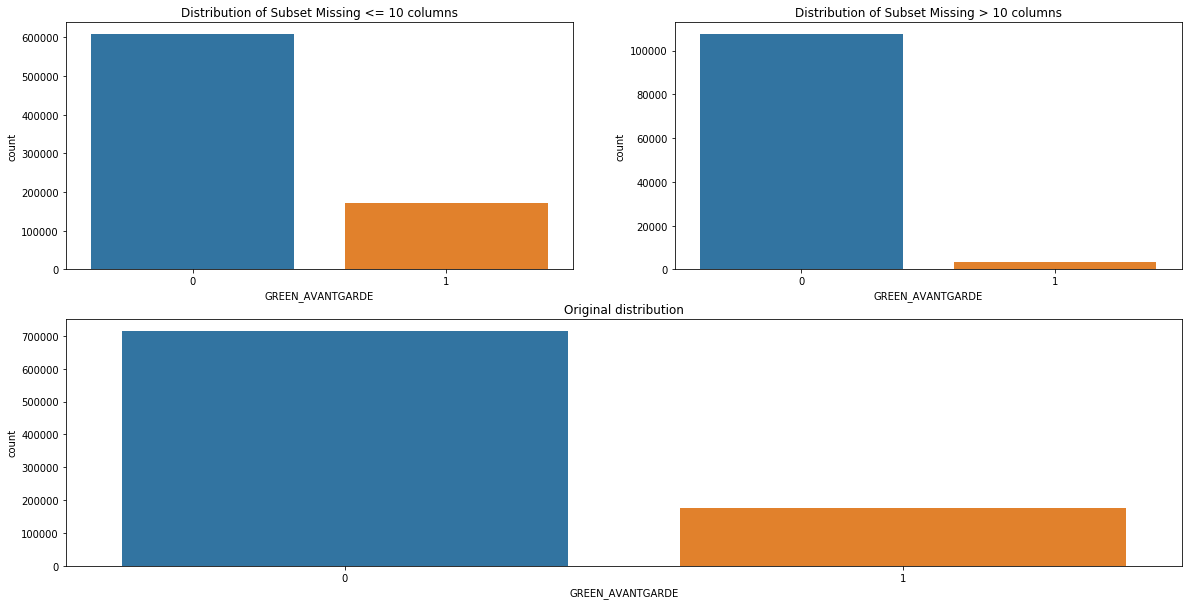




	4) SEMIO_KULT


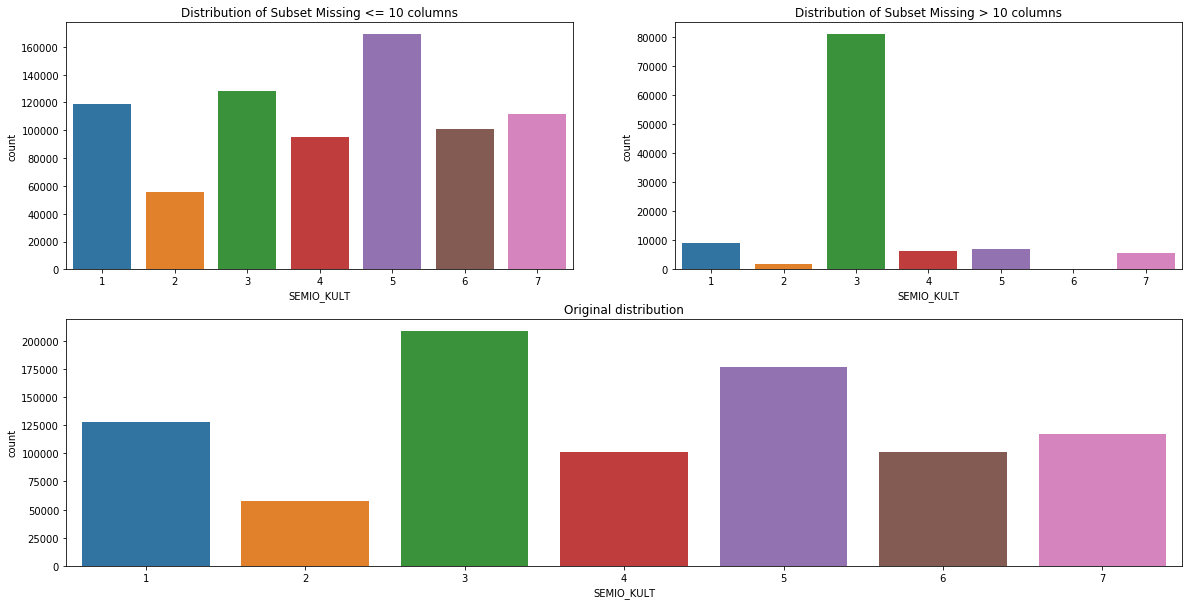




	5) ZABEOTYP


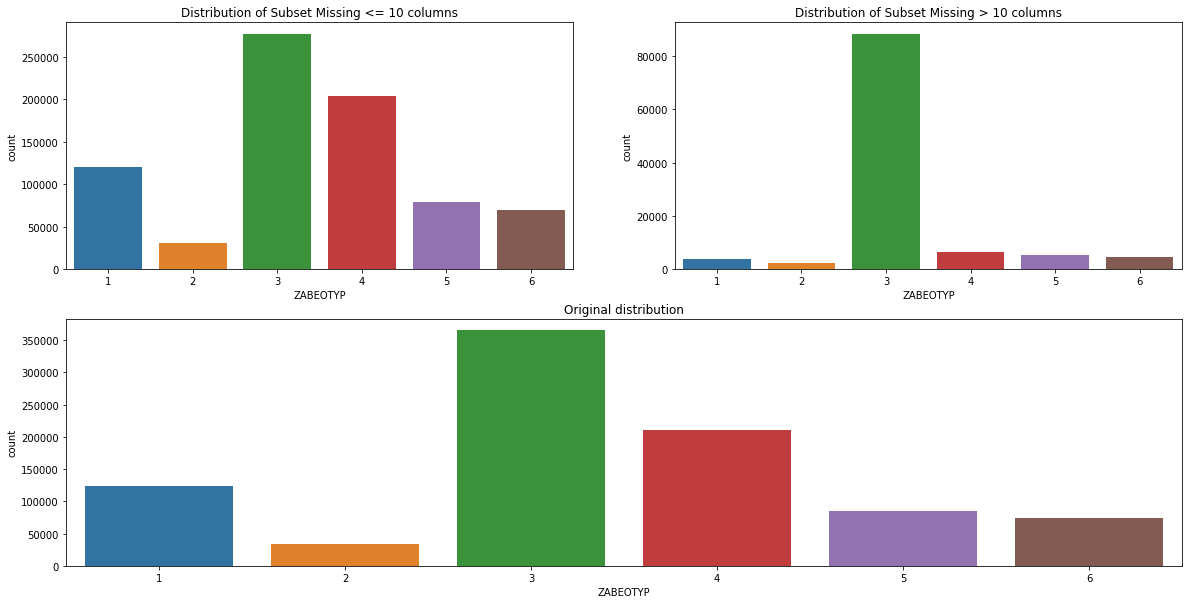




	6) HH_EINKOMMEN_SCORE


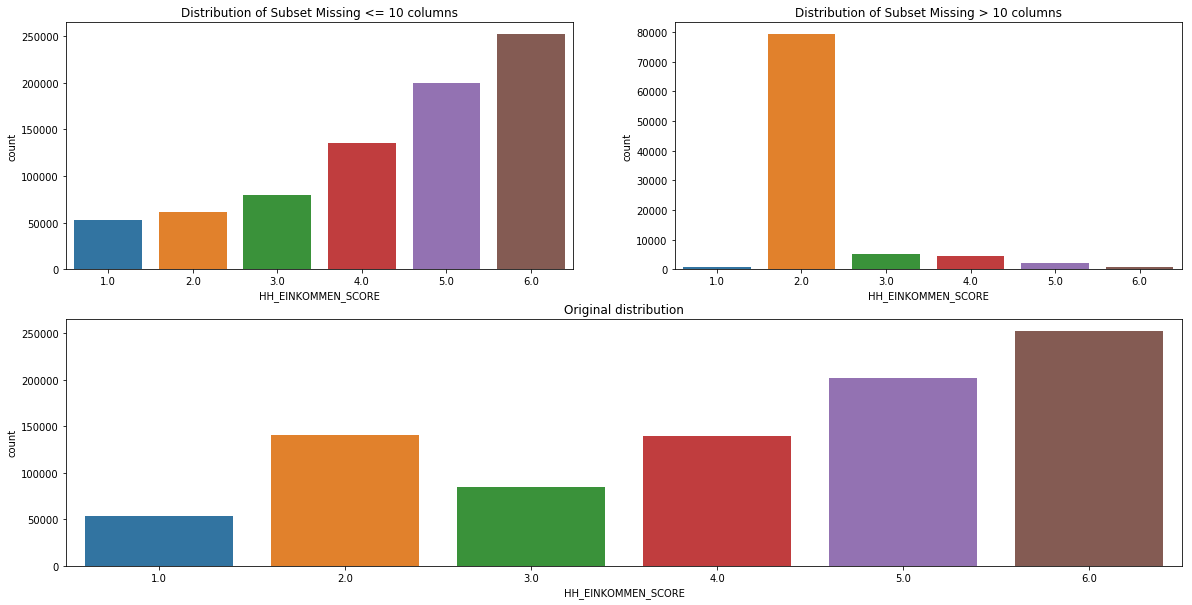




	7) ONLINE_AFFINITAET


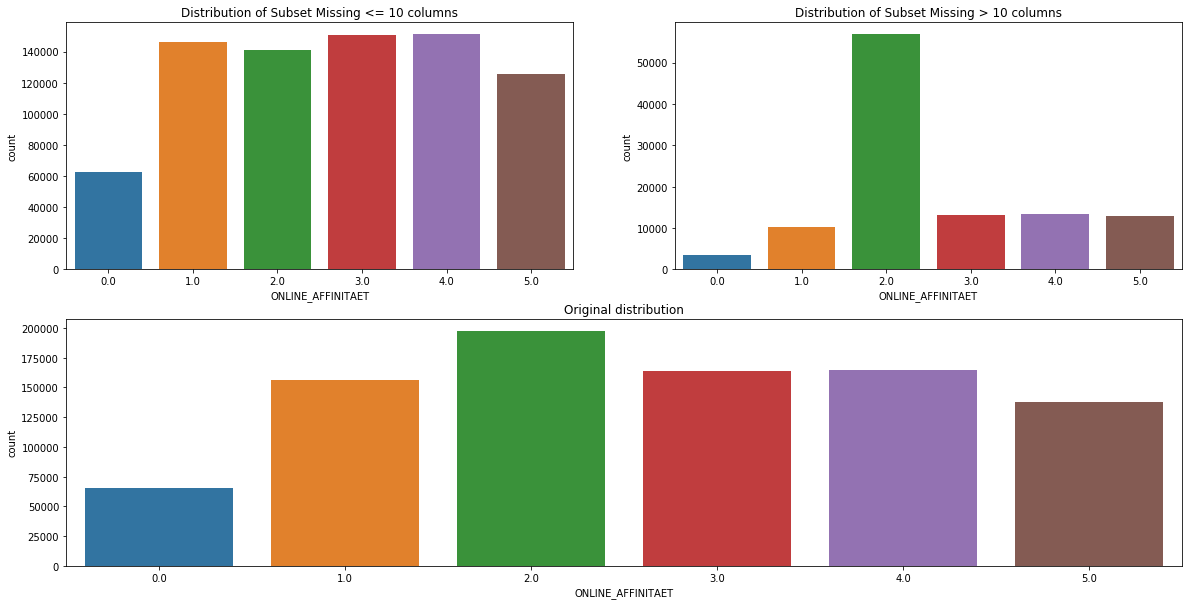

In [40]:
# Threshold number 2
plot_compare_splits(cols_to_compare, 10)

`ANREDE_KZ` and `GREEN_AVANGARDE` seem to match across the two datasets in terms of relative trends. What's interesting though is that for several of the columns, such as `ZABEO_TYP` and `HH_EINKOMMEN_SCORE` the kept distribution matches the original distribution if not the discarded distribution. Since these columns were originally missing no or very few rows, we can make the interpretation that throwing away 12% of the data doesn't unduly affect the kept distribution. So, we will fix our threshold at 10 columns. This threshold was also arrived at by revising in subsequent steps where to keep the number of imputed values reasonable.

In [41]:
# Subset on split threshold
split_threshold = 10
azdias_missing_less = azdias_clean[azdias_clean.isnull().sum(axis=1) <= split_threshold].copy()
azdias_missing_more = azdias_clean[azdias_clean.isnull().sum(axis=1) > split_threshold].copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data with lots of missing rows, appears to be different from the data with few missing rows, for some of the columns. In particular the subset with average `FINANZ_VORSOGER` typology or the "be prepared" financial type seems to be missing many columns since this value of 3.0 for `FINANZ_VORSOGER` is exaggerated in the discarded distribution.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [42]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [43]:
def print_unique(cols, df):
    '''
    Print unique counts for these cols in dataframe
    
    INPUT:  cols- columsn to print for
            df- reference dataframe
            
    OUTPUT:
            None
    '''
    [print("{}: {}".format(x, df[x].unique())) for x in cols];    

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_cols = feat_info_clean[feat_info_clean.type == 'categorical'].index.values
# Check num levels = 2 and that it is numeric dtype
binary_numeric_categorical_cols = [x for x in categorical_cols if azdias_missing_less[x].nunique() == 2 and azdias_missing_less[x].dtype != 'object']
print_unique(binary_numeric_categorical_cols, azdias_missing_less)

ANREDE_KZ: [2 1]
GREEN_AVANTGARDE: [0 1]
SOHO_KZ: [1. 0.]
VERS_TYP: [ 2.  1. nan]


In [45]:
# Check if num levels = 2 and it is of object dtype
binary_nonnumeric_categorical_cols = [x for x in categorical_cols if azdias_missing_less[x].nunique() == 2 and azdias_missing_less[x].dtype == 'object']
print_unique(binary_nonnumeric_categorical_cols, azdias_missing_less)

OST_WEST_KZ: ['W' 'O']


In [46]:
multilevel_categorical_cols = [x for x in categorical_cols if azdias_missing_less[x].nunique() > 2]
print_unique(multilevel_categorical_cols, azdias_missing_less)

CJT_GESAMTTYP: [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP: [1 6 5 2 4 3]
GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
LP_FAMILIE_FEIN: [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB: [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB: [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ: [ 1.  3.  2. nan]
SHOPPER_TYP: [ 3.  2.  1.  0. nan]
ZABEOTYP: [5 3 4 1 6 2]
GEBAEUDETYP: [8. 1. 3. 2. 6. 4. 5.]
CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [47]:
# Check success of splitting categorical cols
assert(len(categorical_cols) == len(binary_numeric_categorical_cols) + len(binary_nonnumeric_categorical_cols) + len(multilevel_categorical_cols))

In [48]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_missing_less.OST_WEST_KZ = azdias_missing_less.OST_WEST_KZ.map({'O': 0, 'W':  1})

Now, let's look up the multilevel categorical variables in the data dictionary to see if any of them can be dropped. Particularly, it would be helpful to be able to drop columns such as `CAMEO_DEU_2015` that have large number of levels, before we one-hot encode the variables, to avoid a dummies sprawl.

`FINANZTYP` can be dropped as the same information is captured by the numerical variables `FINANZ_MINIMALIST` etc.

For `LP_FAMILIE` and `LP_STATUS`, the `GROB` is redundant since the corresponding `FEIN` columns capture the same information and each of the `FEIN` is close to 10 levels. So, we will drop the `GROB` versions for these two.

Finally, we see `CAMEO_DEU_2015` is a fine grained split of `CAMEO_DEUG_2015`, which is a classification based on wealth/life stage.
For the goal of finding customer segments, such fine-grained split is an overkill, so we will retain only `CAMEO_DEUG_2015` and drop `CAMEO_DEU_2015`.

In [49]:
multilevel_cols_to_drop = ['FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEU_2015']

In [50]:
azdias_missing_less, feat_info_clean = drop_attrs(azdias_missing_less, feat_info_clean, multilevel_cols_to_drop)

For the remaining multi-level variables, we will do one-hot encoding.

In [51]:
multilevel_cols = [x for x in multilevel_categorical_cols if x not in multilevel_cols_to_drop]
multilevel_cols

['CJT_GESAMTTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [52]:
azdias_missing_less = pd.get_dummies(azdias_missing_less, columns = multilevel_cols, prefix = multilevel_cols)

#### Discussion 1.2.1: Re-Encode Categorical Features

We primarly dropped mnultilevel categorical cols that seemed to have similar information captured in other columns and were therefore redundant. This way, we avoid a sprawl of dummy columns that don't provide additional info for classification. The colums we dropped include  ['FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEU_2015']. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [53]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_missing_less.PRAEGENDE_JUGENDJAHRE.isnull().sum()

26474

In [54]:
azdias_missing_less.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    178410
8.0     138678
10.0     83881
5.0      83645
3.0      53098
15.0     41029
11.0     34642
9.0      33197
6.0      25517
12.0     24034
4.0      20343
1.0      20242
2.0       7438
13.0      5561
7.0       3964
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [55]:
def extract_decade(p_j_x):
    '''
    Helper function to extract decade from PRAEGENDE_JUGENDJAHRE
    
    INPUT:  p_j_x - One cell in our pandas series
            
    OUTPUT:
            One cell of new series to be returned
    '''
    if p_j_x in range(1, 3):
        return 1 # 40s
    elif p_j_x in range(3, 5):
        return 2 # 50s
    elif p_j_x in range(5, 8):
        return 3 # 60s
    elif p_j_x in range(8, 10):
        return 4 # 70s
    elif p_j_x in range(10, 14):
        return 5 # 80s
    elif p_j_x in range(14, 16):
        return 6 # 90s
    else:
        return np.nan # To be handled during imputation in later steps

In [56]:
def extract_movement(p_j_x):
    '''
    Helper function to extract decade from PRAEGENDE_JUGENDJAHRE
    
    INPUT:  p_j_x - One cell in our pandas series
            
    OUTPUT:
            One cell of new series to be returned
    '''
    mainstream_set = set([1, 3, 5, 8, 10, 12, 14])
    avantgarde_set = set([2, 4, 6, 7, 9, 11, 13, 15])
    if p_j_x in mainstream_set:
        return 0 
    elif p_j_x in avantgarde_set:
        return 1
    else:
        return np.nan

In [57]:
azdias_missing_less['P_J_DECADE'] = azdias_missing_less.PRAEGENDE_JUGENDJAHRE.apply(extract_decade)
azdias_missing_less['P_J_MOVEMENT'] = azdias_missing_less.PRAEGENDE_JUGENDJAHRE.apply(extract_movement)

In [58]:
azdias_missing_less.P_J_DECADE.value_counts()

6.0    219439
4.0    171875
5.0    148118
3.0    113126
2.0     73441
1.0     27680
Name: P_J_DECADE, dtype: int64

In [59]:
azdias_missing_less.P_J_MOVEMENT.value_counts()

0.0    581988
1.0    171691
Name: P_J_MOVEMENT, dtype: int64

In [60]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_missing_less.CAMEO_INTL_2015.isnull().sum()

3656

In [61]:
type(azdias_missing_less.CAMEO_INTL_2015.iloc[0])

str

In [62]:
def extract_weath(c_i_x): #Pun intended
    '''
    Helper function to extract wealth info from CAMEO_INTL_2015
    
    INPUT:  c_i_x - One cell in our pandas series
            
    OUTPUT:
            One cell of new series to be returned
    '''
    if not isinstance(c_i_x, str):
        return np.nan
    else:
        return int(int(c_i_x) / 10)

In [63]:
def extract_lifestage(c_i_x):
    '''
    Helper function to extract lifestage info from CAMEO_INTL_2015
    
    INPUT:  c_i_x - One cell in our pandas series
            
    OUTPUT:
            One cell of new series to be returned
    '''
    if not isinstance(c_i_x, str):
        return np.nan
    else:
        return int(c_i_x) % 10

In [64]:
azdias_missing_less['C_I_WEALTH'] = azdias_missing_less.CAMEO_INTL_2015.apply(extract_weath)
azdias_missing_less['C_I_LIFESTAGE'] = azdias_missing_less.CAMEO_INTL_2015.apply(extract_lifestage)

In [65]:
azdias_missing_less[['CAMEO_INTL_2015', 'C_I_WEALTH', 'C_I_LIFESTAGE']].sample(10)

,CAMEO_INTL_2015,C_I_WEALTH,C_I_LIFESTAGE
156991,24,2.0,4.0
887855,15,1.0,5.0
41719,51,5.0,1.0
108512,41,4.0,1.0
708350,51,5.0,1.0
574857,43,4.0,3.0
522513,45,4.0,5.0
465581,13,1.0,3.0
70161,45,4.0,5.0
881884,45,4.0,5.0


In [66]:
mixed = feat_info_clean.query('type == "mixed"').index.tolist()
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [67]:
# Drop all mixed
azdias_missing_less, feat_info_clean = drop_attrs(azdias_missing_less, feat_info_clean, mixed)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We dropp all mixed features as they are not useful unless handled. We have handled two of the mixed features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 and extracted features of interest from them.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [68]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_missing_less.dtypes.value_counts()


uint8      68
float64    41
int64      23
dtype: int64

In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [70]:
def reengineer_features(df, feat_dict):
    """
    Perform reengineering of features 
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame, feature dictionary
    """
    # select, re-encode, and engineer column values.
    # map categorical to numeric
    df.OST_WEST_KZ = df.OST_WEST_KZ.map({'O': 0, 'W':  1})
    # drop multilevel that's not as relevant - keep this step here rather than merge with previous drop since
    # MAX_MISSING_COl was determined with these columns in place
    cols_to_remove = ['FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEU_2015']
    df, feat_dict = drop_attrs(df, feat_dict, cols_to_remove)
    multilevel_cols= ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ',
                     'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
    df = pd.get_dummies(df, columns = multilevel_cols, prefix = multilevel_cols)
    # Engineer mixed type features
    df['P_J_DECADE'] = df.PRAEGENDE_JUGENDJAHRE.apply(extract_decade)
    df['P_J_MOVEMENT'] = df.PRAEGENDE_JUGENDJAHRE.apply(extract_movement)
    df['C_I_WEALTH'] = df.CAMEO_INTL_2015.apply(extract_weath)
    df['C_I_LIFESTAGE'] = df.CAMEO_INTL_2015.apply(extract_lifestage)
    # Drop all mixed type after engineering new features from them
    cols_to_remove = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 
     'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    return drop_attrs(df, feat_dict, cols_to_remove)

In [71]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame, discarded dataframe and feature dictionary
    """
    feat_dict = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_dict.set_index('attribute', inplace=True)
    feat_dict.missing_or_unknown = feat_dict.missing_or_unknown.str.strip('[]').str.split(',')
    
    MAX_MISSING_COLS = 10
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = replace_code_with_nan(df, feat_dict)
    
    # remove selected columns and rows, ...
    cols_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df, feat_dict = drop_attrs(df, feat_dict, cols_to_remove)
    df_retained = df[df.isnull().sum(axis=1) <= MAX_MISSING_COLS].copy()
    df_discarded = df[df.isnull().sum(axis=1) > MAX_MISSING_COLS].copy()    
    feat_dict_discarded = feat_dict.copy()
    df, feat_dict = reengineer_features(df_retained, feat_dict)
    df_discarded, feat_dict_discarded = reengineer_features(df_discarded, feat_dict_discarded)    
    return df, df_discarded
    

Let's validate this by taking our original azdias dataframe and cleaning it using the function and comparing with the manually cleaned azdias dataframe.

In [72]:
azdias.equals(azdias_missing_less)

False

In [73]:
feat_info.equals(feat_info_clean)

False

In [74]:
azdias, azdias_discarded = clean_data(azdias) # , azdias_discarded, feat_info = clean_data(azdias)

In [75]:
azdias.equals(azdias_missing_less)

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

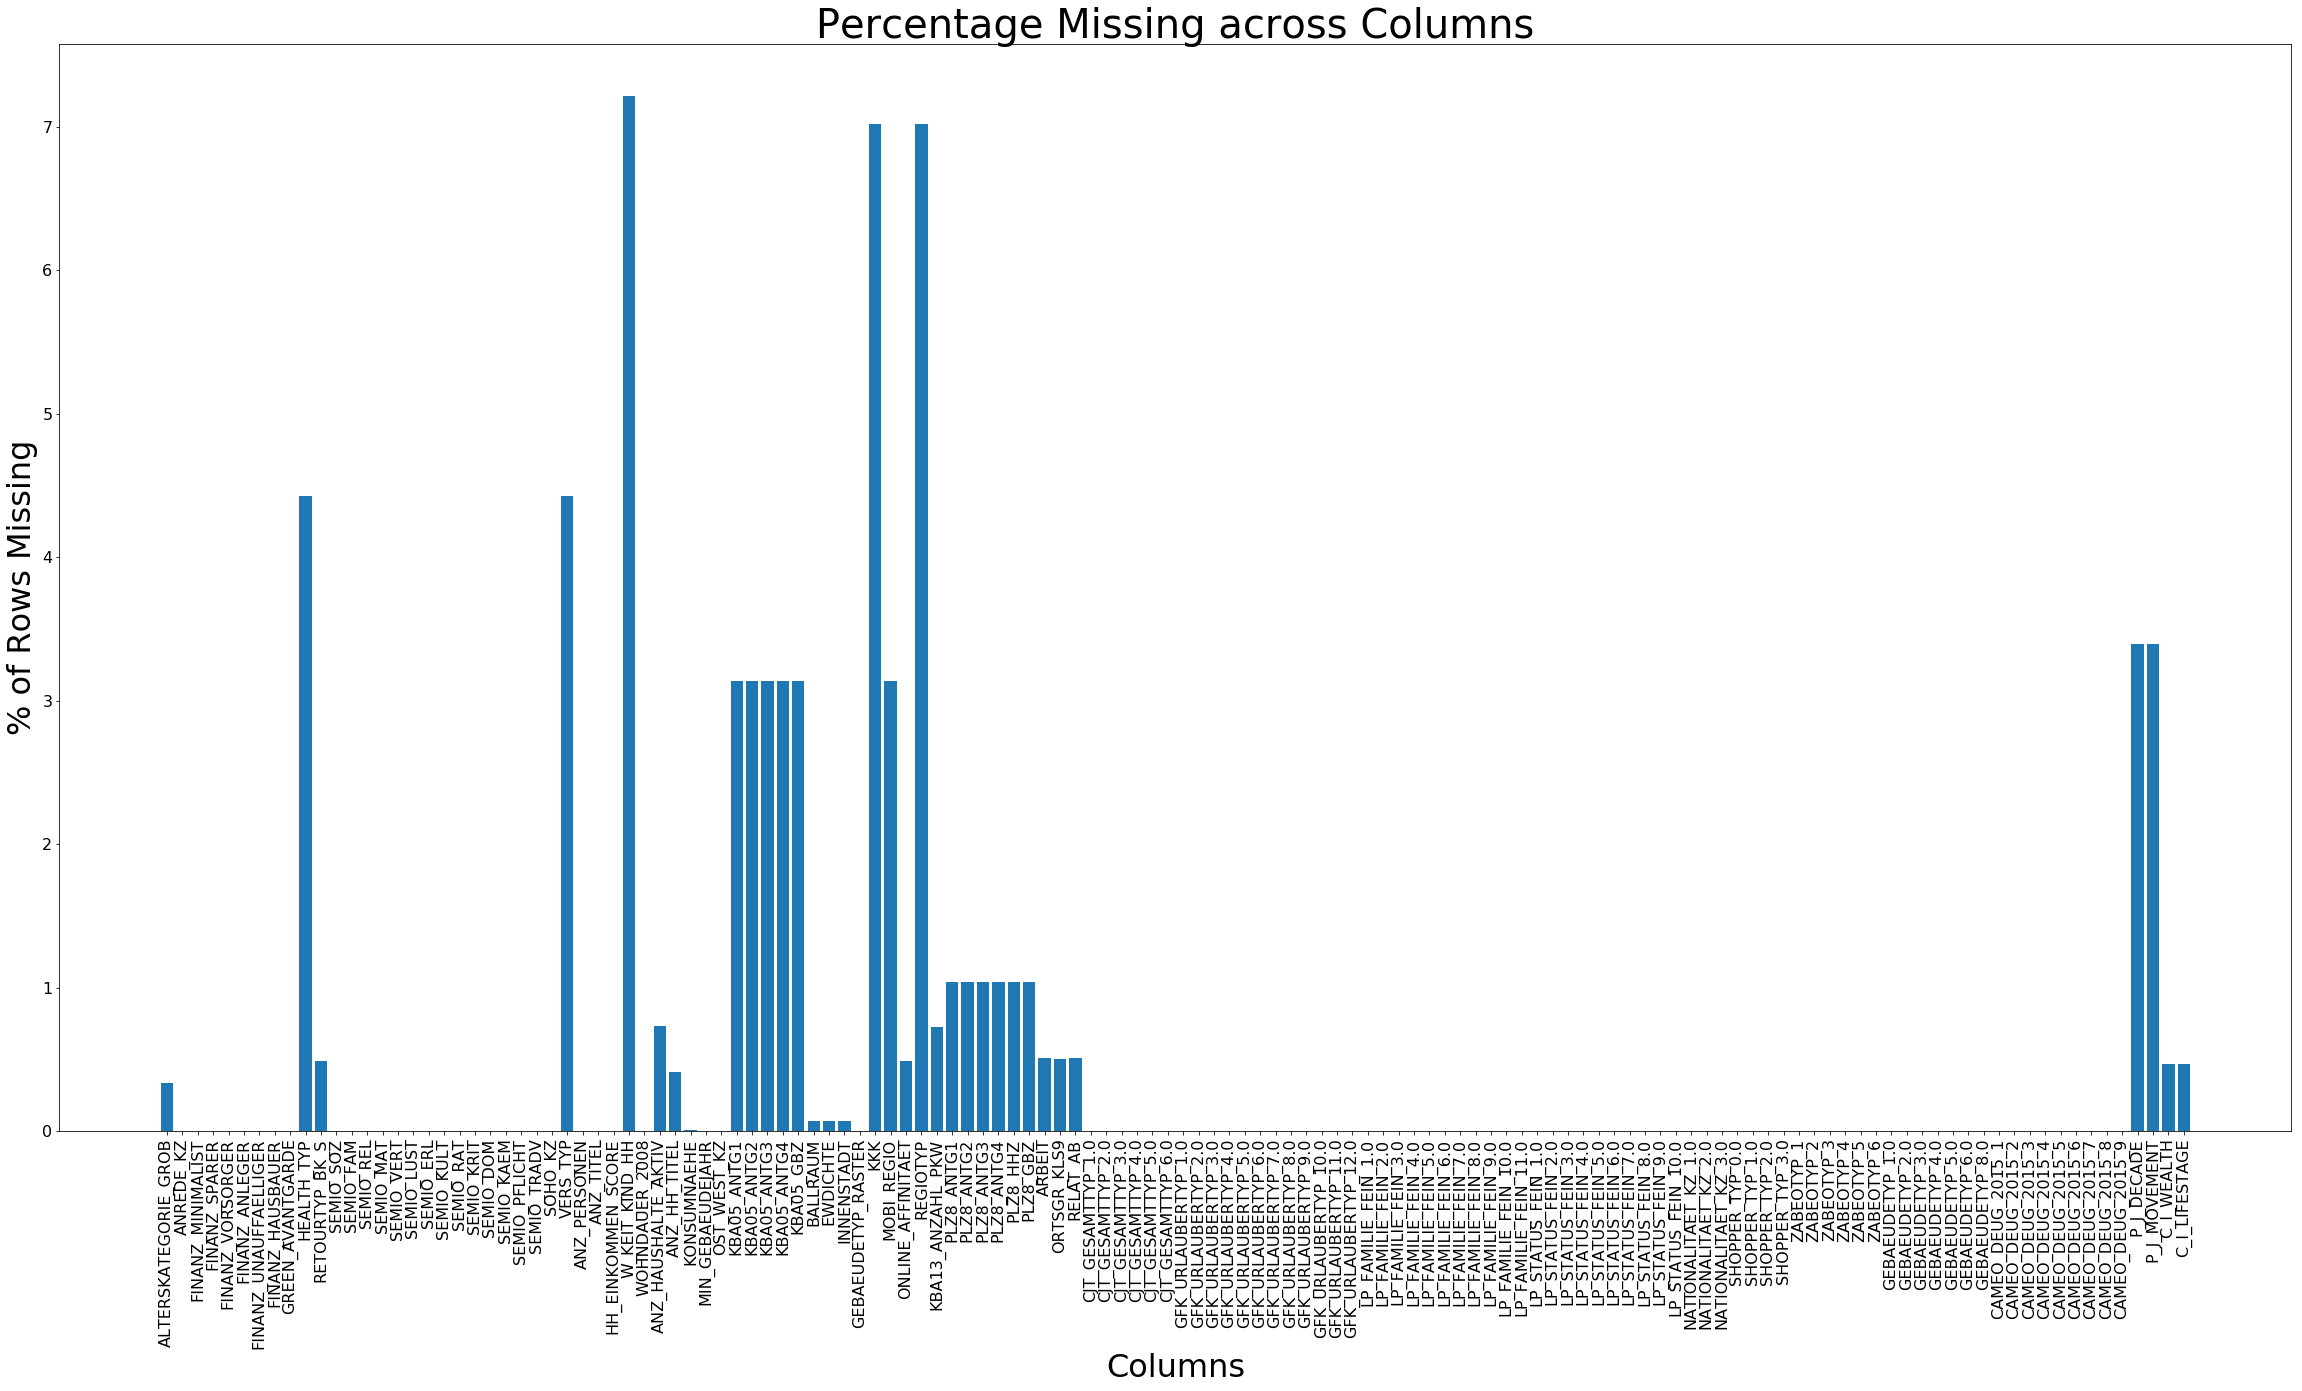

In [76]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Investigate patterns in the amount of missing data in each column.
# Max height 
final_total_missing = get_missing_counts(azdias)
final_proportion_missing = [ 100 * x / azdias.shape[0] for x in final_total_missing]
xloc = list(range(len(final_proportion_missing)))
xlabels = azdias.columns.values
max_y = max(final_proportion_missing)
plt.figure(figsize=(40, 20))
# Increase labelsize
plt.tick_params(axis='both', which='major', labelsize=16)
# Proportion missing
plt.bar(xloc, final_proportion_missing)
plt.xticks(xloc, xlabels, rotation = 'vertical')
# Add vlines for start of new info group
plt.xlabel('Columns', fontsize=32)
plt.ylabel('% of Rows Missing', fontsize=32)
plt.title('Percentage Missing across Columns', fontsize=40)
plt.show()

In [77]:
imputer = Imputer(strategy='most_frequent')

In [78]:
X = imputer.fit_transform(azdias)

In [79]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

In [80]:
X = scaler.fit_transform(X)

In [81]:
X_col_names = azdias.columns.values

### Discussion 2.1: Apply Feature Scaling

We see that utmost 5% of rows for a given column will be imputed. We will chose most frequent as the imputation strategy to replace nans with mode, so that we don't affect the overall distribution.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [82]:
# Apply PCA to the data.
pca_trial = PCA()
X_pca_trial = pca_trial.fit_transform(X)

In [83]:
#Ref- https://docs.python.org/2/library/bisect.html
def find_le(a, x):
    '''
    Find rightmost value less than or equal to x
    
    INPUT: a - array
            x- ref value 
            
    OUTPUT:
            position of value in array less than or equal to ref value
    '''
    i = bisect.bisect_right(a, x)
    if i:
        return i-1
    raise ValueError

In [84]:
# Ref - https://classroom.udacity.com/nanodegrees/nd025/parts/31adfeff-4f9d-4a6e-9856-629feab109be/modules/a4504b57-e14c-451e-ac40-70a2717efa98/lessons/dd43ee95-8403-4b8b-8574-ef5f41aa22bf/concepts/ec47206e-4b7b-4437-94b3-71197c805de9#
def scree_plot(pca, evr_markers=[], annotate_evr=False):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiation of PCA in scikit learn
           evr_markers - list of explained variance ratios at which to place markers
           annotate_evr - flag to show percent variablility explained for each component
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    if annotate_evr:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
    hline_min_x = 0
    vline_min_y = 0
    for evr in evr_markers:
        hline_y = evr
        hline_max_x = find_le(cumvals, evr) 
        plt.hlines([evr], hline_min_x, hline_max_x, linestyle='dashed', color='r')
        vline_max_y = cumvals[hline_max_x]
        plt.vlines([hline_max_x], vline_min_y, vline_max_y, linestyle='dashed', color='r')
        print("%d components required to explain a cumulative variance " % (hline_max_x), 
              "ratio of %.2f"% ( vline_max_y))
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained Ratio")
    plt.title('Explained Variance Per Principal Component')

58 components required to explain a cumulative variance  ratio of 0.80
74 components required to explain a cumulative variance  ratio of 0.90


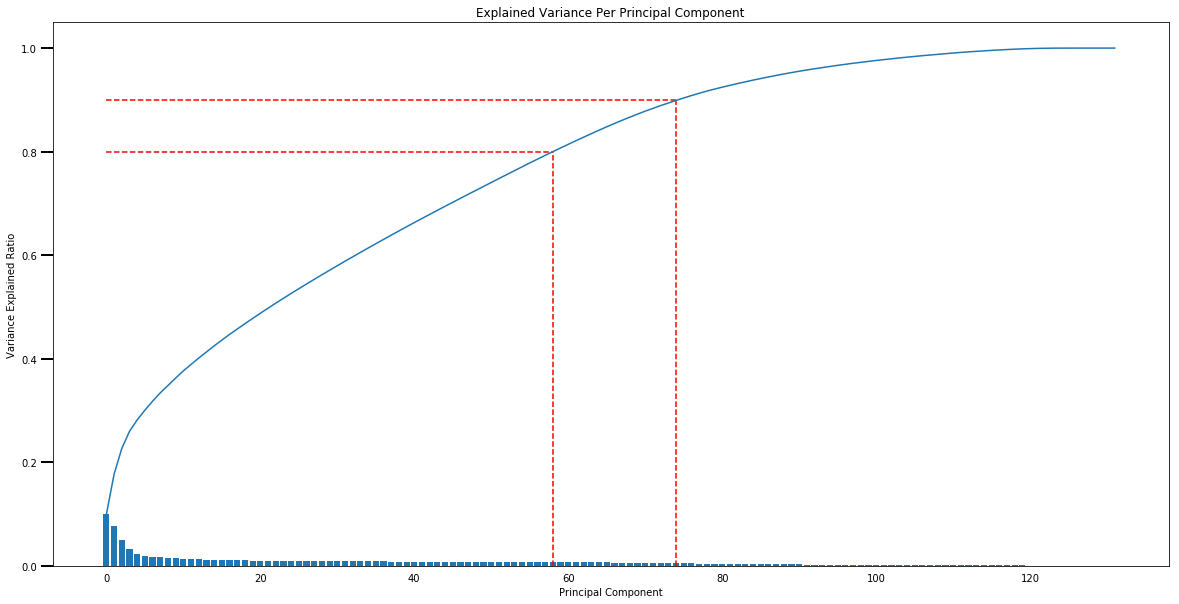

In [85]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_trial, evr_markers=[0.8, 0.9])

While nearly half the columns, we will still be able to explain a cumulative variance of upto 80% if we chose 58 as number of components to retain.

In [86]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 58)
X_pca = pca.fit_transform(X)


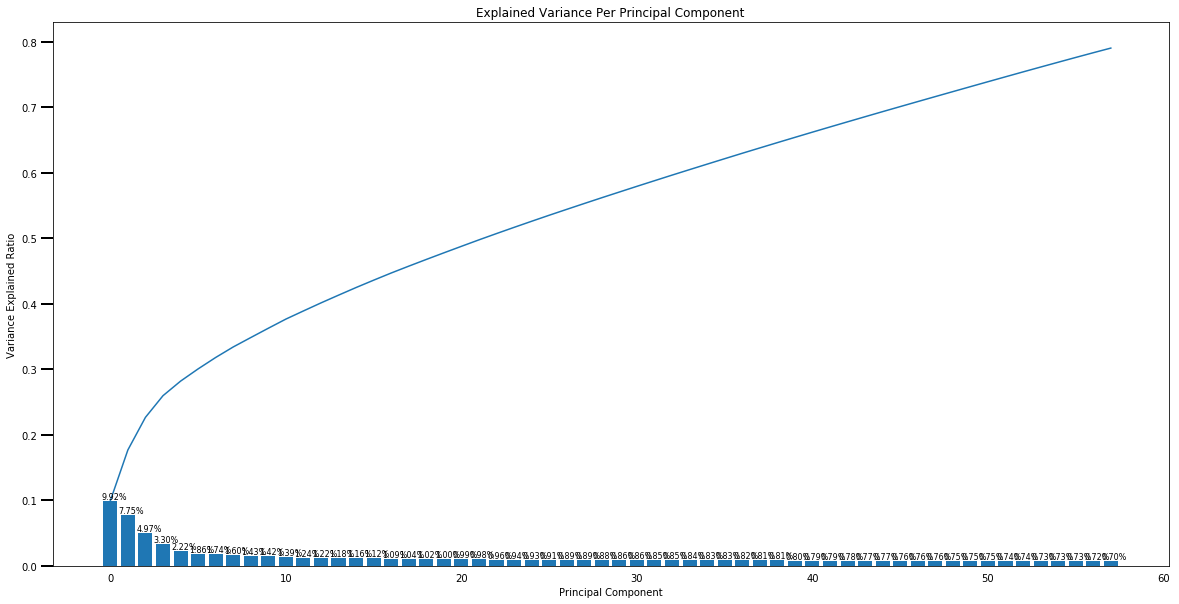

In [87]:
scree_plot(pca, annotate_evr=True)

### Discussion 2.2: Perform Dimensionality Reduction

We see that by retaining a componenet count that is less than half the original number of columns, we will be able to explain almost 80% variability in the data. Beyond the 80% variability the growth is slow for increasing component counts. So we choose 57 as the component count for principal component analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [88]:
def get_ordered_weights_for_pc(pca, col_names, comp_num):
    '''
    Get dataframe of weights of demographic dataframe column as index given pca object and the component num
    
    INPUT: pca - the result of instantiation of PCA in scikit learn
           col_names - column names of demographic dataframe
           comp_num - principal component number to return weights for
            
    OUTPUT:
         dataframe of weights with demographic column names as index sorted in descending order
    '''
    weights_df = pd.DataFrame(pca.components_[comp_num - 1], index = col_names, columns = ['weights'])
    # calculate absolute weights to use for sorting
    weights_df['abs_weights'] = weights_df.weights.apply(lambda x: abs(x))
    weights_df.sort_values(by=['abs_weights'], ascending = False, inplace=True)
    # Don't need abs weight anymore
    weights_df.drop(columns=['abs_weights'], inplace=True)
    return weights_df

In [89]:
def display_ordered_pc_weights(ordered_weights_df, n_cols=None, comp_num=None):
    '''
    Plot weights against column names
    
    INPUT: ordered_weights_df - dataframe returned by get_ordered_weights_for_pc with sorted weights
           n_cols - number of cols to display
           comp_num - principal component number associated with the weights_df
    OUTPUT:
            None
    '''
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    if n_cols:
        ordered_weights_df = ordered_weights_df.head(n_cols)
    ordered_weights_df.plot(ax = ax, y='weights', kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xlabel("Columns")
    title = "Ordered Column weights"
    if comp_num:
        title += ' for Principal Component %d' % (comp_num)
    ax.set_title(title)
    ax.get_legend().remove()
    plt.show()

Visualization of top 10 most important columns in terms of weights


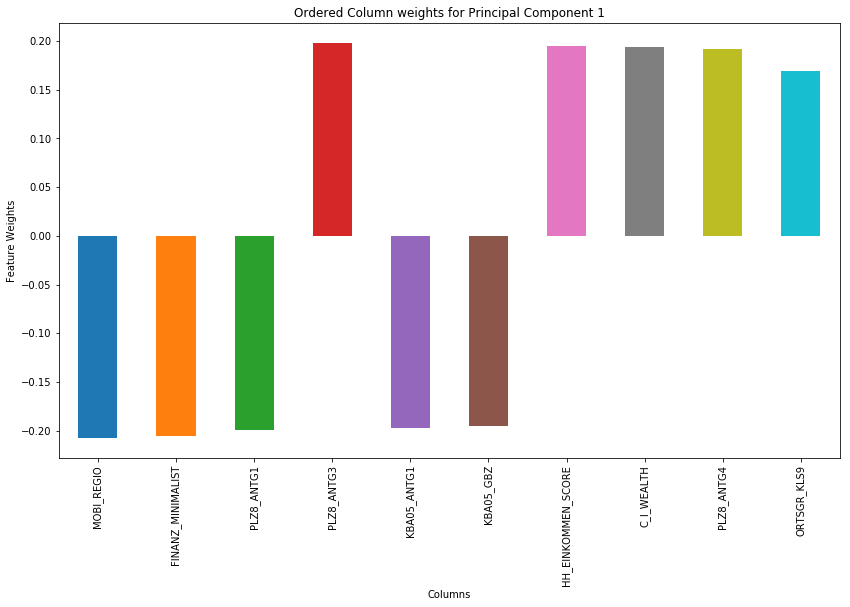

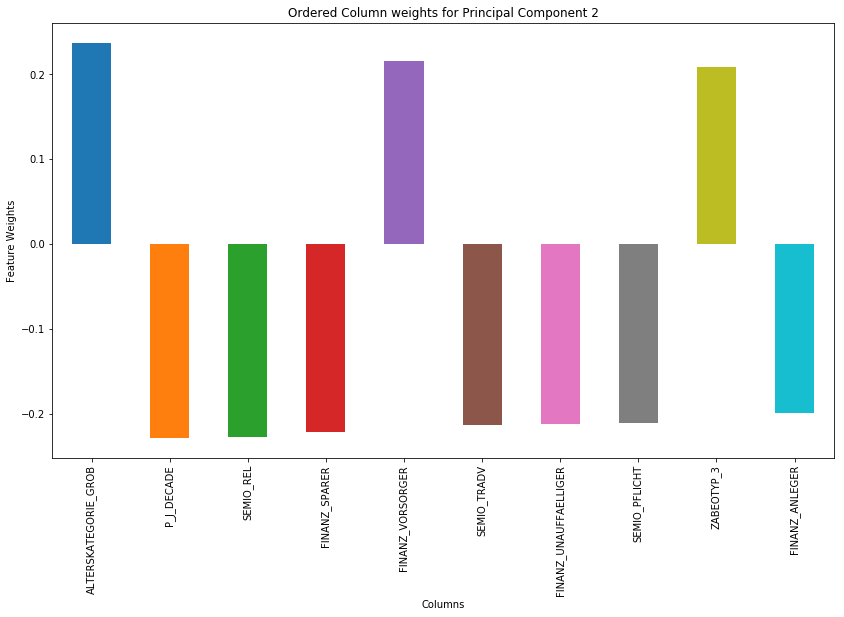

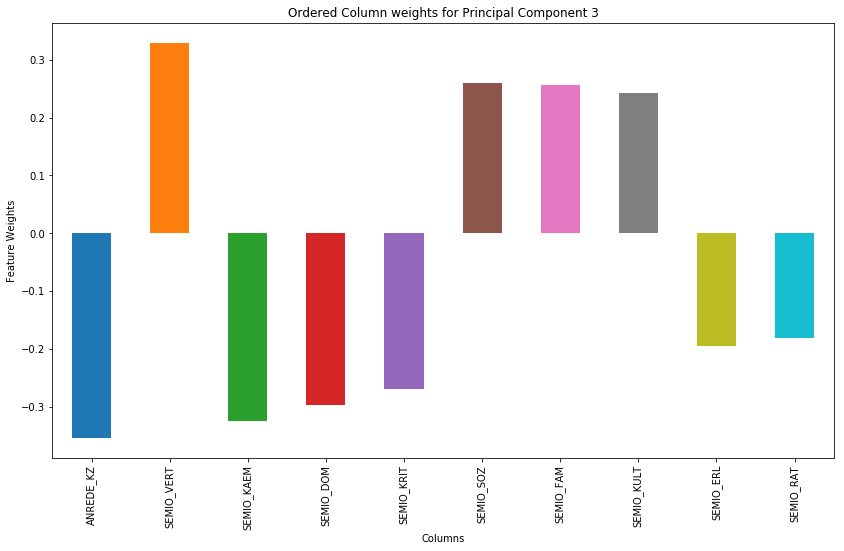





Column Weights For Components Sorted By Absolute Weight
Sorted Column Weights for Principal Component 1


,weights
MOBI_REGIO,-0.207701
FINANZ_MINIMALIST,-0.205951
PLZ8_ANTG1,-0.199199
PLZ8_ANTG3,0.198225
KBA05_ANTG1,-0.197435
KBA05_GBZ,-0.194871
HH_EINKOMMEN_SCORE,0.194690
C_I_WEALTH,0.193767
PLZ8_ANTG4,0.191446
ORTSGR_KLS9,0.169575



***************



Sorted Column Weights for Principal Component 2


,weights
ALTERSKATEGORIE_GROB,0.237213
P_J_DECADE,-0.228517
SEMIO_REL,-0.226876
FINANZ_SPARER,-0.221355
FINANZ_VORSORGER,0.215738
SEMIO_TRADV,-0.213570
FINANZ_UNAUFFAELLIGER,-0.211699
SEMIO_PFLICHT,-0.210296
ZABEOTYP_3,0.209108
FINANZ_ANLEGER,-0.199239



***************



Sorted Column Weights for Principal Component 3


,weights
ANREDE_KZ,-0.354104
SEMIO_VERT,0.329592
SEMIO_KAEM,-0.324804
SEMIO_DOM,-0.297837
SEMIO_KRIT,-0.269978
SEMIO_SOZ,0.260597
SEMIO_FAM,0.255792
SEMIO_KULT,0.242263
SEMIO_ERL,-0.194167
SEMIO_RAT,-0.180907



***************





In [90]:
# Map weights for the first 3 principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
n_top = 10
ordered_weights_df_arr = []
print("Visualization of top %d most important columns in terms of weights" % (n_top))
for comp_num in range(1, 4):
    ordered_weights_df_arr.append(get_ordered_weights_for_pc(pca, X_col_names, comp_num))
    display_ordered_pc_weights(ordered_weights_df_arr[comp_num-1], n_cols=n_top, comp_num=comp_num)
print("\n\n\n")
print("Column weights for components sorted by absolute weight".title())
for comp_num in range(1, 4):
        print("Sorted Column Weights for Principal Component %d" % (comp_num))
        display(ordered_weights_df_arr[comp_num-1])
        print("\n***************\n\n\n")

### Discussion 2.3: Interpret Principal Components

The first principal component seems to be weighing the columns related to movement, number of homes in the neighbourhood and financial interest. The following components get negative weights - MOBI_REGIO, FINANZ_MINIMALIST, PLZ8_ANTG1 whereas these get positive weights - PLZ8_ANTG3, HH_EINKOMMEN_SCORE etc. So, the correlation is in the direction of more homes in the neighbourhood (6-10 is positively correlated, 1-2 is negatively correlated but both are strongly correlated). Similarly, lower incomes and poorer get positive weights. So, the first principal is associated with detecting poorer households in denser neighbourhoods.

The second prinical positively weights older population with fair supplied energy consumption topology (ZABEOTYP_3, ALTERSKATEGORIE_GROB get large positive weights). Rows with younger people as well as more religious and traditional groups get large negative weights.  

The third principal heavily weights features related to gender and temperament, positively weighing man and people categorized as dreamful and negatively weighing combative, critical minded datasets.

Overall, 10% of the variability seems to be explained by features related to income and neighbourhood, followed by features related to age that explain another 8% of the variability, and features related to temperament explaining another 5% of the variablity. We will look out for features related to these in analyzing our customer clusters.




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [91]:
# Plot the score against k
def get_kmeans_score(data, k):
    '''
    Get absolute value of kmeans score indicating average distance from centroids for given number of centroids
    
    INPUT: data - numpy array to fit into k clusters
            k - number of centroids
            
    OUTPUT:
         Score indicating average distance from centroids
    '''
    # Try instantiating a model with k centers
    kmeans = KMeans(k)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Finally predict the labels on the same data to show the category that point belongs to
    return abs(kmeans.score(data))
    

In [92]:
def sweep_centroids(data, k_list):
    '''
    Sweep over a list of centroid counts, and return kmeans score array
    
    INPUT: data - numpy array to fit into k clusters
            k_list - list of number of centroids
            
    OUTPUT:
         Array of Score indicating average distance from centroids for each entry in k_list
    '''
# Over a number of different cluster counts...
    scores = []
    num_sweeps = len(k_list)
    start_t = timer()
    for i, k in enumerate(k_list):
        # run k-means clustering on the data and...
        # compute the average within-cluster distances.
        scores.append(get_kmeans_score(data, k))
        current_t = timer()
        # Print a new bar for every 5% increase, ie num complete out of total 20 bars
        num_bars = int((i + 1)* 20/num_sweeps)
        print('Sweep %d/%d completed: [%-20s]\tElapsed Time: %d sec' %( i+1, num_sweeps, '=' * num_bars, current_t - start_t), end='\r')  
    print("\n")
    return scores
    

In [93]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def plot_SSE(scores, k_list):
    '''
    Plot of sum of squared errors against centroid count to find elbow
    
    INPUT: scores - Array of Score indicating average distance from centroids for each entry in k_list
           k_list - list of number of centroids
            
    OUTPUT:
         None
    '''
    plt.plot(k_list, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');
    plt.show()


Let's do a sweep of centroid counts from 1 to 30 with a smaller subset of our dataset to observe rough trends.

Sweep 30/30 completed: [====================]	Elapsed Time: 50 sec



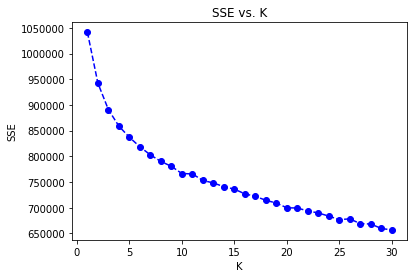

In [94]:
k_list = list(range(1, 31, 1))
scores = sweep_centroids(X_pca[0:10000], k_list)
plot_SSE(scores, k_list)

We see that the elbow is definitely hit before 15 centroids. Let us rerun the sweep with the full dataset to get a more precise view to spot the elbow.

Sweep 14/14 completed: [====================]	Elapsed Time: 1453 sec



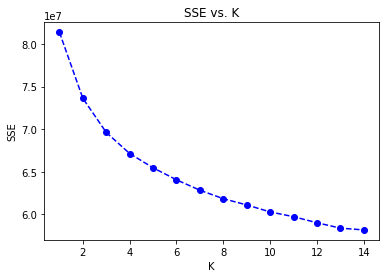

In [95]:
k_list = list(range(1, 15, 1))
scores = sweep_centroids(X_pca, k_list)
plot_SSE(scores, k_list)

The elbow is rather smooth but 13 clusters looks like it might be a good candidate sitting on the lower side of the elbow.

In [96]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(13)
general_labels = kmeans.fit_predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

Using Elbow method, we fix the number of clusters at 13.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [97]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [98]:
customers.shape

(191652, 85)

In [99]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers, customers_discarded = clean_data(customers)

In [100]:
azdias.shape

(780153, 132)

In [101]:
customers.shape

(139068, 131)

In [102]:
list(set(azdias.columns.tolist()) - set(customers.columns.tolist()))

['GEBAEUDETYP_5.0']

We see that the customer dataset has no GEBAEUDETYP = 5, so we will add a dummy encoding manually for this value.

In [103]:
customers['GEBAEUDETYP_5.0'] = np.repeat(0, customers.shape[0])

In [104]:
X_customers = imputer.transform(customers)

In [105]:
X_customers = scaler.transform(X_customers)

In [106]:
X_customers_pca = pca.transform(X_customers)

In [107]:
customer_labels = kmeans.predict(X_customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [136]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_clusters, general_cluster_counts = np.unique(general_labels, return_counts=True)
customer_clusters, customer_cluster_counts = np.unique(customer_labels, return_counts=True)

In [137]:
assert (general_clusters == customer_clusters).all()

In [138]:
general_cluster_pct = [x * 100 / (azdias.shape[0] + azdias_discarded.shape[0]) for x in general_cluster_counts]
general_cluster_pct.insert(0, 100 * azdias_discarded.shape[0] / (azdias.shape[0] + azdias_discarded.shape[0]))
general_clusters = np.insert(general_clusters, 0, -1)
customer_cluster_pct = [x * 100 / (customers.shape[0] + customers_discarded.shape[0]) for x in customer_cluster_counts]
customer_cluster_pct.insert(0, 100 * customers_discarded.shape[0] / (azdias.shape[0] + azdias_discarded.shape[0]))
customer_clusters = np.insert(customer_clusters, 0, -1)

In [139]:
# Get count of population in each cluster for general and customer datasets
general_cluster_df = pd.DataFrame(general_cluster_pct, index = general_clusters, columns = ['general'])
customer_cluster_df = pd.DataFrame(customer_cluster_pct, index = general_clusters, columns = ['customer'])

In [140]:
cluster_pct_df = general_cluster_df.join(customer_cluster_df)

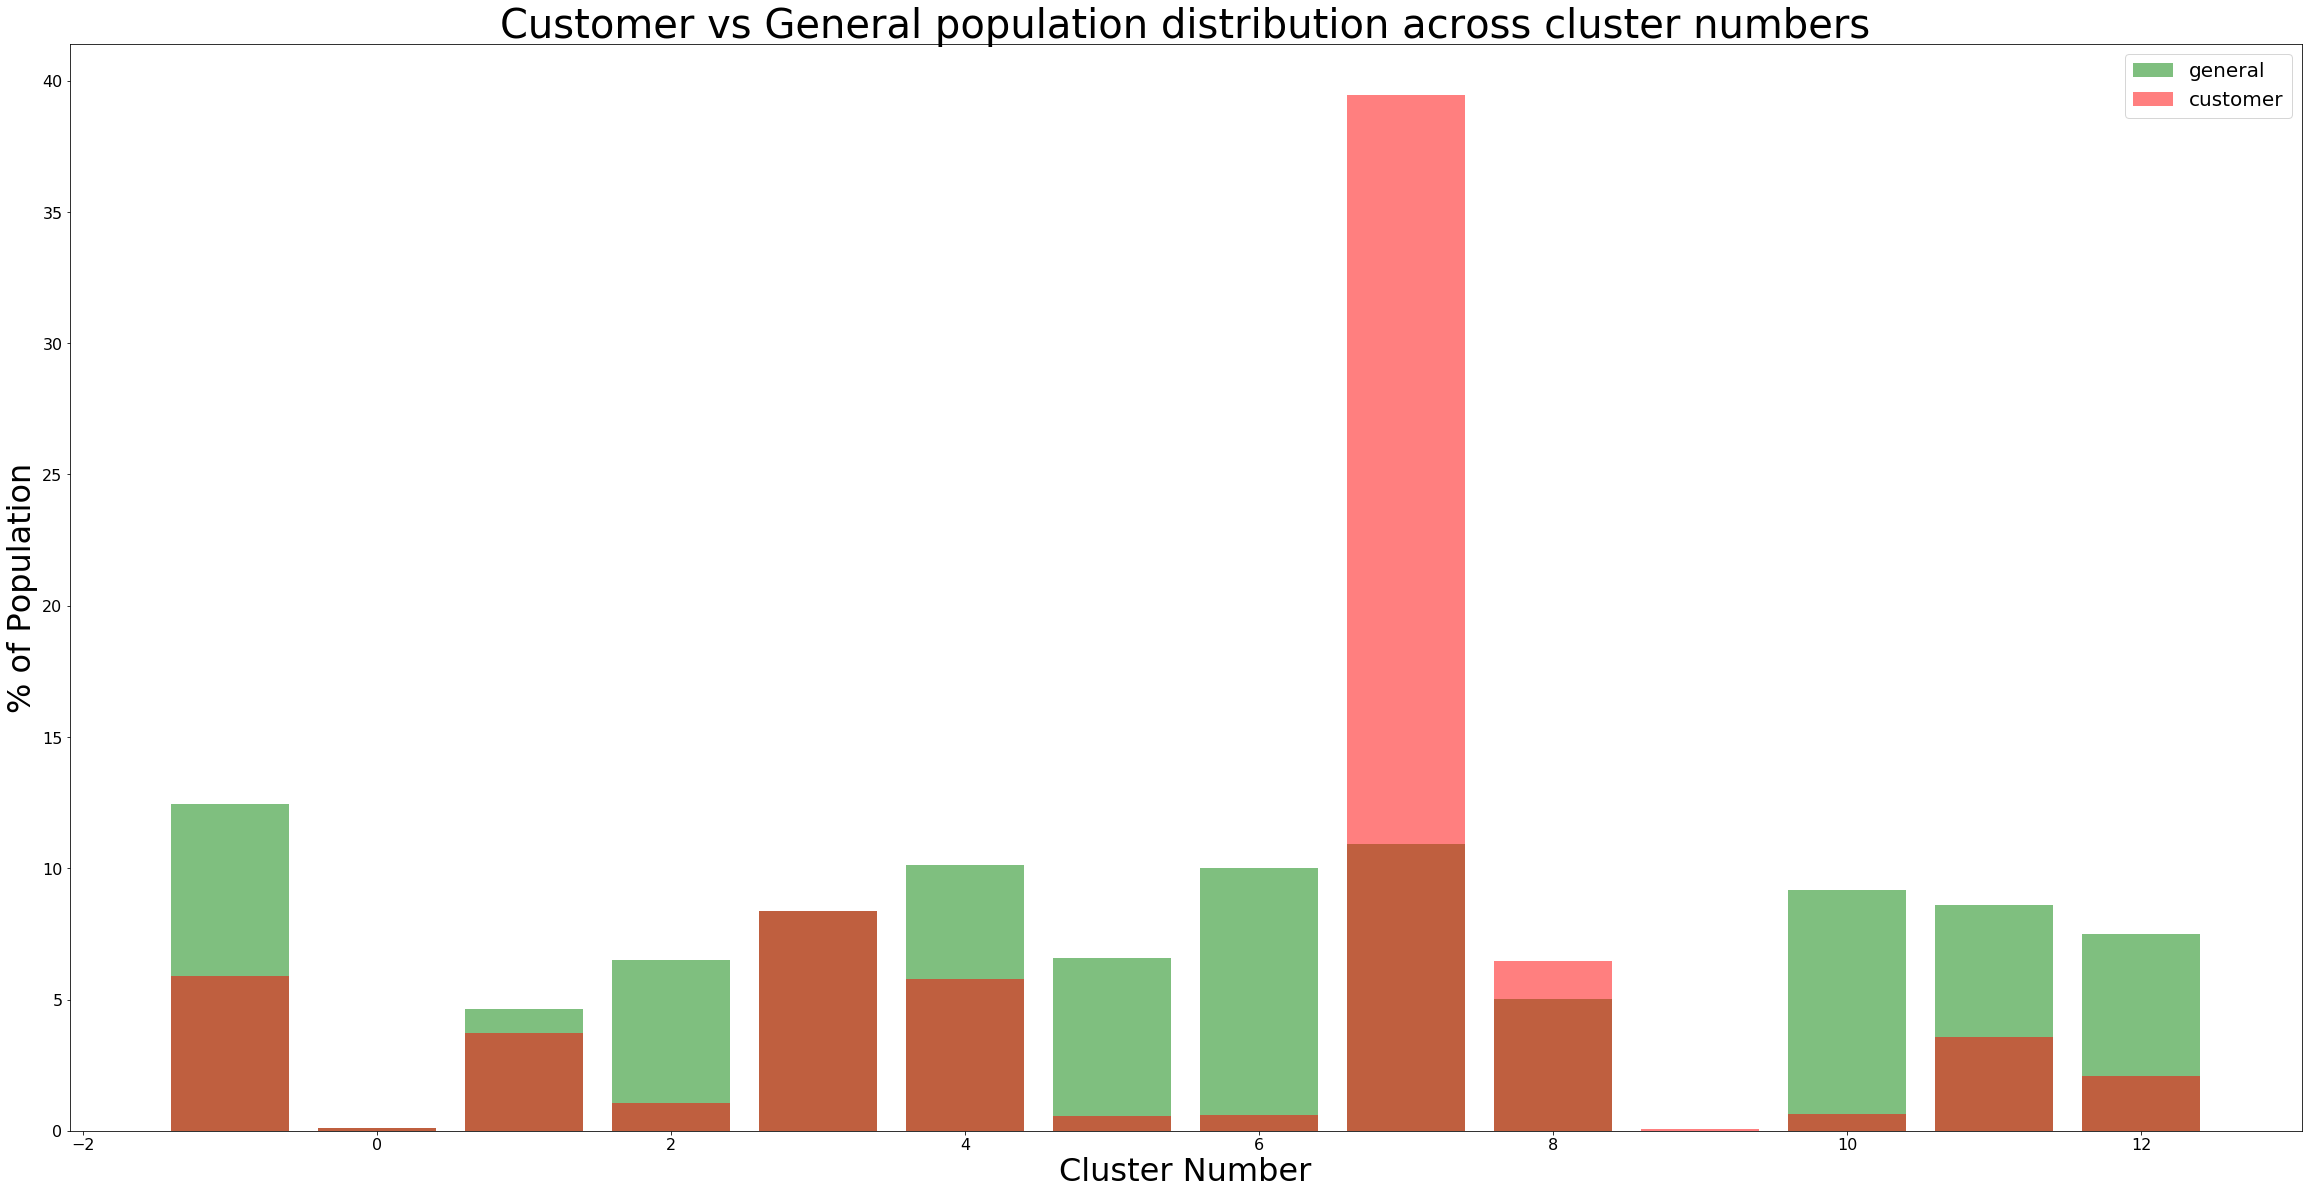

In [141]:
max_y = 100
plt.figure(figsize=(40, 20))
# Increase labelsize
plt.tick_params(axis='both', which='major', labelsize=16)
# Naturally missing in red
plt.bar(cluster_pct_df.index.tolist(), cluster_pct_df.general.tolist(), alpha = 0.5, label = 'general', color = 'g')
# Encoded missing in green
plt.bar(cluster_pct_df.index.tolist(), cluster_pct_df.customer.tolist(), alpha = 0.5, label = 'customer', color = 'r')
#plt.xticks(cluster_pct_df.index.tolist(), xlabels, rotation = 'vertical')
plt.legend(fontsize=20)
plt.xlabel('Cluster Number', fontsize=32)
plt.ylabel('% of Population', fontsize=32)
plt.title('Customer vs General population distribution across cluster numbers', fontsize=40)
plt.show()

In [142]:
def get_inverse_transform(X, labels, cluster_number):
    '''
    Get back labeled dataframe for a given cluster label, performing inverse pca and inverse standard scaling
    
    INPUT: X - demographic dataset after pca
            labels - label dictionary to use for filtering
            cluster_number - Which cluster to filter out for inverse transforming

            
    OUTPUT:
         dataframe of population belonging to given cluster number based on labels
    '''
    return pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(X[np.where(labels == cluster_number)])).round(), columns = azdias.columns)

In [143]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 6 and 1 have overrepresentation of customers
azdias_core = get_inverse_transform(X_pca, general_labels, 6)
customers_core = get_inverse_transform(X_customers_pca, customer_labels, 6)

In [144]:
azdias_core_most_frequent = azdias_core.mode().values.tolist()[0]
customers_core_most_frequent = customers_core.mode().values.tolist()[0]

In [145]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 4, 9, 10  have underrepresentation for customers
azdias_fringe = get_inverse_transform(X_pca, general_labels, 4)
customers_fringe = get_inverse_transform(X_customers_pca, customer_labels, 4)

In [146]:
azdias_fringe_most_frequent = azdias_fringe.mode().values.tolist()[0]
customers_fringe_most_frequent = customers_fringe.mode().values.tolist()[0]

Let's plot the mode/most frequent value for each of the columns in the core interest group (cluster most likely to be customers for mail order sales company) and fringe interest group (less likely to be customers). We will do this for both the general population and the customer population to spot consistent trends. 

In [147]:
col_x_labels = azdias_core.columns.tolist()

In [148]:
col_x_loc = list(range(len(col_x_labels)))

In [149]:
def plot_core_vs_fringe(x_loc, x_labels, core_counts, fringe_counts, population):
    '''
    Plot most common value for each column identifying core and fringe group in separate colors
    
    INPUT: x_loc - array of feature indices
            x_labels - feature names
            core_counts - list of mode for each column in core group
            fringe_group - list of mode for each column in fringe group
            population - label identifying population as general or customer

            
    OUTPUT:
         None
    '''
    # Max height 
    plt.figure(figsize=(40, 20))
    # Increase labelsize
    plt.tick_params(axis='both', which='major', labelsize=16)
    # Fringe group in red
    plt.bar(x_loc, fringe_counts, alpha = 0.5, label = 'fringe', color = 'r')
    # Core group in green
    plt.bar(x_loc, core_counts, alpha = 0.5, label = 'core', color = 'g')
    plt.xticks(x_loc, x_labels, rotation = 'vertical')
    plt.legend(fontsize=20)
    plt.xlabel('Columns', fontsize=32)
    plt.ylabel('Most frequently occuring value', fontsize=32)
    plt.title('Most frequent value for core and fringe customer subset in %s population' % (population), fontsize=40)
    plt.show()

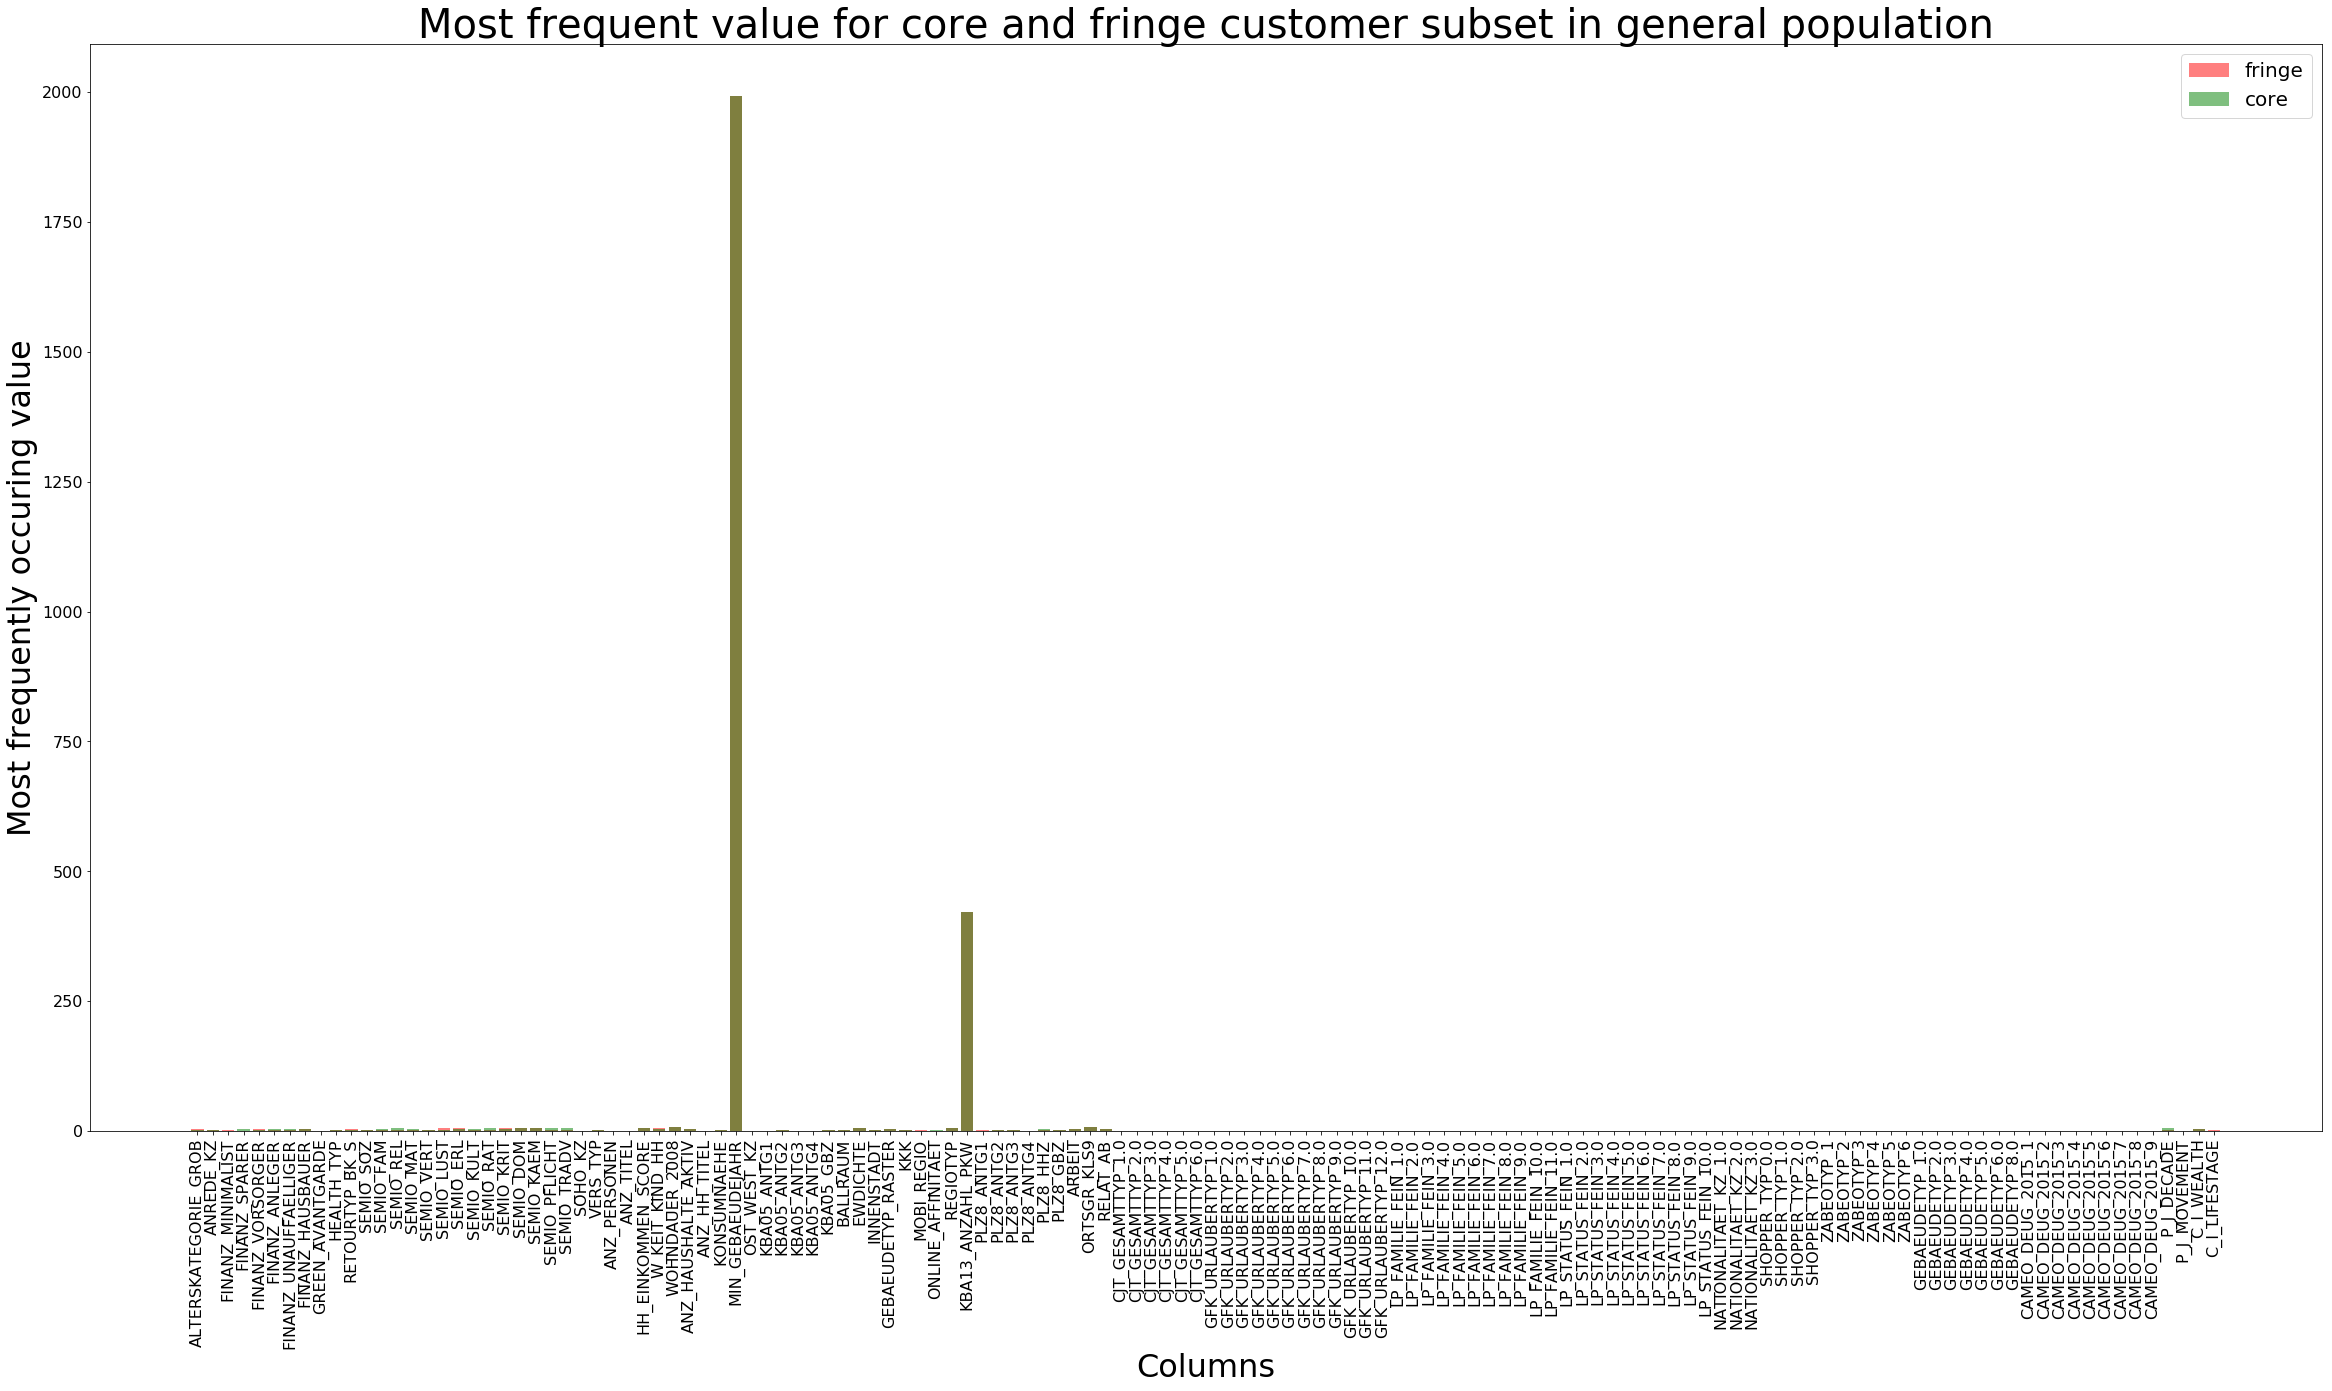

In [150]:
plot_core_vs_fringe(col_x_loc, col_x_labels, azdias_core_most_frequent, azdias_fringe_most_frequent, "general")

Since this dataframe is not standard scaled, we see that MIN_GEBAEUDEIAHR and KBA13_ANZAHL_PKW are distorting our axes while not contribution to difference between the clusters. Therefore, we will set this to -1 during plotting to mark it as not important.

In [151]:
azdias_core_modified = [x if x < 250 else -1 for x in azdias_core_most_frequent]
azdias_fringe_modified = [x if x < 250 else -1 for x in azdias_fringe_most_frequent]

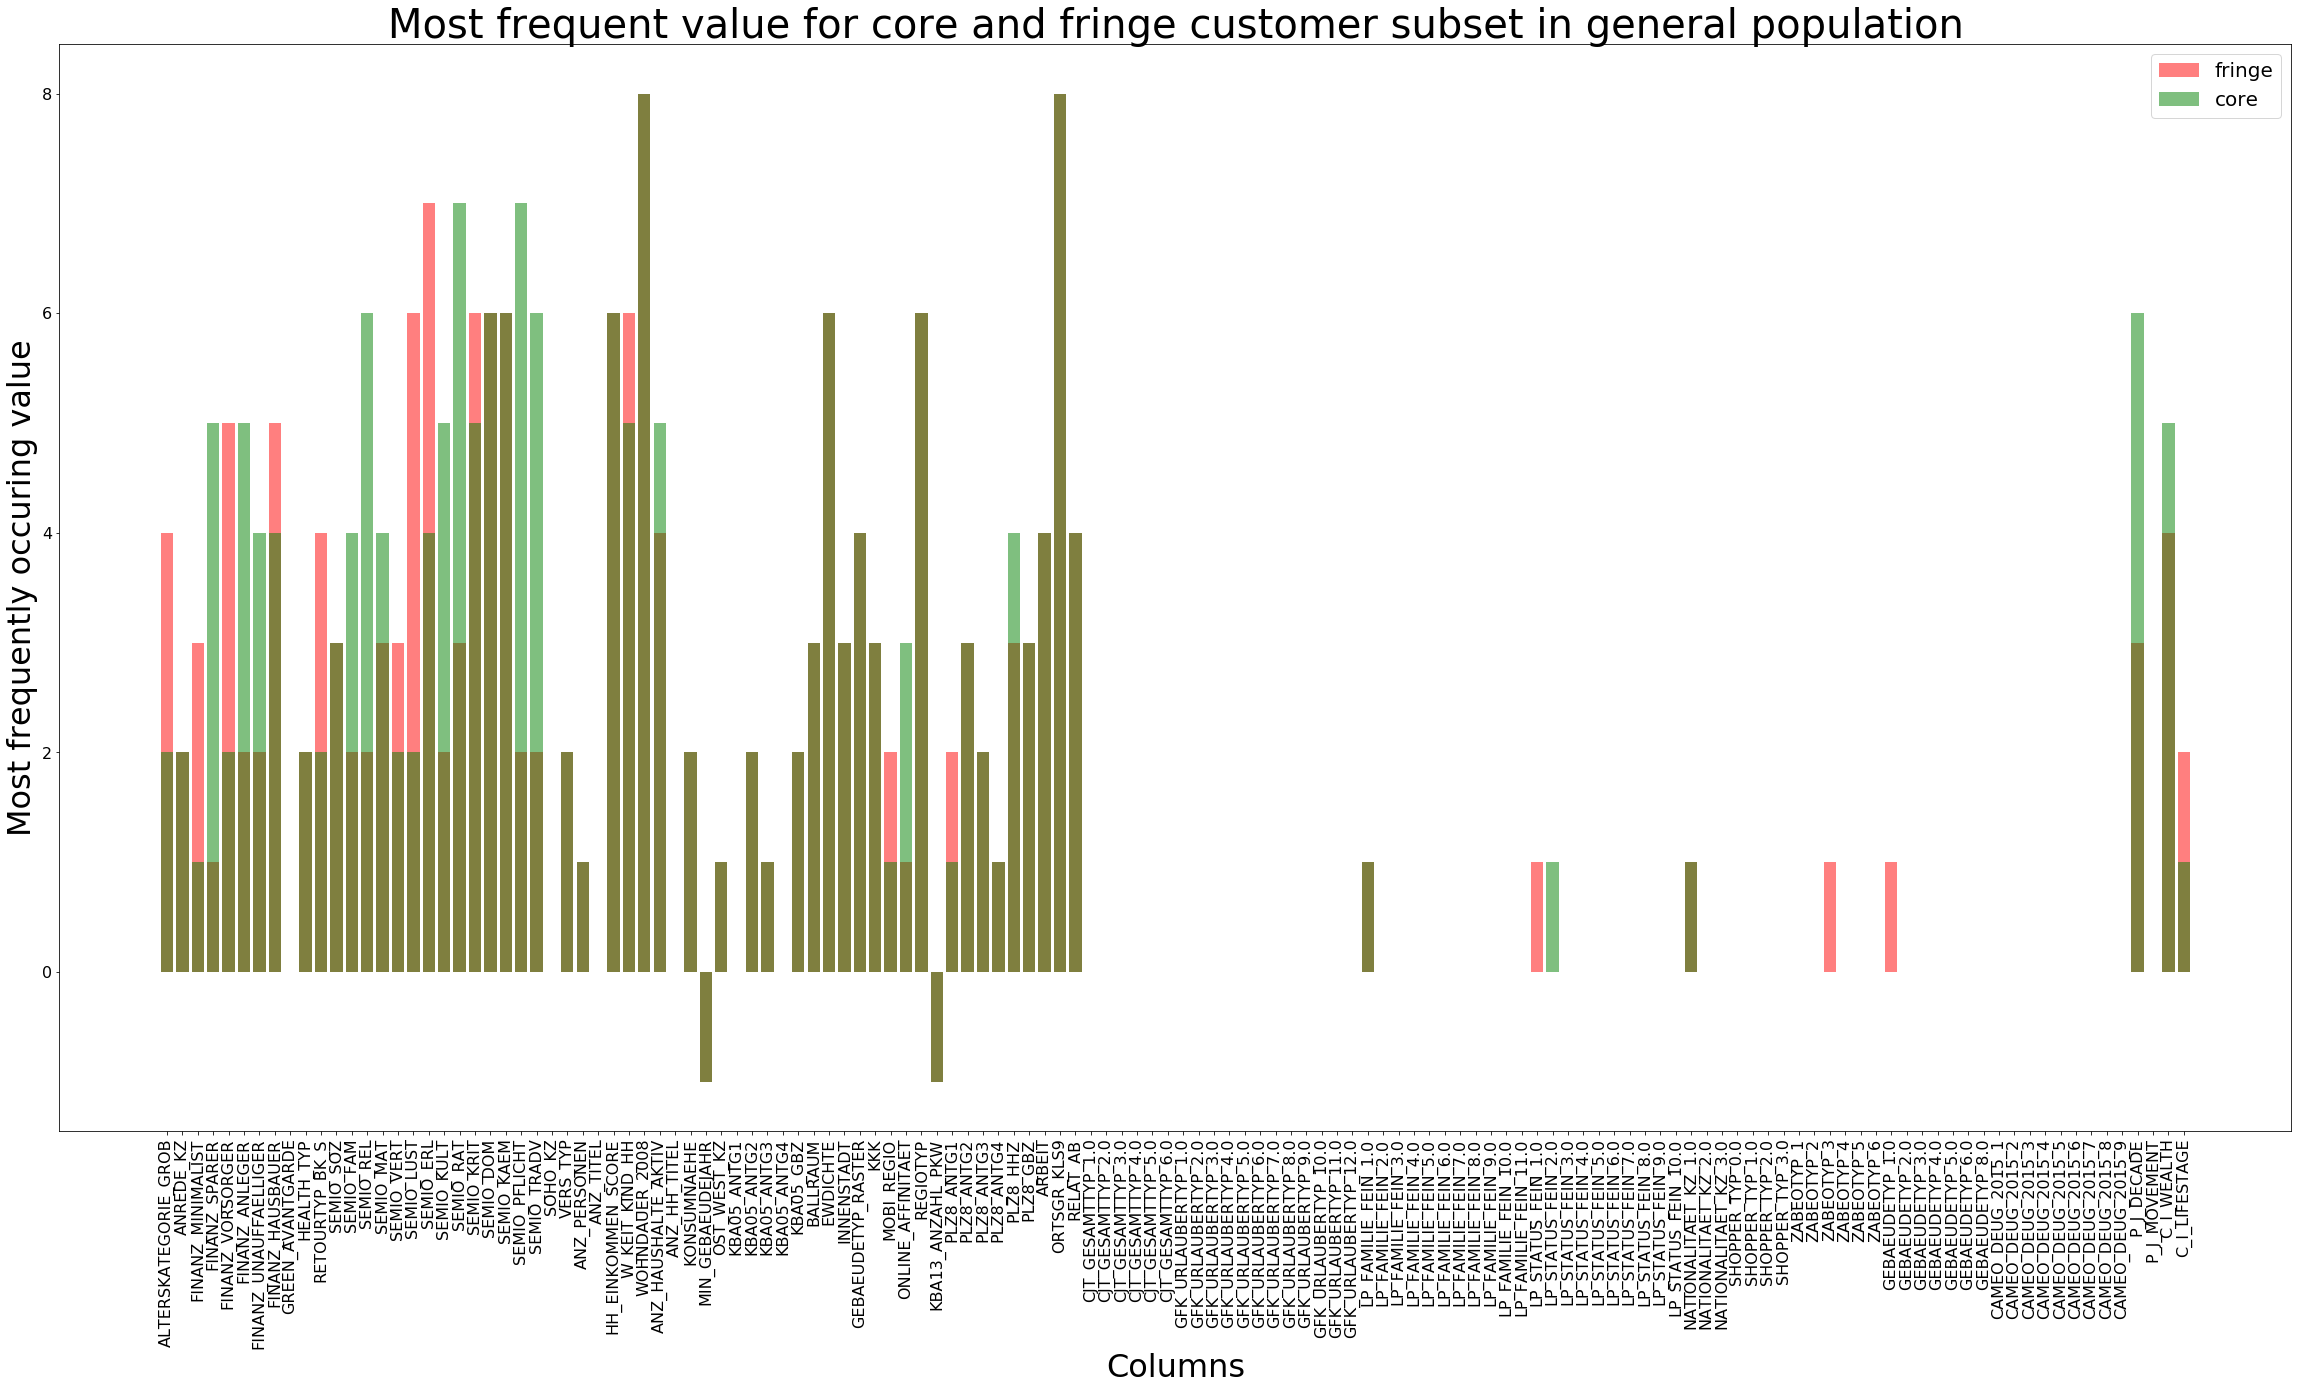

In [152]:
plot_core_vs_fringe(col_x_loc, col_x_labels, azdias_core_modified, azdias_fringe_modified, "general")

Let's also plot the same relationship between cluster 6 and 4 in the customer dataset.

In [153]:
customers_core_modified = [x if x < 250 else -1 for x in customers_core_most_frequent]
customers_fringe_modified = [x if x < 250 else -1 for x in customers_fringe_most_frequent]

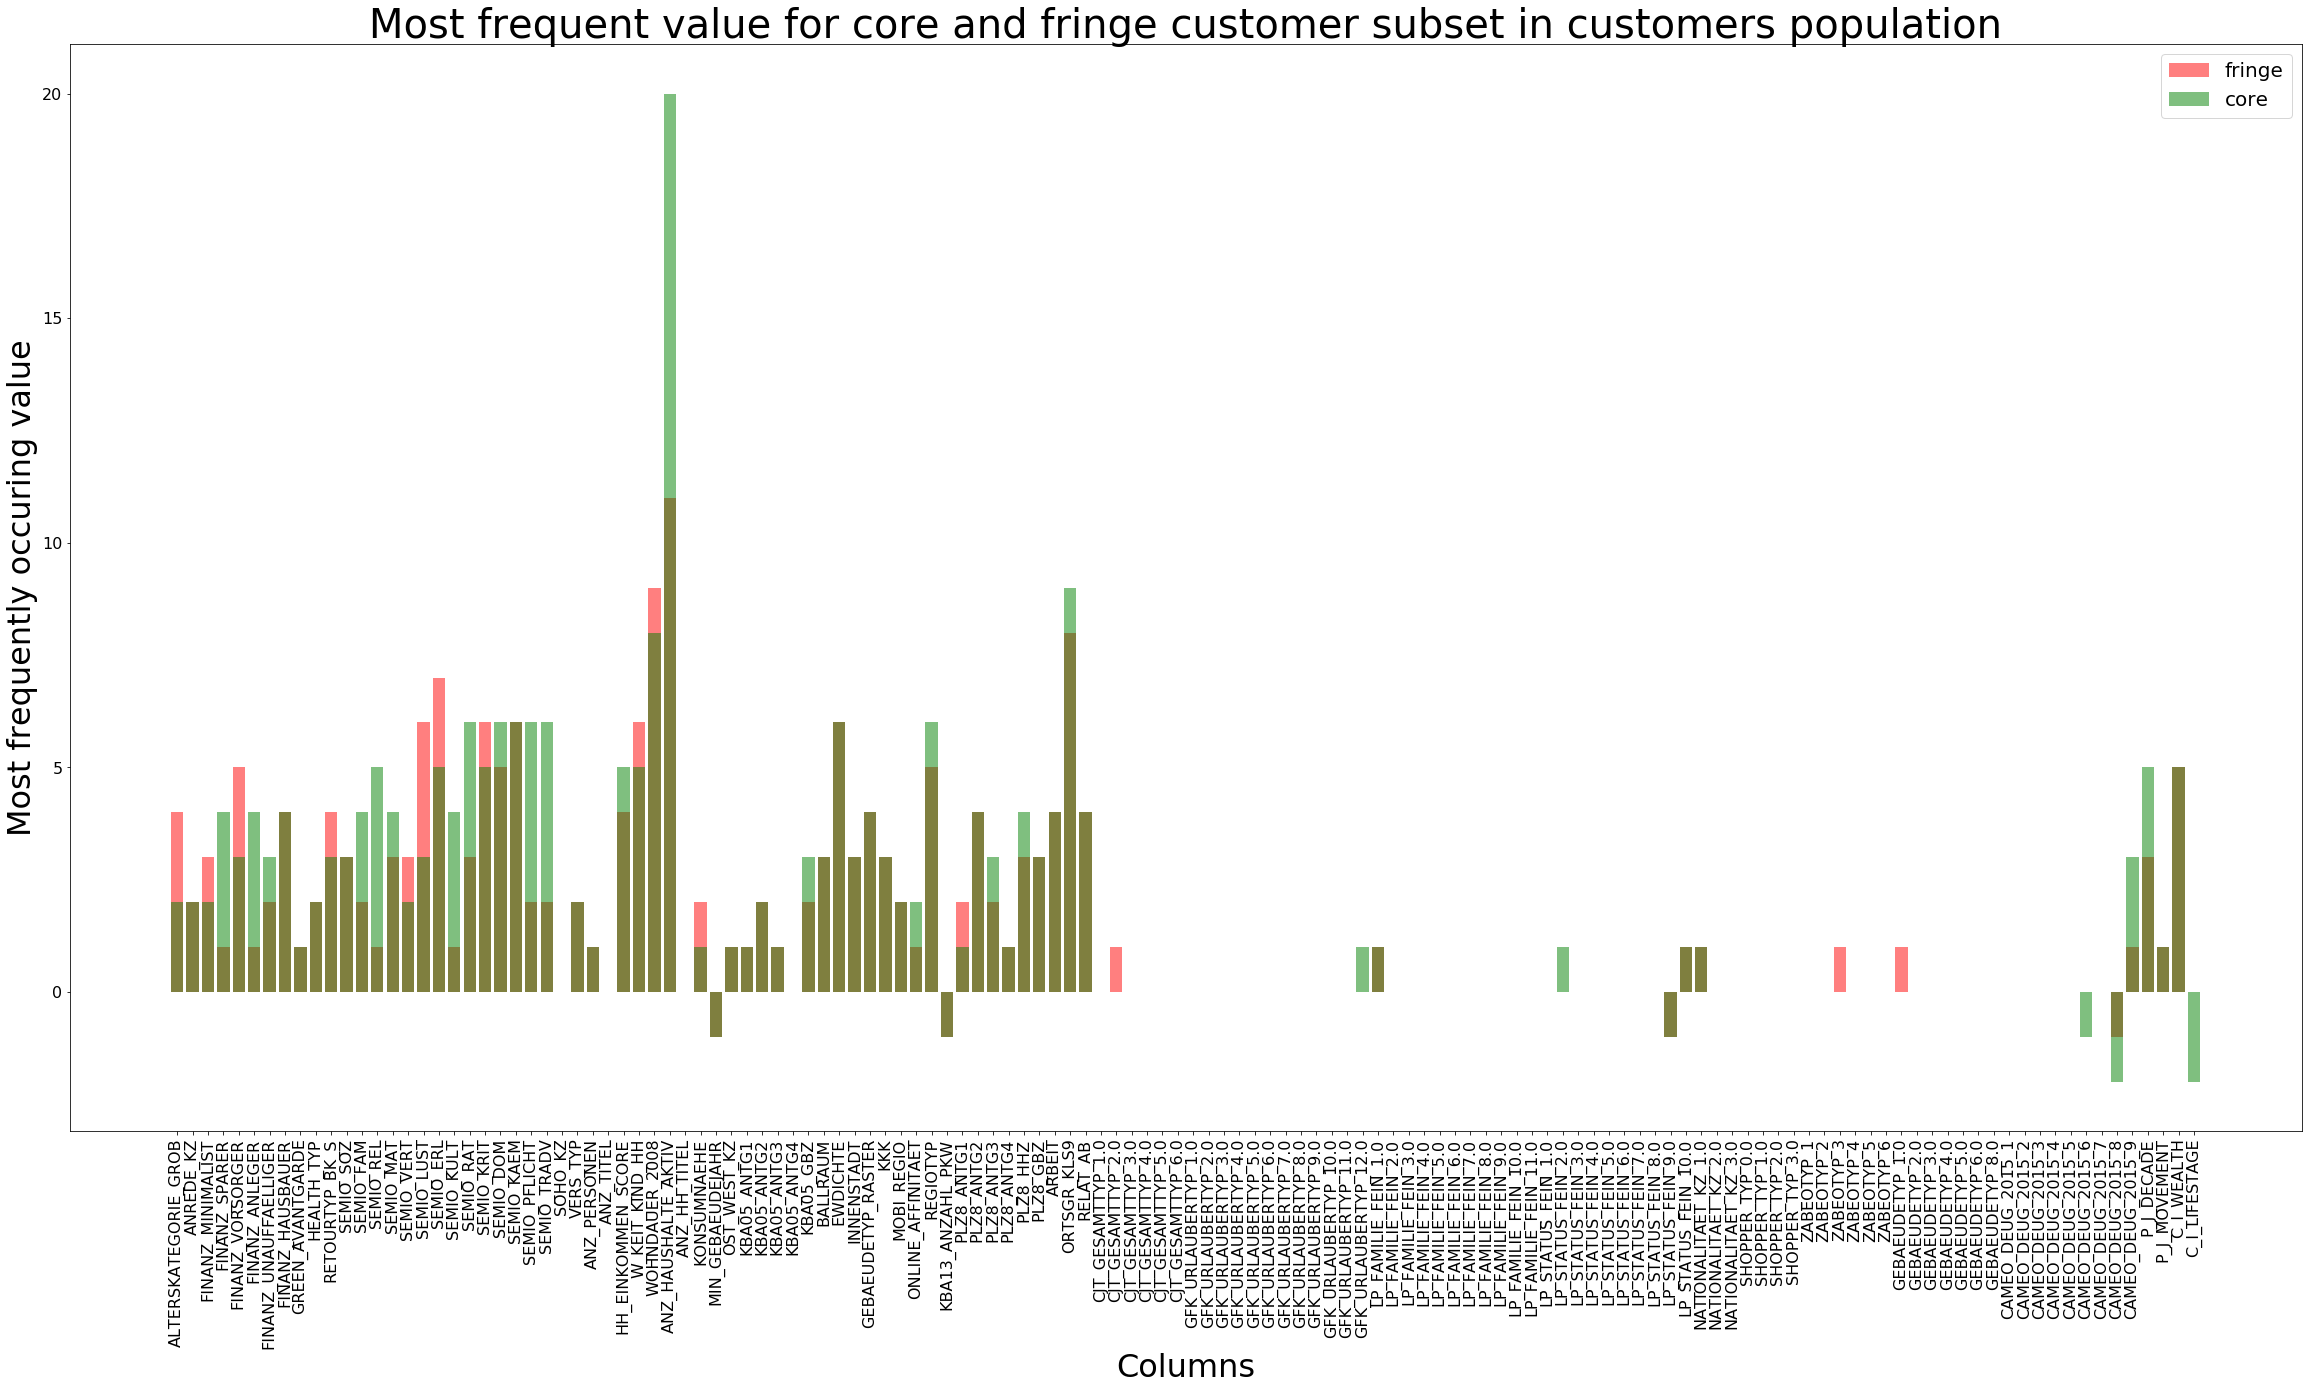

In [154]:
plot_core_vs_fringe(col_x_loc, col_x_labels, customers_core_modified, customers_fringe_modified, "customers")

Let's compare these plots with the top 5 features in the first three principal components.

In [155]:
for comp_num in range(1, 4):
    display(get_ordered_weights_for_pc(pca, X_col_names, comp_num).head(5))

,weights
MOBI_REGIO,-0.207701
FINANZ_MINIMALIST,-0.205951
PLZ8_ANTG1,-0.199199
PLZ8_ANTG3,0.198225
KBA05_ANTG1,-0.197435


,weights
ALTERSKATEGORIE_GROB,0.237213
P_J_DECADE,-0.228517
SEMIO_REL,-0.226876
FINANZ_SPARER,-0.221355
FINANZ_VORSORGER,0.215738


,weights
ANREDE_KZ,-0.354104
SEMIO_VERT,0.329592
SEMIO_KAEM,-0.324804
SEMIO_DOM,-0.297837
SEMIO_KRIT,-0.269978


Based on the converge of these two, we narrow down our features of interest to the following list.

In [161]:
features_of_interest = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'SEMIO_VERT', 'FINANZ_SPARER', 
                        'SEMIO_DOM', 'SEMIO_KRIT']

In [162]:
def plot_compare_clusters(core_cluster_df, fringe_cluster_df, cols):
    '''
    Plot distribution of columns across core and fringe clusters
    
    INPUT:  core_cluster_df - core cluster dataframe
            fringe_cluster_df - fringe cluster dataframe
            cols - columns to compare
            
    OUTPUT:
            None
    '''
    #https://matplotlib.org/gallery/subplots_axes_and_figures/axes_margins.html#sphx-glr-gallery-subplots-axes-and-figures-axes-margins-py
    for idx, col in enumerate(cols):
        print('\t%d) %s' %(idx+1, col))
        plt.figure(figsize=(20, 10))
        plt.subplot(121)
        sns.countplot(x=col, data=core_cluster_df).set_title('Distribution in Core cluster')

        plt.subplot(122)
        sns.countplot(x=col, data=fringe_cluster_df).set_title('Distribution in Fringe cluster')
        plt.show()
        print('\n\n')

Lets plot the comparison for the general population.

	1) ALTERSKATEGORIE_GROB


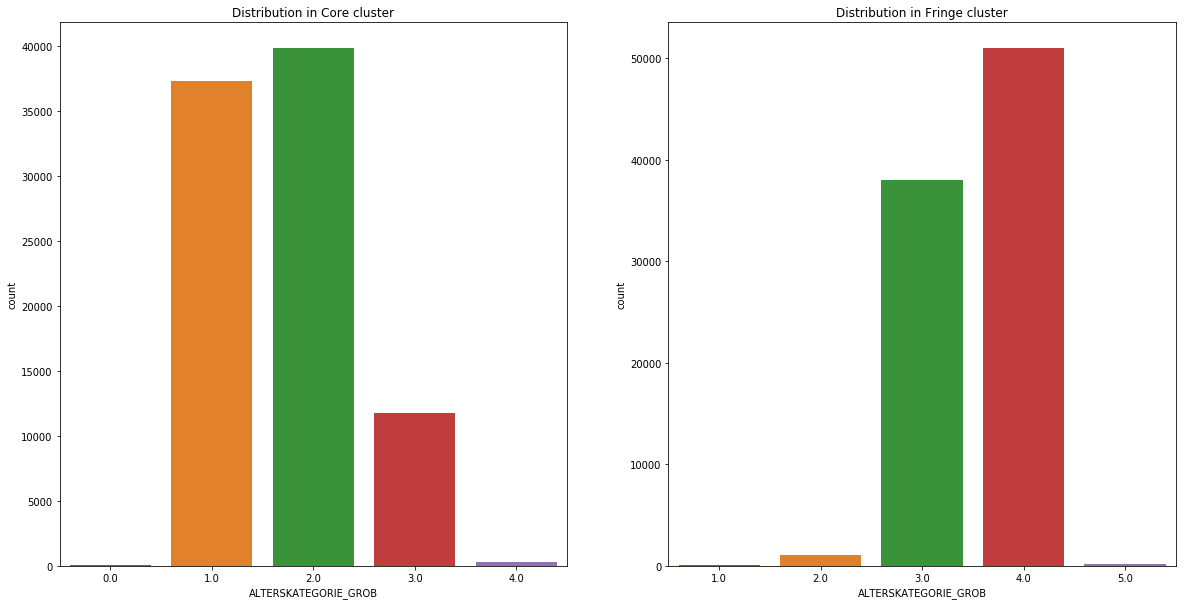




	2) ANREDE_KZ


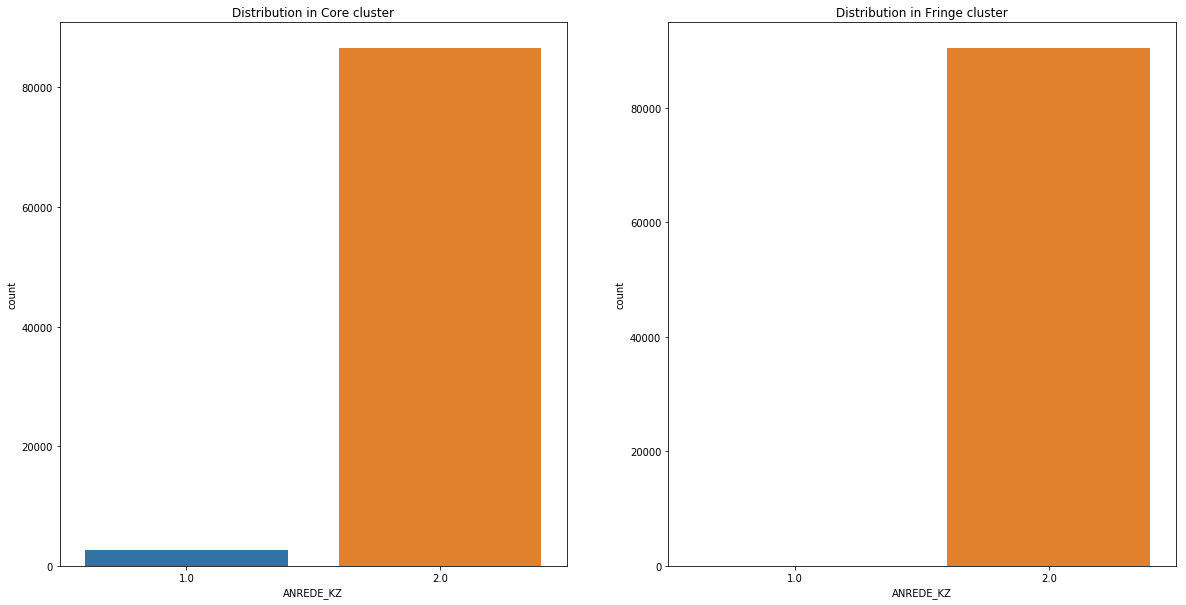




	3) SEMIO_VERT


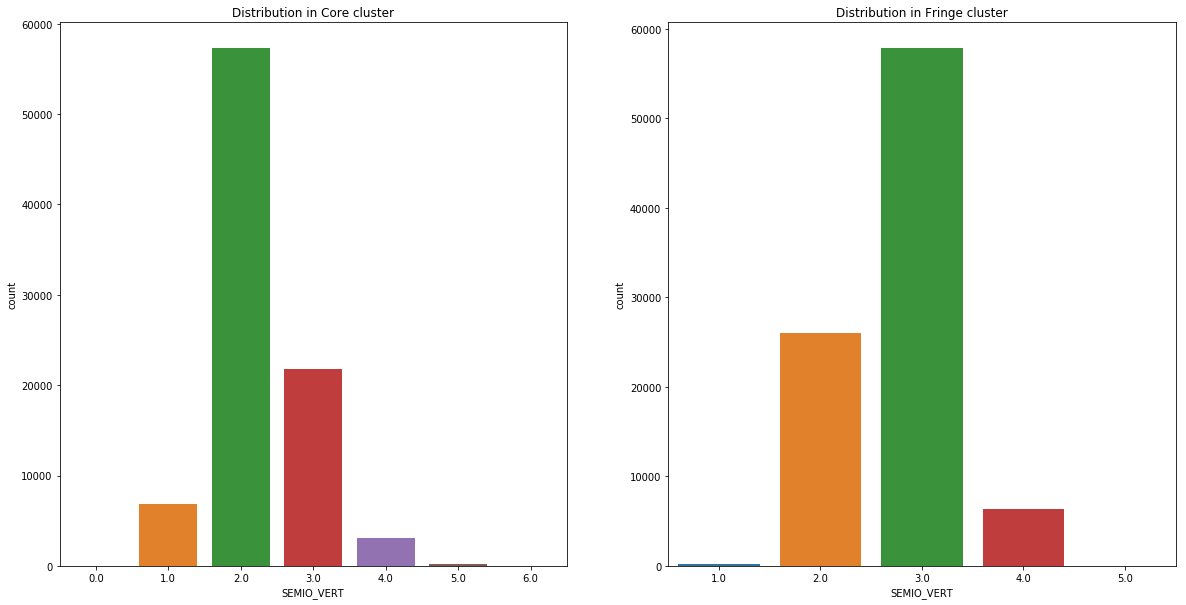




	4) FINANZ_SPARER


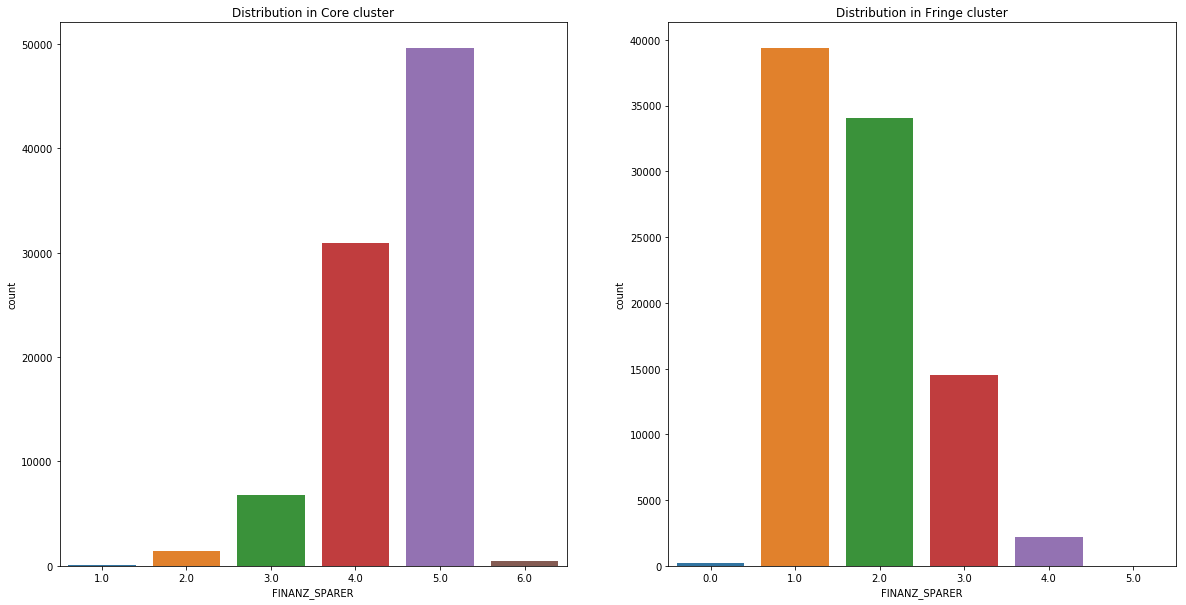




	5) SEMIO_DOM


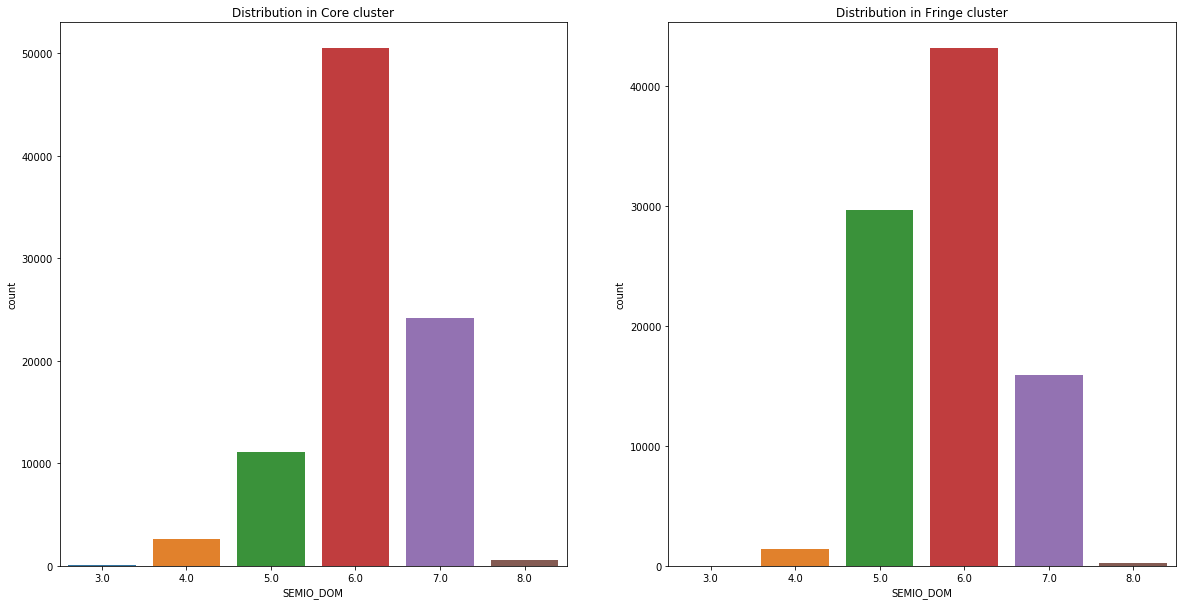




	6) SEMIO_KRIT


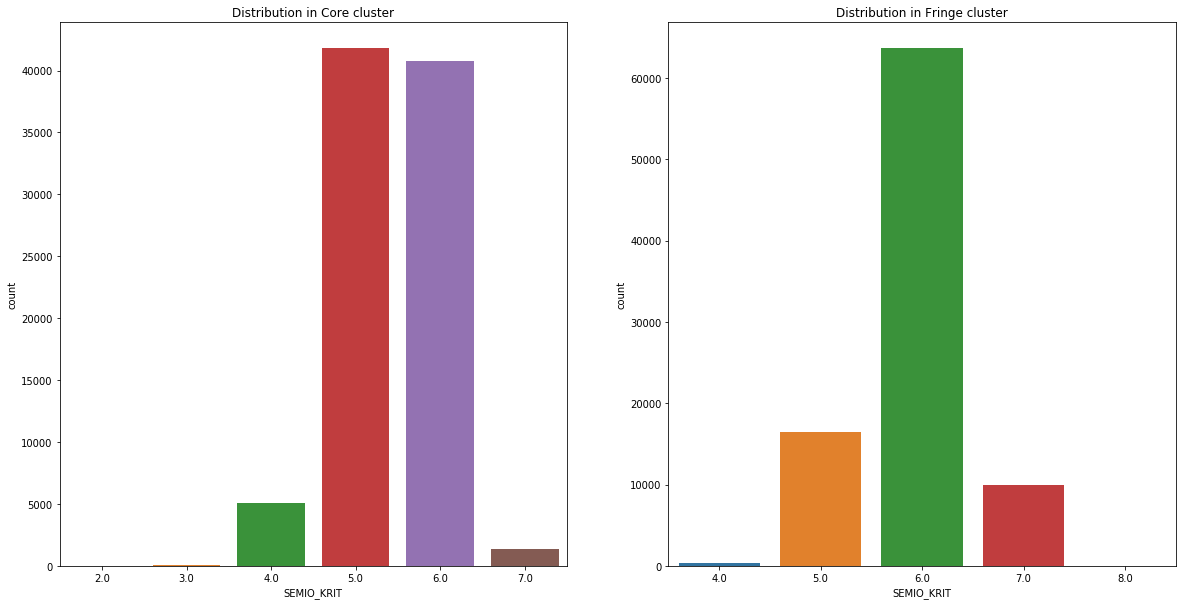

In [163]:
plot_compare_clusters(azdias_core, azdias_fringe, features_of_interest)

Now let's plot the same for the customer dataset

	1) ALTERSKATEGORIE_GROB


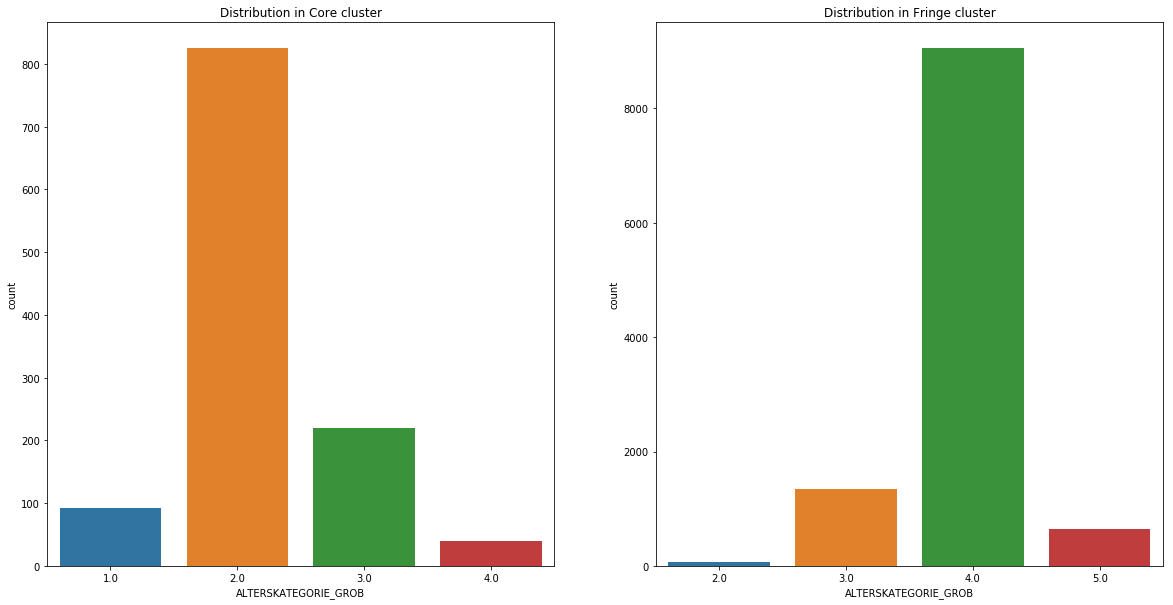




	2) ANREDE_KZ


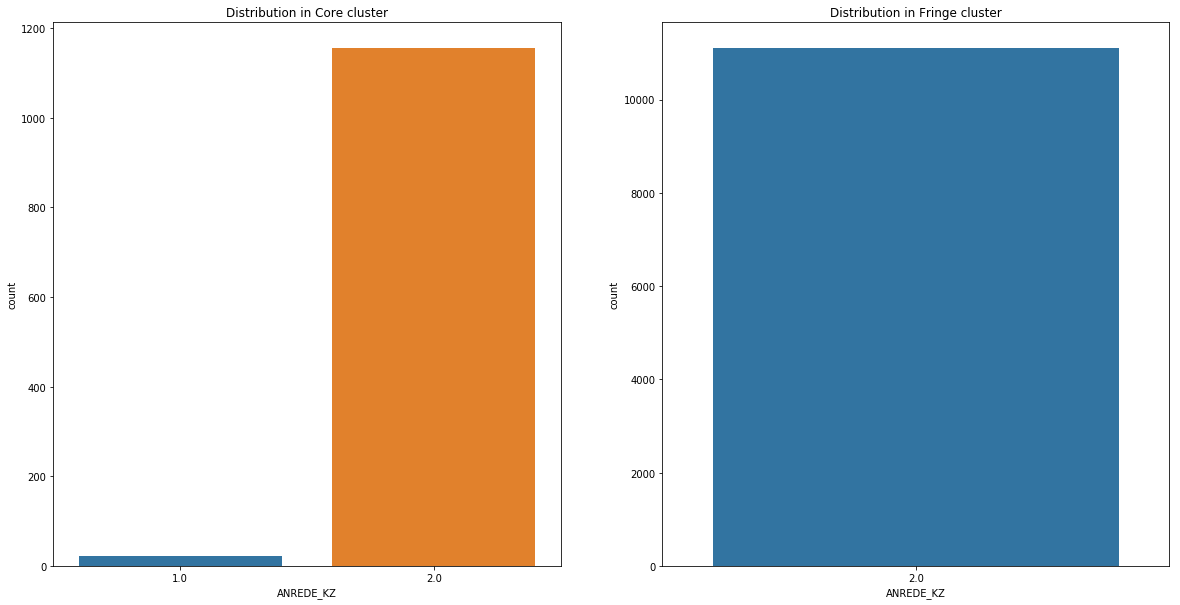




	3) SEMIO_VERT


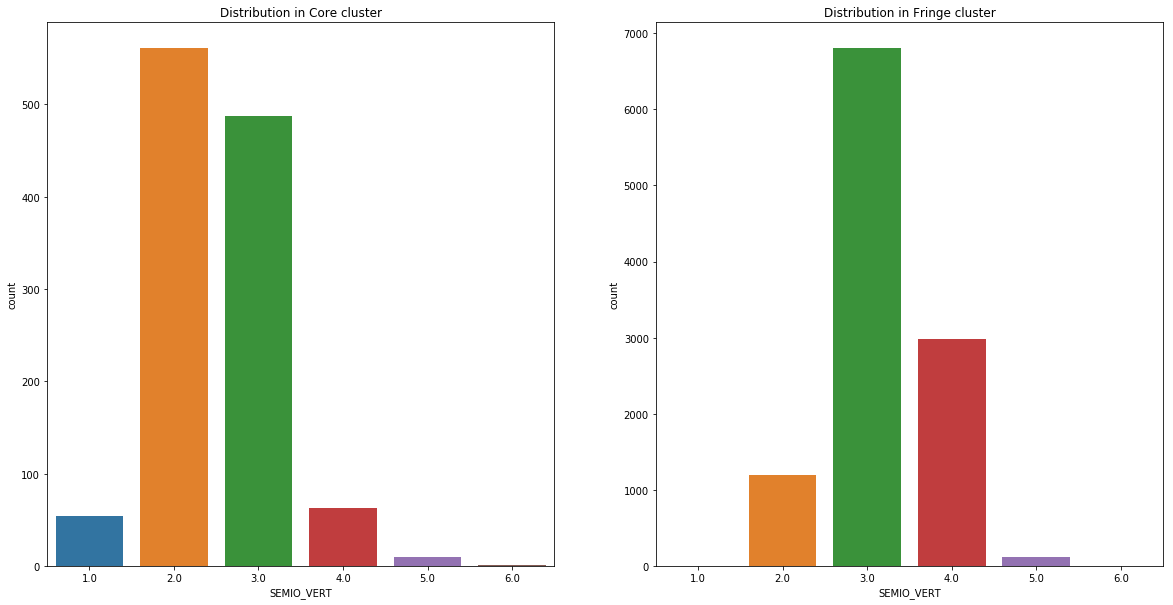




	4) FINANZ_SPARER


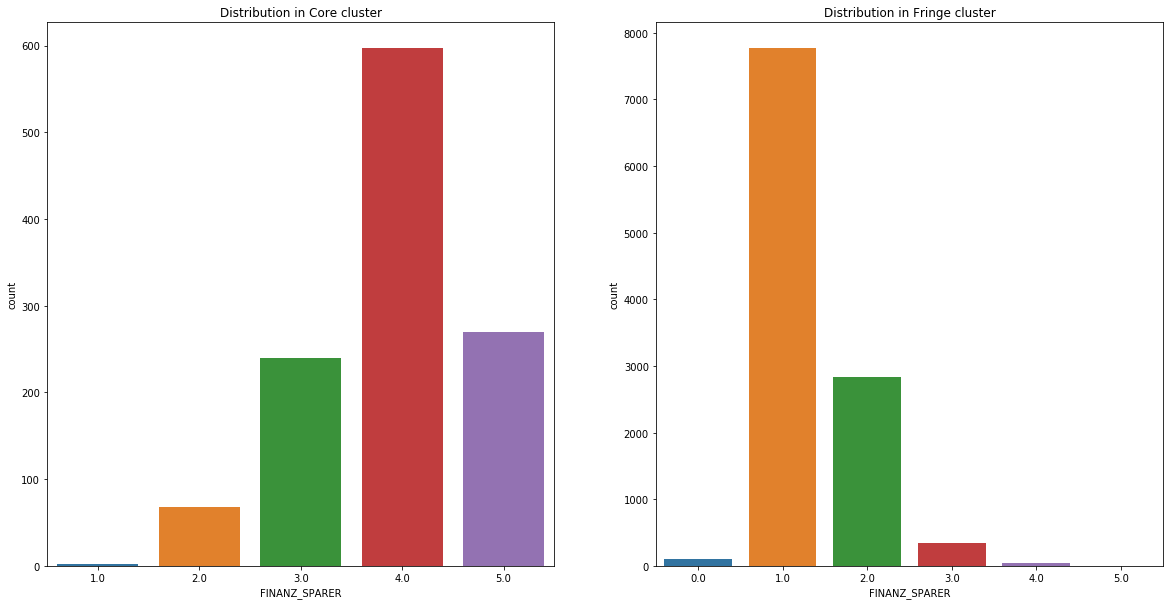




	5) SEMIO_DOM


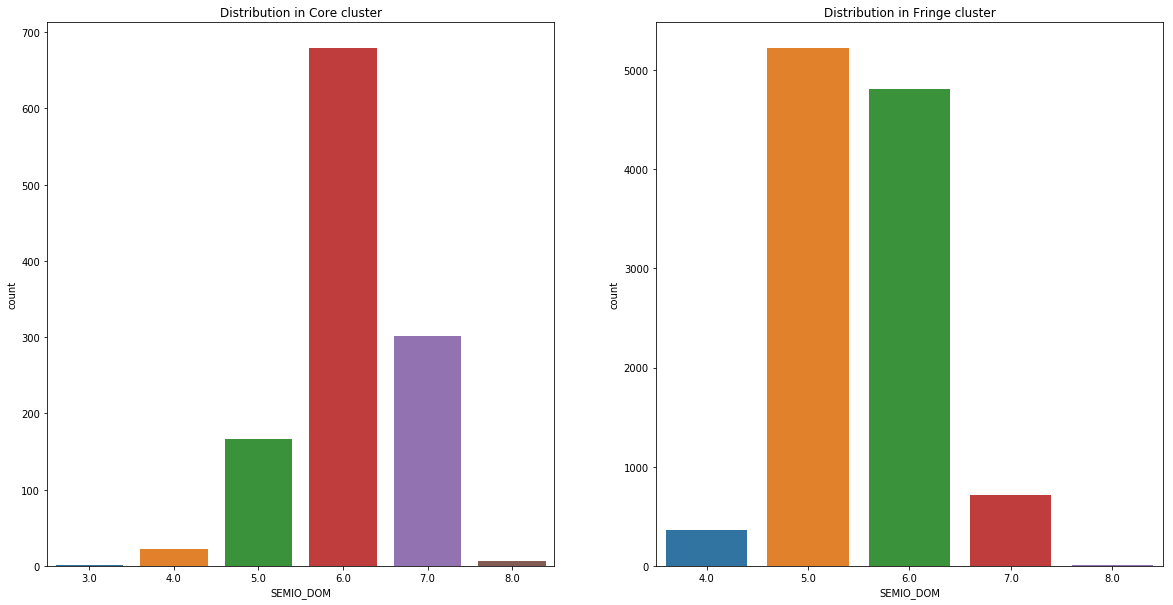




	6) SEMIO_KRIT


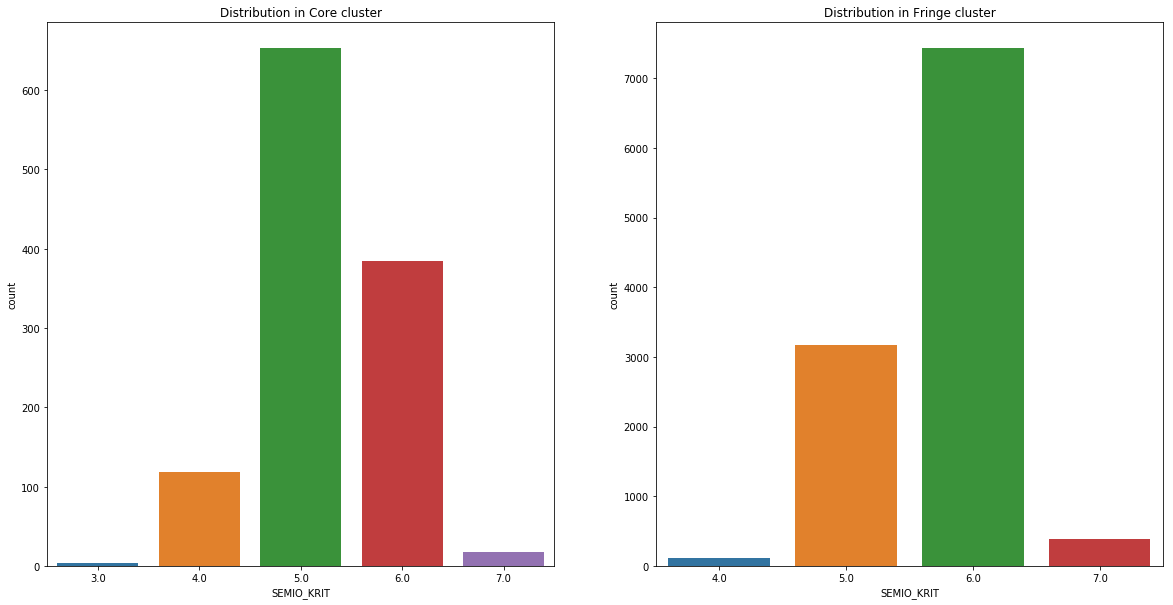

In [164]:
plot_compare_clusters(customers_core, customers_fringe, features_of_interest)

### Discussion 3.3: Compare Customer Data to Demographics Data

`ALTERSKATEGORIE_GROB` - Older age groups above 46 are overrepresented in customer dataset and below 30 group is underrepresented  
`ANREDE_KZ` - Men are dominant in cluster 6 and women are dominant in cluster 4.
`SEMIO_VERT` - Those who have high chance of being categorized as dreamy are less likely to be part of the customer group.
`FINANZ_SPARER` - Customers are not likely to be associated strongly as money savers.
`SEMIO_DOM` - Customers are likely to be identified as dominant minded.
`SEMIO_KRIT` - Customers are likely to be identified as critical minded.

Based on our analysis, we should target marketing campaign toward older men who are likely to be identified as dominant and critical minded in composure, and are less likely to be known as money savers.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.